In [2]:
import os
from os.path import exists, join
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import numpy as np
from collections import Counter

import sys
sys.path.append('../../..')
from miit.reg_graph import RegGraph
import json

In [3]:
def get_sp_stats(df, col1, col2, corr_type='s'):
    if corr_type == 's':
        sp_corr = scipy.stats.spearmanr(df[col1], df[col2])
    else:
        sp_corr = scipy.stats.pearsonr(df[col1], df[col2])
    result = {
        'statistic': sp_corr.statistic,
        'pvalue': sp_corr.pvalue,
        'n': df.shape[0]
    }
    return pd.DataFrame(result, index=[0])

def preprocess(df, sort_by_recurrence=True):
    # First renaming
    if sort_by_recurrence:
        df = df.sort_values('recurrence')
    df.loc[df.unified_hp_class == 'Non-cancer glands', 'unified_hp_class'] = 'Gland'
    df.loc[df.msi_hist == 'Non-cancer glands', 'msi_hist'] = 'Gland'
    df.loc[df['Histology Class'] == 'Non-cancer glands', 'Histology Class'] = 'Gland'
    # hist_classes = ['Stroma', 'Non-cancer glands']
    hist_classes = ['Stroma', 'Gland']
    df = df[df.unified_hp_class.isin(hist_classes)]
    df = df[df.adjusted_core_type == 'n']
    return df

def preprocess_2(df):
    df = df[df.unified_hp_class == df.msi_hist]
    return df

def to_new_id(row):
    p_id = row['New_patient']
    if len(p_id) == 2:
        new_p_id = p_id[0] + '0' + p_id[1]
    else:
        new_p_id = p_id
    return new_p_id + '_' + str(row['Samp_nr'])

def fix_patient_id(row):
    s_id = row['Sample ID']
    s_id = s_id.replace(' ', '_')
    s_id = s_id.replace('.', '_')
    return s_id

In [4]:
df = pd.read_csv('../metadata_big_final.csv')

In [5]:
new_sid_df = pd.read_csv('new_sample_id.tsv', sep='\t')
new_sid_df['new_sample_id'] = new_sid_df.apply(lambda x: to_new_id(x), axis=1)
metadata_df = pd.read_csv('../metadata_big_final.csv')
metadata_df['fixed_sample_id'] = metadata_df.apply(lambda x: fix_patient_id(x), axis=1)
metadata_df = metadata_df.merge(new_sid_df, left_on='fixed_sample_id', right_on='Sample ID')
metadata_df.head(2)

Sample ID_x adjusted_core_type  Round nr Square (a-d) on slide    type  \
0  PS D008.c2                  c        47                     a  Cancer   
1  PS D004.c6                  c        47                     b  Cancer   

   recurrence patient_id core_name st_identifier_y correct_st_identifier  \
0     control    PS_D008    047_01    V10A20_007_1          V10A20_007_A   
1  recurrence    PS_D004    047_02    V10A20_007_2          V10A20_007_B   

  fixed_sample_id Sample ID_y New_samp Patient New_patient  Samp_nr  slide  \
0      PS_D008_c2  PS_D008_c2    P28_2    D008         P28        2     47   
1      PS_D004_c6  PS_D004_c6    P27_3    D004         P27        3     47   

  position new_sample_id  
0        a         P28_2  
1        b         P27_3

In [6]:
# Set up all path
# merged_neg_correct_df = pd.read_csv('st_msi_meta_big_correct_data.csv')
# merged_neg_wrong_df = pd.read_csv('st_msi_meta_big_wrong_data.csv')
# merged_pos_correct_df = pd.read_csv('st_msi_pos_meta_big_correct_data.csv')
# merged_pos_wrong_df = pd.read_csv('st_msi_pos_meta_big_wrong_data.csv')

merged_neg_correct_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/merged_st_msi_neg.csv', index_col=0)
merged_neg_wrong_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/artificial_merged_st_msi_neg.csv', index_col=0)
merged_pos_correct_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/merged_st_msi_pos.csv', index_col=0)
merged_pos_wrong_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/artificial_merged_st_msi_pos.csv', index_col=0)

In [ ]:
a.shape, b.shape, c.shape, d.shape, (e.neg == e.pos).sum()

((3848,), (3695,), (2537,), (2486,), 2051)

In [109]:
1 - c.shape[0]/a.shape[0], 1 - d.shape[0]/b.shape[0]

(0.3406964656964657, 0.3271989174560217)

In [101]:
(c.neg == c.pos).sum(), c.shape[0], 14022/19515

(2820, 3917, 0.7185242121445042)

In [7]:
merged_pos_correct_df

met_Choline  met_Creatine  met_Acetylcholine  \
V10A20_007_A_AAACGAGACGGTTGAT-1    86.132290     36.063044           1.266693   
V10A20_007_A_AAAGGGATGTAGCAAG-1   123.561595     41.414101           1.133725   
V10A20_007_A_AAATACCTATAAGCAT-1    75.380085     36.128541           1.179189   
V10A20_007_A_AAATCGTGTACCACAA-1    88.484290     22.238748           0.884027   
V10A20_007_A_AAATGGTCAATGTGCC-1    75.336666     32.132875           0.876687   
...                                      ...           ...                ...   
V19S23_108_D_TTGTAAGGCCAGTTGG-1   204.254409     15.344445           1.190383   
V19S23_108_D_TTGTAATCCGTACTCG-1   186.047863     21.121414           0.978424   
V19S23_108_D_TTGTCGTTCAGTTACC-1   238.285003     21.292167           1.059635   
V19S23_108_D_TTGTTCAGTGTGCTAC-1   213.781228     16.948340           1.181601   
V19S23_108_D_TTGTTGTGTGTCAAGA-1   264.333085     13.547751           1.102306   

                                 met_Spermidine  met_Carnitine  \
V10A20_007_A_AAACGAGACGGTTGAT-1        0.431787      20.177582   
V10A20_007_A_AAAGGGATGTAGCAAG-1        0.296565      23.897140   
V10A20_007_A_AAATACCTATAAGCAT-1        0.262078      19.714350   
V10A20_007_A_AAATCGTGTACCACAA-1        0.366020      14.149705   
V10A20_007_A_AAATGGTCAATGTGCC-1        0.228932      18.690060   
...                                         ...            ...   
V19S23_108_D_TTGTAAGGCCAGTTGG-1        1.322440      18.939814   
V19S23_108_D_TTGTAATCCGTACTCG-1        1.626630      18.835670   
V19S23_108_D_TTGTCGTTCAGTTACC-1        1.170569      22.253471   
V19S23_108_D_TTGTTCAGTGTGCTAC-1        1.875594      20.749588   
V19S23_108_D_TTGTTGTGTGTCAAGA-1        1.121038      21.864531   

                                 met_Phosphocholine  met_Spermine  \
V10A20_007_A_AAACGAGACGGTTGAT-1            7.598939     27.333541   
V10A20_007_A_AAAGGGATGTAGCAAG-1           11.588977     24.192091   
V10A20_007_A_AAATACCTATAAGCAT-1            8.738278     48.537322   
V10A20_007_A_AAATCGTGTACCACAA-1            9.934690     36.659144   
V10A20_007_A_AAATGGTCAATGTGCC-1            7.179989     18.796102   
...                                             ...           ...   
V19S23_108_D_TTGTAAGGCCAGTTGG-1           27.072093      5.441309   
V19S23_108_D_TTGTAATCCGTACTCG-1            9.356092      3.950524   
V19S23_108_D_TTGTCGTTCAGTTACC-1           10.329747      6.157524   
V19S23_108_D_TTGTTCAGTGTGCTAC-1           18.837164      5.535767   
V19S23_108_D_TTGTTGTGTGTCAAGA-1            6.769658      4.835033   

                                 met_Acetylcarnitine  met_Butyryl‐L‐carnitine  \
V10A20_007_A_AAACGAGACGGTTGAT-1            27.272331                 3.853911   
V10A20_007_A_AAAGGGATGTAGCAAG-1            30.742080                 4.821105   
V10A20_007_A_AAATACCTATAAGCAT-1            26.721488                 4.355596   
V10A20_007_A_AAATCGTGTACCACAA-1            20.384659                 2.442234   
V10A20_007_A_AAATGGTCAATGTGCC-1            20.486011                 3.668276   
...                                              ...                      ...   
V19S23_108_D_TTGTAAGGCCAGTTGG-1            15.147364                 2.391927   
V19S23_108_D_TTGTAATCCGTACTCG-1            18.539827                 2.446713   
V19S23_108_D_TTGTCGTTCAGTTACC-1            16.147173                 2.713276   
V19S23_108_D_TTGTTCAGTGTGCTAC-1            14.695827                 3.771573   
V19S23_108_D_TTGTTGTGTGTCAAGA-1            12.540875                 3.115784   

                                 met_Hydroxybutyrylcarnitine  ...  \
V10A20_007_A_AAACGAGACGGTTGAT-1                     0.805576  ...   
V10A20_007_A_AAAGGGATGTAGCAAG-1                     1.029443  ...   
V10A20_007_A_AAATACCTATAAGCAT-1                     0.684509  ...   
V10A20_007_A_AAATCGTGTACCACAA-1                     0.829857  ...   
V10A20_007_A_AAATGGTCAATGTGCC-1                     0.798364  ...   
...                                                

In [44]:
merged_pos_correct_df.core_name.unique()

array(['047_01', '047_02', '047_03', '047_04', '045_01', '045_02',
       '045_03', '045_04', '048_01', '048_02', '048_03', '048_04',
       '046_01', '046_02', '046_03', '046_04', '002_01', '002_02',
       '002_03', '002_04', '001_01', '001_02', '001_03', '001_04',
       '003_01', '003_02', '003_03', '003_04', '004_01', '004_02',
       '004_03', '004_04'], dtype=object)

(19187, 2509)

In [7]:
# merged_neg_correct_df['Histology Class'] = merged_neg_correct_df['msi_hist']
# merged_neg_wrong_df['Histology Class'] = merged_neg_wrong_df['msi_hist']
# merged_pos_correct_df['Histology Class'] = merged_pos_correct_df['msi_hist']
# merged_pos_wrong_df['Histology Class'] = merged_pos_wrong_df['msi_hist']
merged_neg_correct_df['Histology Class'] = merged_neg_correct_df['unified_hp_class']
merged_neg_wrong_df['Histology Class'] = merged_neg_wrong_df['unified_hp_class']
merged_pos_correct_df['Histology Class'] = merged_pos_correct_df['unified_hp_class']
merged_pos_wrong_df['Histology Class'] = merged_pos_wrong_df['unified_hp_class']

In [8]:
merged_neg_correct_df_red = preprocess(merged_neg_correct_df)
merged_neg_wrong_df_red = preprocess(merged_neg_wrong_df)
merged_pos_correct_df_red = preprocess(merged_pos_correct_df)
merged_pos_wrong_df_red = preprocess(merged_pos_wrong_df)

In [9]:
merged_neg_correct_df_red2 = preprocess_2(merged_neg_correct_df_red)
merged_neg_wrong_df_red2 = preprocess_2(merged_neg_wrong_df_red)
merged_pos_correct_df_red2 = preprocess_2(merged_pos_correct_df_red)
merged_pos_wrong_df_red2 = preprocess_2(merged_pos_wrong_df_red)

In [57]:
merged_neg_correct_df_red.shape

(3848, 2509)

In [59]:
merged_neg_correct_df_red2.shape

(2537, 2509)

In [61]:
merged_neg_wrong_df_red2.shape

(1758, 2509)

In [62]:
994+836

1830

In [10]:
(merged_neg_correct_df_red2.shape[0] + merged_pos_correct_df_red2.shape[0])/(merged_neg_correct_df_red.shape[0] + merged_pos_correct_df_red.shape[0])

0.6659154182685934

## Plot correlations core wise

In [63]:
merged_neg_correct_df_red2['Histology Class'].unique()

array(['Stroma', 'Gland'], dtype=object)

In [64]:
merged_neg_correct_df.shape, merged_neg_correct_df_red.shape, merged_neg_correct_df_red2.shape

((19187, 2509), (3848, 2509), (2537, 2509))

In [65]:
def get_basic_stats(df, src_col, dst_col, c_type='s', group_col='core_name'):
    df_ = df.groupby(group_col).apply(lambda x: get_sp_stats(x, src_col, dst_col, corr_type=c_type))
    return df_

src_col = 'Citsper'
dst_neg_col = 'met_Citrate'
dst_neg_col2 = 'met_Zinc'
dst_pos_col = 'met_Spermine'
c_type = 's'

nc_1_cit_core_sp_stats = get_basic_stats(merged_neg_correct_df_red, src_col, dst_neg_col, c_type)
nw_1_cit_core_sp_stats = get_basic_stats(merged_neg_wrong_df_red, src_col, dst_neg_col, c_type)
nc_1_zinc_core_sp_stats = get_basic_stats(merged_neg_correct_df_red, src_col, dst_neg_col2, c_type)
nw_1_zinc_core_sp_stats = get_basic_stats(merged_neg_wrong_df_red, src_col, dst_neg_col2, c_type)
pc_1_spe_core_sp_stats = get_basic_stats(merged_pos_correct_df_red, src_col, dst_pos_col, c_type)
pw_1_spe_core_sp_stats = get_basic_stats(merged_pos_wrong_df_red, src_col, dst_pos_col, c_type)

nc_2_cit_core_sp_stats = get_basic_stats(merged_neg_correct_df_red2, src_col, dst_neg_col, c_type)
nw_2_cit_core_sp_stats = get_basic_stats(merged_neg_wrong_df_red2, src_col, dst_neg_col, c_type)
nc_2_zinc_core_sp_stats = get_basic_stats(merged_neg_correct_df_red2, src_col, dst_neg_col2, c_type)
nw_2_zinc_core_sp_stats = get_basic_stats(merged_neg_wrong_df_red2, src_col, dst_neg_col2, c_type)
pc_2_spe_core_sp_stats = get_basic_stats(merged_pos_correct_df_red2, src_col, dst_pos_col, c_type)
pw_2_spe_core_sp_stats = get_basic_stats(merged_pos_wrong_df_red2, src_col, dst_pos_col, c_type)

# w_core_sp_stats_f = w_spot_annotations_df_merged_matching_f.groupby('core_name').apply(lambda x: get_sp_stats(x, 'Citsper', 'met_median_Citrate'))
# core_sp_stats_f = spot_annotations_df_merged_matching_f.groupby('core_name').apply(lambda x: get_sp_stats(x, 'Citsper', 'met_Citrate'))
# all_stats_1 = pd.concat([core_sp_stats_f.rename(columns={x: x + '_correct' for x in core_sp_stats_f.columns}), w_core_sp_stats_f.rename(columns={x: x + '_wrong' for x in w_core_sp_stats_f.columns})], axis=1)
# all_stats_1.index = [x[0] for x in all_stats_1.index]

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grou

In [66]:
def merge_correct_and_wrong(df1, df2):
    df3 = pd.concat([df1.rename(columns={x: x + '_correct' for x in df1.columns}), df2.rename(columns={x: x + '_wrong' for x in df2.columns})], axis=1)
    return df3


In [67]:
a1_cit_merged_df = merge_correct_and_wrong(nc_1_cit_core_sp_stats, nw_1_cit_core_sp_stats)
a1_zinc_merged_df = merge_correct_and_wrong(nc_1_zinc_core_sp_stats, nw_1_zinc_core_sp_stats)
a1_spe_merged_df = merge_correct_and_wrong(pc_1_spe_core_sp_stats, pw_1_spe_core_sp_stats)
a2_cit_merged_df = merge_correct_and_wrong(nc_2_cit_core_sp_stats, nw_2_cit_core_sp_stats)
a2_zinc_merged_df = merge_correct_and_wrong(nc_2_zinc_core_sp_stats, nw_2_zinc_core_sp_stats)
a2_spe_merged_df = merge_correct_and_wrong(pc_2_spe_core_sp_stats, pw_2_spe_core_sp_stats)

In [68]:
a2_zinc_merged_df

statistic_correct  pvalue_correct  n_correct  statistic_wrong  \
core_name                                                                    
001_04    0           0.409107    2.109747e-16        371         0.242026   
002_01    0           0.497298    3.401214e-25        381         0.274833   
003_02    0           0.033879    6.408522e-01        192         0.225438   
004_03    0           0.225670    1.204017e-05        369        -0.007712   
045_03    0           0.462778    3.582788e-30        543         0.024748   
047_04    0           0.450284    2.573200e-21        399         0.460741   
048_02    0           0.277560    2.205099e-06        282        -0.061772   

             pvalue_wrong  n_wrong  
core_name                           
001_04    0  3.002863e-04      219  
002_01    0  9.665623e-07      308  
003_02    0  8.818950e-03      134  
004_03    0  9.067927e-01      233  
045_03    0  6.388459e-01      362  
047_04    0  1.972739e-18      324  
048_02    0  4.127217e-01      178

In [69]:
a2_cit_merged_df

statistic_correct  pvalue_correct  n_correct  statistic_wrong  \
core_name                                                                    
001_04    0           0.572604    1.052932e-33        371         0.468267   
002_01    0           0.601282    8.018855e-39        381         0.309165   
003_02    0           0.200403    5.318925e-03        192         0.213119   
004_03    0           0.236663    4.302982e-06        369        -0.002790   
045_03    0           0.539220    2.762129e-42        543         0.212172   
047_04    0           0.575421    1.489882e-36        399         0.520236   
048_02    0           0.335997    7.192221e-09        282        -0.052637   

             pvalue_wrong  n_wrong  
core_name                           
001_04    0  2.466191e-13      219  
002_01    0  3.023435e-08      308  
003_02    0  1.342145e-02      134  
004_03    0  9.662119e-01      233  
045_03    0  4.715368e-05      362  
047_04    0  7.262593e-24      324  
048_02    0  4.853017e-01      178

In [70]:
a2_spe_merged_df

statistic_correct  pvalue_correct  n_correct  statistic_wrong  \
core_name                                                                    
001_04    0           0.645324    1.719202e-42        349         0.333258   
002_01    0           0.459313    5.575842e-20        356         0.050702   
003_02    0           0.316129    6.026957e-06        197        -0.081903   
004_03    0           0.196107    3.386242e-04        330         0.210690   
045_03    0           0.533164    5.172721e-42        554         0.382641   
047_04    0           0.583211    3.484009e-38        404         0.424187   
048_02    0           0.391216    2.899232e-12        296         0.167791   

             pvalue_wrong  n_wrong  
core_name                           
001_04    0  1.398230e-07      238  
002_01    0  3.980226e-01      280  
003_02    0  3.378056e-01      139  
004_03    0  1.374926e-03      228  
045_03    0  6.811914e-14      357  
047_04    0  5.158354e-15      311  
048_02    0  2.206794e-02      186

## Analyze correlation between spe and cit,zinc

In [71]:
# merged_neg_correct_df_red2.set_index('copy_index', inplace=True)
# merged_pos_correct_df_red2.set_index('copy_index', inplace=True)
idxs_intersection = merged_neg_correct_df_red2.index.intersection(merged_pos_correct_df_red2.index)
idxs_intersection.shape


(2051,)

In [72]:
unique_cols = [x for x in merged_pos_correct_df_red2.columns if x not in merged_neg_correct_df_red2.columns]

In [73]:
match_pos_neg_df = merged_neg_correct_df_red2.loc[idxs_intersection].copy()
match_pos_neg_df = pd.concat([match_pos_neg_df, merged_pos_correct_df_red2.loc[idxs_intersection, unique_cols]], axis=1)
match_pos_neg_df

met_Taurine  met_Aspartate    met_PEA  \
V10A20_008_C_TGAGTAAATTAGCGTA-1    33.223138      10.238029   7.450816   
V10A20_008_C_TGACTATAATCCTTTC-1    16.991054      10.838708   3.331815   
V10A20_008_C_TGACGATGCACTAGAA-1    26.620589      12.268402   5.587429   
V10A20_008_C_TCTTTAAGACTATGAA-1    30.436047      13.501103   7.099612   
V10A20_008_C_TCTTCGATACCAATAA-1    37.478894      10.395936  10.578514   
...                                      ...            ...        ...   
V10A20_009_B_TCCGCTTATCCCATTA-1    49.834080       7.606023  12.614583   
V10A20_009_B_TCCTCGGGCTGGGCTT-1    55.317246       9.188780  14.362982   
V10A20_009_B_TCGAAATTTAGGACCA-1    29.430563       9.429979   7.929358   
V10A20_009_B_TCGCAAAGATGCATTT-1    47.864633       9.298290  13.046626   
V10A20_009_B_TCGCACCAGGAGGCAG-1     9.482226       9.176866   3.243109   

                                 met_Glutamine  met_Glutamate  met_Urate  \
V10A20_008_C_TGAGTAAATTAGCGTA-1       7.298526      25.187163   2.377048   
V10A20_008_C_TGACTATAATCCTTTC-1       6.362406      13.519342   1.201793   
V10A20_008_C_TGACGATGCACTAGAA-1       9.203929      19.072033   1.732747   
V10A20_008_C_TCTTTAAGACTATGAA-1      11.449995      29.718590   2.321004   
V10A20_008_C_TCTTCGATACCAATAA-1      10.253585      22.436259   2.905612   
...                                        ...            ...        ...   
V10A20_009_B_TCCGCTTATCCCATTA-1       9.370747      48.443955   6.106862   
V10A20_009_B_TCCTCGGGCTGGGCTT-1       9.939783      45.039207   4.731981   
V10A20_009_B_TCGAAATTTAGGACCA-1       4.744046      23.908097   3.385476   
V10A20_009_B_TCGCAAAGATGCATTT-1      10.331209      43.965105   4.997889   
V10A20_009_B_TCGCACCAGGAGGCAG-1       4.339512      14.171705   2.230053   

                                  met_NAA  met_Zinc  met_Ascorbate  \
V10A20_008_C_TGAGTAAATTAGCGTA-1  7.900184  1.273116       4.732885   
V10A20_008_C_TGACTATAATCCTTTC-1  2.147389  8.917781       6.459560   
V10A20_008_C_TGACGATGCACTAGAA-1  2.763350  1.609675       6.527469   
V10A20_008_C_TCTTTAAGACTATGAA-1  3.956264  1.907365       5.546912   
V10A20_008_C_TCTTCGATACCAATAA-1  4.229931  2.983699       5.013871   
...                                   ...       ...            ...   
V10A20_009_B_TCCGCTTATCCCATTA-1  4.406097  0.686316       3.727358   
V10A20_009_B_TCCTCGGGCTGGGCTT-1  4.230029  1.020093       3.985214   
V10A20_009_B_TCGAAATTTAGGACCA-1  3.609519  1.486139       5.075081   
V10A20_009_B_TCGCAAAGATGCATTT-1  4.490808  0.758460       4.322556   
V10A20_009_B_TCGCACCAGGAGGCAG-1  2.114544  1.264662       3.996852   

                                 met_Citrate  ...  met_PC (36:4)  \
V10A20_008_C_TGAGTAAATTAGCGTA-1   202.360513  ...       3.405994   
V10A20_008_C_TGACTATAATCCTTTC-1   234.177118  ...       6.123449   
V10A20_008_C_TGACGATGCACTAGAA-1   226.667328  ...       5.766839   
V10A20_008_C_TCTTTAAGACTATGAA-1   208.524249  ...       2.951047   
V10A20_008_C_TCTTCGATACCAATAA-1   188.819931  ...       2.590720   
...                                      ...  ...            ...   
V10A20_009_B_TCCGCTTATCCCATTA-1   162.762956  ...       6.035318   
V10A20_009_B_TCCTCGGGCTGGGCTT-1   163.214684  ...       5.536144   
V10A20_009_B_TCGAAATTTAGGACCA-1   236.862918  ...      11.241156   
V10A20_009_B_TCGCAAAGATGCATTT-1   196.298088  ...       7.223298   
V10A20_009_B_TCGCACCAGGAGGCAG-1   256.051716  ...      10.536601   

                                 met_PC (36:2)  met_PC (36:1)  \
V10A20_008_C_TGAGTAAATTAGCGTA-1       6.361692       5.580931   
V10A20_008_C_TGACTATAATCCTTTC-1      21.803351      21.533624   
V10A20_008_C_TGACGATGCACTAGAA-1      12.930464      12.581019   
V10A20_008_C_TCTTTAAGACTATGAA-1       4.696433       5.129539   
V10A20_008_C_TCTTCGATACCAATAA-1       6.645411       4.861336   
...                                        ...            ...   
V10A20_009_B_TCCGCTTATCCCATTA-1       3.859386       5.046993   
V10A20_009_B_TCCTCGGGCTGGGCTT-1      10.609985       

In [74]:
nc_2_cit_core_sp_stats.index = [x[0] for x in nc_2_cit_core_sp_stats.index]
nw_2_cit_core_sp_stats.index = [x[0] for x in nw_2_cit_core_sp_stats.index]
nc_1_cit_core_sp_stats.index = [x[0] for x in nc_1_cit_core_sp_stats.index]
nw_1_cit_core_sp_stats.index = [x[0] for x in nw_1_cit_core_sp_stats.index]
nc_2_zinc_core_sp_stats.index = [x[0] for x in nc_2_zinc_core_sp_stats.index]
nw_2_zinc_core_sp_stats.index = [x[0] for x in nw_2_zinc_core_sp_stats.index]
nc_1_zinc_core_sp_stats.index = [x[0] for x in nc_1_zinc_core_sp_stats.index]
nw_1_zinc_core_sp_stats.index = [x[0] for x in nw_1_zinc_core_sp_stats.index]
pc_2_spe_core_sp_stats.index = [x[0] for x in pc_2_spe_core_sp_stats.index]
pw_2_spe_core_sp_stats.index = [x[0] for x in pw_2_spe_core_sp_stats.index]
pc_1_spe_core_sp_stats.index = [x[0] for x in pc_1_spe_core_sp_stats.index]
pw_1_spe_core_sp_stats.index = [x[0] for x in pw_1_spe_core_sp_stats.index]

In [75]:
print('Loss of available spots for neg integration: ', 1 - nc_2_cit_core_sp_stats.n.sum()/nc_1_cit_core_sp_stats.n.sum())

Loss of available spots for neg integration:  0.3406964656964657


In [76]:
print('Loss of available spots for neg integration: ', 1 - pc_2_spe_core_sp_stats.n.sum()/pc_1_spe_core_sp_stats.n.sum())

Loss of available spots for neg integration:  0.3271989174560217


In [77]:
1-2537/3848, 

(0.3406964656964657,)

In [78]:
# First 3 are control, the rest is recurrence
plot_order = ['001_04', '002_01', '045_03', '003_02', '004_03', '047_04', '048_02']

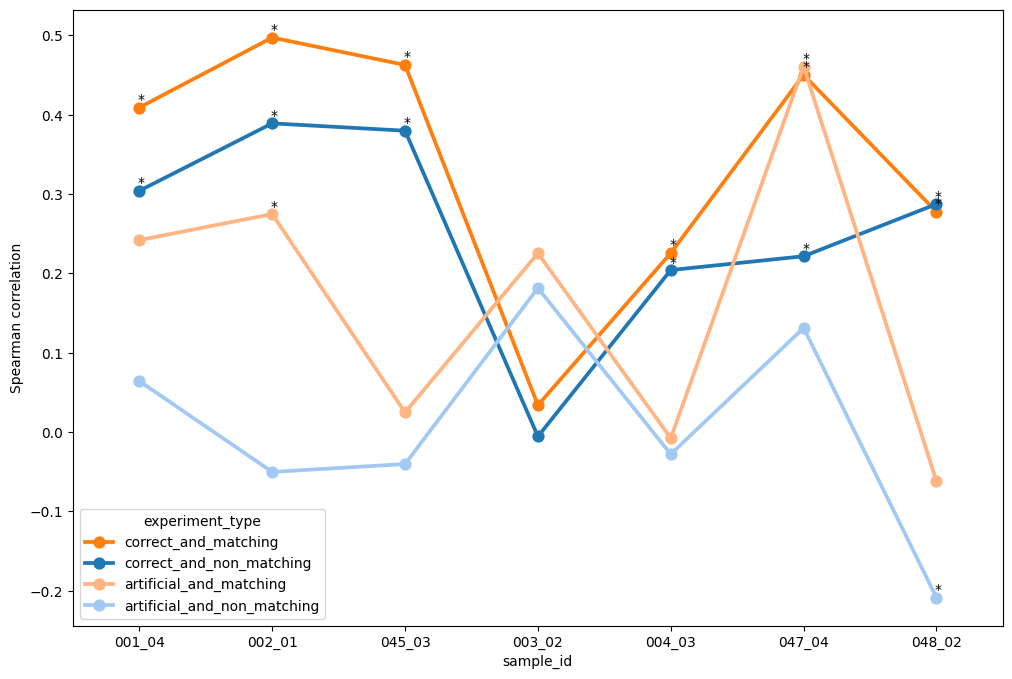

In [79]:
# Built a plotable dataframe.
as2c_df = nc_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_zinc_core_sp_stats.columns})
as2c_df['experiment_type'] = 'correct_and_matching'
as2w_df = nw_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_zinc_core_sp_stats.columns})
as2w_df['experiment_type'] = 'artificial_and_matching'
as1c_df = nc_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_zinc_core_sp_stats.columns})
as1c_df['experiment_type'] = 'correct_and_non_matching'
as1w_df = nw_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_zinc_core_sp_stats.columns})
as1w_df['experiment_type'] = 'artificial_and_non_matching'
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['sample_id'] = stats_df.index
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)
stats_df.head(4)
standard_color = sns.color_palette()
light_color = sns.color_palette('pastel')
experiment_type_color_mapping = {}
experiment_type_color_mapping['correct_and_non_matching'] = standard_color[0]
experiment_type_color_mapping['artificial_and_non_matching'] = light_color[0]
experiment_type_color_mapping['correct_and_matching'] = standard_color[1] 
experiment_type_color_mapping['artificial_and_matching'] = light_color[1]

_, axs = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue='experiment_type', 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs,
                   order=plot_order)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    sub_df = stats_df.loc[sample_id, :]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center')
# ax.set_ylabel('Spearman correlation', fontsize=12);
# plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_zinc.png')

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


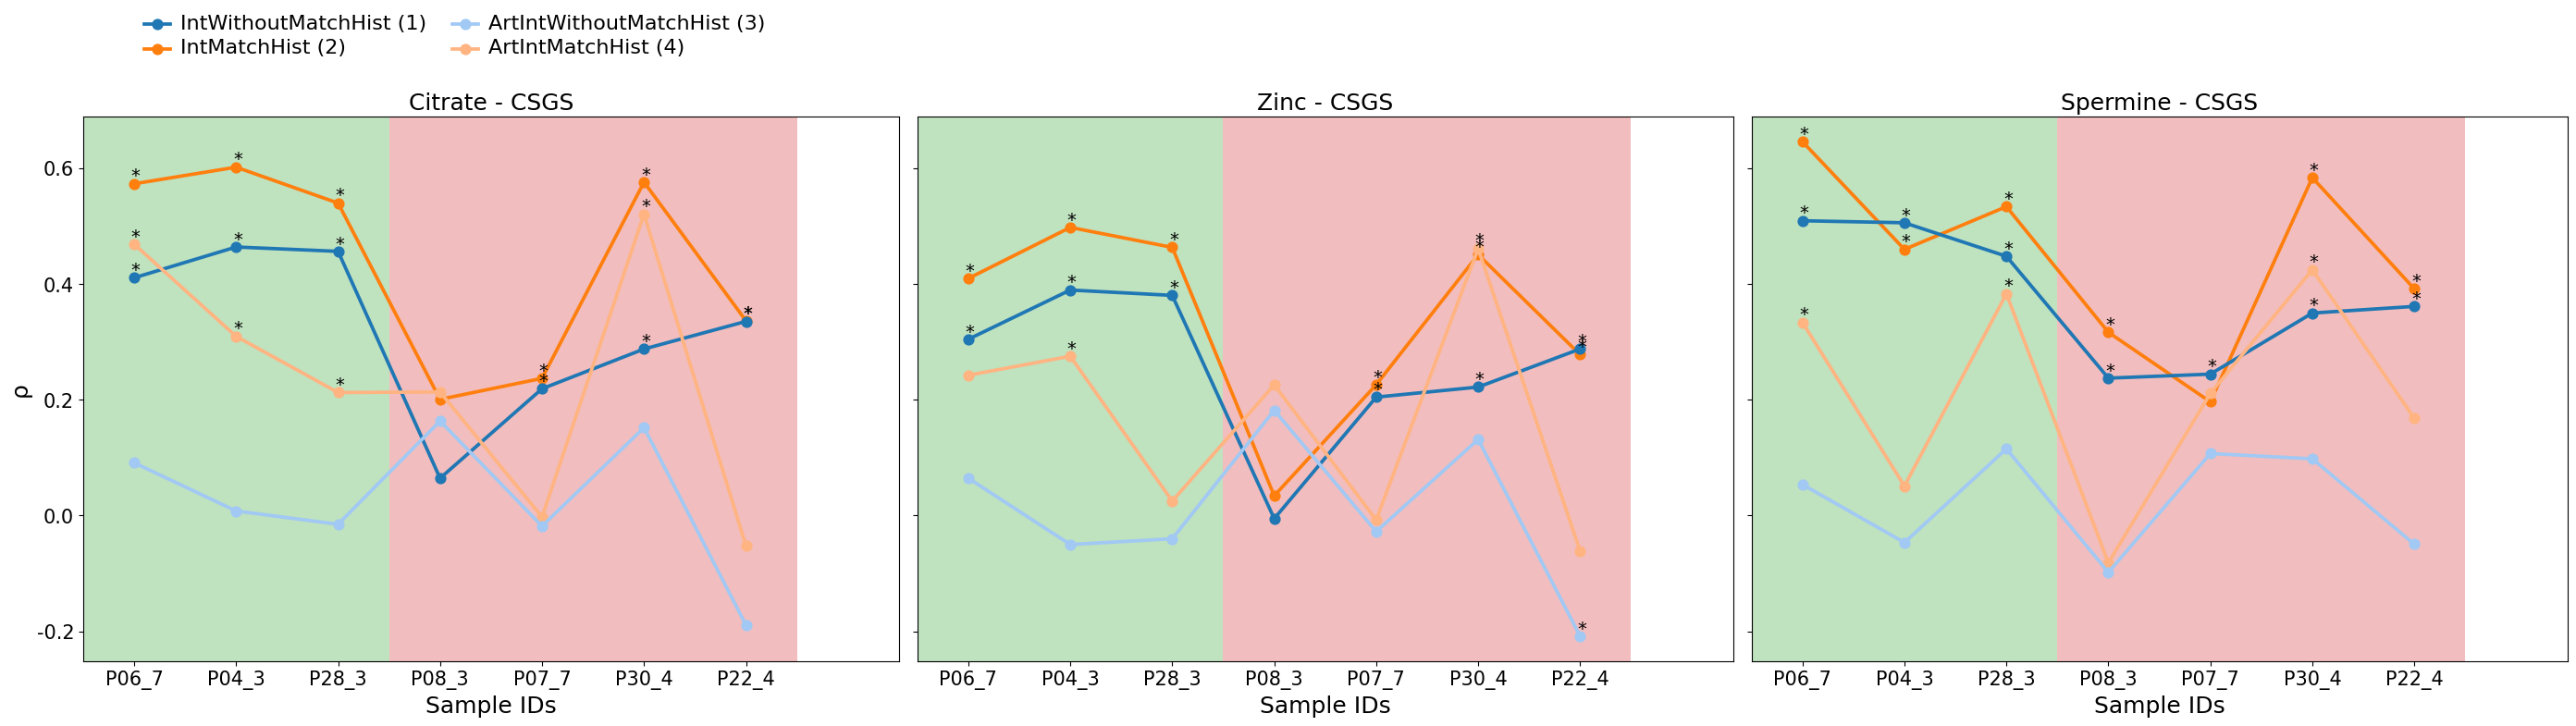

In [80]:
# Plot both images in the same frame
from matplotlib.ticker import FormatStrFormatter

fig, axs = plt.subplots(1, 3, figsize=(28, 8), sharey=True)
fig.subplots_adjust(hspace=0.025, wspace=0.025)

experiment_type_col_name = 'Dataset type'
exp_type1 = 'IntMatchHist'
exp_type2 = 'IntWithoutMatchHist'
exp_type3 = 'ArtIntMatchHist'
exp_type4 = 'ArtIntWithoutMatchHist'
fontsize=18
tick_fontsize=15
xlim_max = 7.5
xlim_min = -.5
all_stats = pd.DataFrame()

core_ids_to_paper_ids = {
    '001_04': 'P06_7',
    '002_01': 'P04_3',
    '003_02': 'P08_3',
    '004_03': 'P07_7',
    '045_03': 'P28_3',
    '047_04': 'P30_4',
    '048_02': 'P22_4'
}

plot_order =['P06_7', 'P04_3', 'P28_3', 'P08_3', 'P07_7', 'P30_4', 'P22_4']

as2c_df = nc_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_cit_core_sp_stats.columns})
as2c_df[experiment_type_col_name] = 'correct_and_matching'
as2w_df = nw_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_cit_core_sp_stats.columns})
as2w_df[experiment_type_col_name] = 'artificial_and_matching'
as1c_df = nc_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_cit_core_sp_stats.columns})
as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
as1w_df = nw_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_cit_core_sp_stats.columns})
as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
as2c_df[experiment_type_col_name] = exp_type1
as2w_df[experiment_type_col_name] = exp_type3
as1c_df[experiment_type_col_name] = exp_type2
as1w_df[experiment_type_col_name] = exp_type4
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['core_id'] = stats_df.index
stats_df['sample_id'] = core_ids_to_paper_ids
# stats_df['sample_id'] = stats_df.index
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)
stats_df['background'] = stats_df.sample_id.apply(lambda x: 'C02' if x.startswith('N') else 'C03')
standard_color = sns.color_palette()
light_color = sns.color_palette('pastel')
experiment_type_color_mapping = {}
# experiment_type_color_mapping['IW'] = standard_color[0]
# experiment_type_color_mapping['AW'] = light_color[0]
# experiment_type_color_mapping['IM'] = standard_color[1] 
# experiment_type_color_mapping['AM'] = light_color[1]
experiment_type_color_mapping[exp_type2] = standard_color[0]
experiment_type_color_mapping[exp_type4] = light_color[0]
experiment_type_color_mapping[exp_type1] = standard_color[1] 
experiment_type_color_mapping[exp_type3] = light_color[1]

# ax = sns.lineplot(x="timepoint", y="signal", hue="event", data=fmri)
# ranges = fmri.groupby('background')['timepoint'].agg(['min', 'max'])
# for i, row in ranges.iterrows():
#     ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=i, alpha=0.3)
 
leg_ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue=experiment_type_col_name, 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs[0],
                   order=plot_order)
leg_ax.set_xlim(xlim_min, xlim_max)
leg_ax.axvspan(xmin=-0.5, xmax=2.5, facecolor='C02', alpha=.3)
leg_ax.axvspan(xmin=2.5, xmax=6.5, facecolor='C03', alpha=.3)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    # sub_df = stats_df.loc[sample_id, :]
    sub_df = stats_df.loc[stats_df.sample_id == sample_id]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        leg_ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
leg_ax.legend([],[], frameon=False)
leg_ax.set_xlabel('Sample IDs', fontsize=fontsize)
leg_ax.set_ylabel('ρ', fontsize=fontsize)
# ax.set_title('Correlation Citrate vs. CSGS', fontsize=fontsize)
leg_ax.set_title('Citrate - CSGS', fontsize=fontsize)
leg_ax.set_xticklabels(leg_ax.get_xticklabels(), size=tick_fontsize)
leg_ax.set_yticklabels(leg_ax.get_yticklabels(), size=tick_fontsize)


stats_df['metabolite'] = 'citrate'
all_stats = pd.concat([all_stats, stats_df])

# Built a plotable dataframe.
as2c_df = nc_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_zinc_core_sp_stats.columns})
as2c_df[experiment_type_col_name] = 'correct_and_matching'
as2w_df = nw_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_zinc_core_sp_stats.columns})
as2w_df[experiment_type_col_name] = 'artificial_and_matching'
as1c_df = nc_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_zinc_core_sp_stats.columns})
as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
as1w_df = nw_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_zinc_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
as2c_df[experiment_type_col_name] = exp_type1
as2w_df[experiment_type_col_name] = exp_type3
as1c_df[experiment_type_col_name] = exp_type2
as1w_df[experiment_type_col_name] = exp_type4
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['core_id'] = stats_df.index
stats_df['sample_id'] = core_ids_to_paper_ids
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue=experiment_type_col_name, 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs[1],
                   order=plot_order)
ax.set_xlim(xlim_min, xlim_max)
ax.axvspan(xmin=-0.5, xmax=2.5, facecolor='C02', alpha=.3)
ax.axvspan(xmin=2.5, xmax=6.5, facecolor='C03', alpha=.3)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    # sub_df = stats_df.loc[sample_id, :]
    sub_df = stats_df.loc[stats_df.sample_id == sample_id]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.set_title('Correlation Zinc vs. CSGS', fontsize=fontsize)
ax.set_title('Zinc - CSGS', fontsize=fontsize)
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.legend([],[], frameon=False)
stats_df['metabolite'] = 'zinc'
all_stats = pd.concat([all_stats, stats_df])
# Built a plotable dataframe.
as2c_df = pc_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_2_spe_core_sp_stats.columns})
as2c_df[experiment_type_col_name] = 'correct_and_matching'
as2w_df = pw_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_2_spe_core_sp_stats.columns})
as2w_df[experiment_type_col_name] = 'artificial_and_matching'
as1c_df = pc_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_1_spe_core_sp_stats.columns})
as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
as1w_df = pw_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_1_spe_core_sp_stats.columns})
as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
as2c_df[experiment_type_col_name] = exp_type1
as2w_df[experiment_type_col_name] = exp_type3
as1c_df[experiment_type_col_name] = exp_type2
as1w_df[experiment_type_col_name] = exp_type4
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['core_id'] = stats_df.index
stats_df['sample_id'] = core_ids_to_paper_ids
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue=experiment_type_col_name, 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs[2],
                   order=plot_order)
ax.set_xlim(xlim_min, xlim_max)
ax.axvspan(xmin=-0.5, xmax=2.5, facecolor='C02', alpha=.3)
ax.axvspan(xmin=2.5, xmax=6.5, facecolor='C03', alpha=.3)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    # sub_df = stats_df.loc[sample_id, :]
    sub_df = stats_df.loc[stats_df.sample_id == sample_id]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.set_ylabel('Spearman correlation', fontsize=12);
# ax.set_title('Correlation Spermine vs. CSGS', fontsize=fontsize)
ax.set_title('Spermine - CSGS', fontsize=fontsize)
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
stats_df['metabolite'] = 'spermine'
all_stats = pd.concat([all_stats, stats_df])
legend_handles, legend_labels = leg_ax.get_legend_handles_labels()
legend_handles_new_order = [legend_handles[1], legend_handles[0], legend_handles[3], legend_handles[2]]
legend_labels_new_order = [legend_labels[1] + ' (1)', legend_labels[0] + ' (2)', legend_labels[3] + ' (3)', legend_labels[2] + ' (4)']
leg_ax.legend(handles=legend_handles_new_order, labels=legend_labels_new_order)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(
    leg_ax, "center right",
    bbox_to_anchor=(.85, 1.15), ncol=2, title=None, frameon=False,
)
plt.setp(leg_ax.get_legend().get_texts(), fontsize=16) # for legend text
plt.setp(leg_ax.get_legend().get_title(), fontsize=14) # for legend title
ax.legend([],[], frameon=False)
# sns.move_legend(ax, "lower right")
# plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_spermine.png')
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/spearman_correlations_citsper_citrate_zinc_spermine_with_color.png', transparent=True)

In [82]:
# Plot each part separately.


# Plot both images in the same frame
from matplotlib.ticker import FormatStrFormatter

# fig, axs = plt.subplots(1, 3, figsize=(28, 8), sharey=True)
# fig.subplots_adjust(hspace=0.025, wspace=0.025)

fig, axs = plt.subplots(1, 2, figsize=(30, 11))

experiment_type_col_name = 'Dataset type'
exp_type1 = 'IntMatchHist'
exp_type2 = 'IntWithoutMatchHist'
exp_type3 = 'ArtIntMatchHist'
exp_type4 = 'ArtIntWithoutMatchHist'
fontsize=34
tick_fontsize=24
xlim_max = 7.5
xlim_min = -.5
all_stats = pd.DataFrame()

core_ids_to_paper_ids = {
    '001_04': 'P06_7',
    '002_01': 'P04_3',
    '003_02': 'P08_3',
    '004_03': 'P07_7',
    '045_03': 'P28_3',
    '047_04': 'P30_4',
    '048_02': 'P22_4'
}

plot_order =['P06_7', 'P04_3', 'P28_3', 'P08_3', 'P07_7', 'P30_4', 'P22_4']

as2c_df = nc_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_cit_core_sp_stats.columns})
as2c_df[experiment_type_col_name] = 'correct_and_matching'
as2w_df = nw_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_cit_core_sp_stats.columns})
as2w_df[experiment_type_col_name] = 'artificial_and_matching'
as1c_df = nc_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_cit_core_sp_stats.columns})
as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
as1w_df = nw_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_cit_core_sp_stats.columns})
as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
as2c_df[experiment_type_col_name] = exp_type1
as2w_df[experiment_type_col_name] = exp_type3
as1c_df[experiment_type_col_name] = exp_type2
as1w_df[experiment_type_col_name] = exp_type4
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['core_id'] = stats_df.index
stats_df['sample_id'] = core_ids_to_paper_ids
# stats_df['sample_id'] = stats_df.index
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)
stats_df['background'] = stats_df.sample_id.apply(lambda x: 'C02' if x.startswith('N') else 'C03')
standard_color = sns.color_palette()
light_color = sns.color_palette('pastel')
experiment_type_color_mapping = {}
# experiment_type_color_mapping['IW'] = standard_color[0]
# experiment_type_color_mapping['AW'] = light_color[0]
# experiment_type_color_mapping['IM'] = standard_color[1] 
# experiment_type_color_mapping['AM'] = light_color[1]
experiment_type_color_mapping[exp_type2] = standard_color[0]
experiment_type_color_mapping[exp_type4] = light_color[0]
experiment_type_color_mapping[exp_type1] = standard_color[1] 
experiment_type_color_mapping[exp_type3] = light_color[1]

# ax = sns.lineplot(x="timepoint", y="signal", hue="event", data=fmri)
# ranges = fmri.groupby('background')['timepoint'].agg(['min', 'max'])
# for i, row in ranges.iterrows():
#     ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=i, alpha=0.3)
 
leg_ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue=experiment_type_col_name, 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs[0],
                   order=plot_order)
leg_ax.set_xlim(xlim_min, xlim_max)
# leg_ax.axvspan(xmin=-0.5, xmax=2.5, facecolor='C02', alpha=.3)
# leg_ax.axvspan(xmin=2.5, xmax=6.5, facecolor='C03', alpha=.3)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    # sub_df = stats_df.loc[sample_id, :]
    sub_df = stats_df.loc[stats_df.sample_id == sample_id]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        leg_ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
leg_ax.legend([],[], frameon=False)
leg_ax.set_xlabel('Sample IDs', fontsize=fontsize)
leg_ax.set_ylabel('ρ', fontsize=fontsize)
# ax.set_title('Correlation Citrate vs. CSGS', fontsize=fontsize)
leg_ax.set_title('Citrate - CSGS', fontsize=fontsize)
leg_ax.set_xticklabels(leg_ax.get_xticklabels(), size=tick_fontsize)
leg_ax.set_yticklabels(leg_ax.get_yticklabels(), size=tick_fontsize)

legend_handles, legend_labels = leg_ax.get_legend_handles_labels()
legend_handles_new_order = [legend_handles[1], legend_handles[0], legend_handles[3], legend_handles[2]]
legend_labels_new_order = [legend_labels[1] + ' (1)', legend_labels[0] + ' (2)', legend_labels[3] + ' (3)', legend_labels[2] + ' (4)']
leg_ax.legend(handles=legend_handles_new_order, labels=legend_labels_new_order)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(
    leg_ax, "center right",
    bbox_to_anchor=(.85, 1.15), ncol=2, title=None, frameon=False,
)
plt.setp(leg_ax.get_legend().get_texts(), fontsize=24) # for legend text
plt.setp(leg_ax.get_legend().get_title(), fontsize=24) # for legend title
ax.legend([],[], frameon=False)
# plt.savefig('../../images/citsper_citrate_analysis/spearman_correlations_citsper_citrate_zinc_spermine_with_color.png', transparent=True)
# fig.tight_layout()
# plt.savefig('../../images/citsper_citrate_analysis/spearman_correlations_citsper_citrate_with_color.png', transparent=True)
# plt.close()
# fig, axs = plt.subplots(1, 1, figsize=(13, 8))

stats_df['metabolite'] = 'citrate'
all_stats = pd.concat([all_stats, stats_df])

# Built a plotable dataframe.
as2c_df = nc_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_zinc_core_sp_stats.columns})
as2c_df[experiment_type_col_name] = 'correct_and_matching'
as2w_df = nw_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_zinc_core_sp_stats.columns})
as2w_df[experiment_type_col_name] = 'artificial_and_matching'
as1c_df = nc_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_zinc_core_sp_stats.columns})
as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
as1w_df = nw_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_zinc_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
as2c_df[experiment_type_col_name] = exp_type1
as2w_df[experiment_type_col_name] = exp_type3
as1c_df[experiment_type_col_name] = exp_type2
as1w_df[experiment_type_col_name] = exp_type4
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['core_id'] = stats_df.index
stats_df['sample_id'] = core_ids_to_paper_ids
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue=experiment_type_col_name, 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs[1],
                   order=plot_order)
ax.set_xlim(xlim_min, xlim_max)
# ax.axvspan(xmin=-0.5, xmax=2.5, facecolor='C02', alpha=.3)
# ax.axvspan(xmin=2.5, xmax=6.5, facecolor='C03', alpha=.3)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    # sub_df = stats_df.loc[sample_id, :]
    sub_df = stats_df.loc[stats_df.sample_id == sample_id]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.set_title('Correlation Zinc vs. CSGS', fontsize=fontsize)
ax.set_title('Zinc - CSGS', fontsize=fontsize)
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('ρ', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
ax.legend([],[], frameon=False)


fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/spearman_correlations_citsper_with_citrate_zinc_color.png', transparent=True)
plt.close()
fig, axs = plt.subplots(1, 1, figsize=(13, 8))

stats_df['metabolite'] = 'zinc'
all_stats = pd.concat([all_stats, stats_df])
# Built a plotable dataframe.
as2c_df = pc_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_2_spe_core_sp_stats.columns})
as2c_df[experiment_type_col_name] = 'correct_and_matching'
as2w_df = pw_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_2_spe_core_sp_stats.columns})
as2w_df[experiment_type_col_name] = 'artificial_and_matching'
as1c_df = pc_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_1_spe_core_sp_stats.columns})
as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
as1w_df = pw_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_1_spe_core_sp_stats.columns})
as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
as2c_df[experiment_type_col_name] = exp_type1
as2w_df[experiment_type_col_name] = exp_type3
as1c_df[experiment_type_col_name] = exp_type2
as1w_df[experiment_type_col_name] = exp_type4
stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
stats_df['core_id'] = stats_df.index
stats_df['sample_id'] = core_ids_to_paper_ids
stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

ax = sns.pointplot(stats_df, 
                   y='Spearman correlation', 
                   x='sample_id', 
                   hue=experiment_type_col_name, 
                   linestyles='-', 
                   palette=experiment_type_color_mapping,
                   ax=axs,
                   order=plot_order)
ax.set_xlim(xlim_min, xlim_max)
# ax.axvspan(xmin=-0.5, xmax=2.5, facecolor='C02', alpha=.3)
# ax.axvspan(xmin=2.5, xmax=6.5, facecolor='C03', alpha=.3)
sample_ids = stats_df.index.unique()
sample_ids = plot_order
for idx, sample_id in enumerate(sample_ids):
    # sub_df = stats_df.loc[sample_id, :]
    sub_df = stats_df.loc[stats_df.sample_id == sample_id]
    for row_idx, row in sub_df.iterrows():
        y = row['Spearman correlation']
        p = row['pvalue']
        if p > 0.0001:
            continue
        ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.set_ylabel('Spearman correlation', fontsize=12);
# ax.set_title('Correlation Spermine vs. CSGS', fontsize=fontsize)
ax.set_title('Spermine - CSGS', fontsize=fontsize)
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('ρ', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.savefig('../../images/citsper_citrate_analysis/spearman_correlations_citsper_with_spermine_color.png', transparent=True)
# plt.close()
# fig, axs = plt.subplots(1, 1, figsize=(10, 10), sharey=True)

stats_df['metabolite'] = 'spermine'
all_stats = pd.concat([all_stats, stats_df])
# legend_handles, legend_labels = leg_ax.get_legend_handles_labels()
# legend_handles_new_order = [legend_handles[1], legend_handles[0], legend_handles[3], legend_handles[2]]
# legend_labels_new_order = [legend_labels[1] + ' (1)', legend_labels[0] + ' (2)', legend_labels[3] + ' (3)', legend_labels[2] + ' (4)']
# leg_ax.legend(handles=legend_handles_new_order, labels=legend_labels_new_order)
# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# sns.move_legend(
#     leg_ax, "center right",
#     bbox_to_anchor=(.85, 1.15), ncol=2, title=None, frameon=False,
# )
# plt.setp(leg_ax.get_legend().get_texts(), fontsize=16) # for legend text
# plt.setp(leg_ax.get_legend().get_title(), fontsize=14) # for legend title
ax.legend([],[], frameon=False)
# sns.move_legend(ax, "lower right")
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/spearman_correlations_citsper_with_spermine_color.png', transparent=True)
plt.close()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [30]:
metadata_df[metadata_df.core_name.isin(['001_04', '002_01', '003_02', '004_03', '045_03', '047_04', '048_02'])]

Sample ID_x adjusted_core_type  Round nr Square (a-d) on slide    type  \
3    PS D012.c8                  n        47                     d  Normal   
6    PS D008.c6                  n        45                     c  Normal   
9    PS C003.c8                  n        48                     b  Normal   
16  PS A004.c10                  n         2                     a  Normal   
23   PS A006.c7                  n         1                     d  Normal   
25  PS A008.c12                  n         3                     b  Normal   
30   PS A007.c9                  n         4                     c  Normal   

    recurrence patient_id core_name st_identifier_y correct_st_identifier  \
3   recurrence    PS_D012    047_04    V10A20_007_4          V10A20_007_D   
6      control    PS_D008    045_03    V10A20_008_3          V10A20_008_C   
9   recurrence    PS_C003    048_02    V10A20_009_2          V10A20_009_B   
16     control    PS_A004    002_01    V19S23_002_1          V19S23_002_A   
23     control    PS_A006    001_04    V19S23_106_4          V19S23_106_D   
25  recurrence    PS_A008    003_02    V19S23_107_2          V19S23_107_B   
30  recurrence    PS_A007    004_03    V19S23_108_3          V19S23_108_C   

   fixed_sample_id  Sample ID_y New_samp Patient New_patient  Samp_nr  slide  \
3       PS_D012_c8   PS_D012_c8    P30_4    D012         P30        4     47   
6       PS_D008_c6   PS_D008_c6    P28_3    D008         P28        3     45   
9       PS_C003_c8   PS_C003_c8    P22_4    C003         P22        4     48   
16     PS_A004_c10  PS_A004_c10     P4_3    A004          P4        3      2   
23      PS_A006_c7   PS_A006_c7     P6_7    A006          P6        7      1   
25     PS_A008_c12  PS_A008_c12     P8_3    A008          P8        3      3   
30      PS_A007_c9   PS_A007_c9     P7_7    A007          P7        7      4   

   position new_sample_id  
3         d         P30_4  
6         c         P28_3  
9         b         P22_4  
16        a         P04_3  
23        d         P06_7  
25        b         P08_3  
30        c         P07_7

In [31]:
# # Plot both images in the same frame
# from matplotlib.ticker import FormatStrFormatter

# fig, axs = plt.subplots(1, 3, figsize=(23, 6), sharey=True)
# fig.subplots_adjust(hspace=0.025, wspace=0.025)

# experiment_type_col_name = 'Dataset'
# fontsize=18
# tick_fontsize=15
# all_stats = pd.DataFrame()

# core_ids_to_paper_ids = {
#     '001_04': 'P06_7',
#     '002_01': 'P04_3',
#     '003_02': 'P08_3',
#     '004_03': 'P07_7',
#     '045_03': 'P28_3',
#     '047_04': 'P30_4',
#     '048_02': 'P22_4'
# }

# plot_order =['P06_7', 'P04_3', 'P08_3', 'P07_7', 'P28_3', 'P30_4', 'P22_4']

# as2c_df = nc_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_cit_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'correct_and_matching'
# as2w_df = nw_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_cit_core_sp_stats.columns})
# as2w_df[experiment_type_col_name] = 'artificial_and_matching'
# as1c_df = nc_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_cit_core_sp_stats.columns})
# as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
# as1w_df = nw_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_cit_core_sp_stats.columns})
# as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['core_id'] = stats_df.index
# stats_df['sample_id'] = core_ids_to_paper_ids
# # stats_df['sample_id'] = stats_df.index
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)
# stats_df['background'] = stats_df['sample_id'].apply(lambda x: 'C02' if x.startswith('N') else 'C03')
# standard_color = sns.color_palette()
# light_color = sns.color_palette('pastel')
# experiment_type_color_mapping = {}
# # experiment_type_color_mapping['correct_and_non_matching'] = standard_color[0]
# # experiment_type_color_mapping['artificial_and_non_matching'] = light_color[0]
# # experiment_type_color_mapping['correct_and_matching'] = standard_color[1] 
# # experiment_type_color_mapping['artificial_and_matching'] = light_color[1]
# experiment_type_color_mapping['IW'] = standard_color[0]
# experiment_type_color_mapping['AW'] = light_color[0]
# experiment_type_color_mapping['IM'] = standard_color[1] 
# experiment_type_color_mapping['AM'] = light_color[1]

# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue=experiment_type_col_name, 
#                    linestyles='-', 
#                    palette=experiment_type_color_mapping,
#                    ax=axs[0],
#                    order=plot_order)
# sample_ids = stats_df.index.unique()
# sample_ids = plot_order
# for idx, sample_id in enumerate(sample_ids):
#     # sub_df = stats_df.loc[sample_id, :]
#     sub_df = stats_df.loc[stats_df.sample_id == sample_id]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.legend([],[], frameon=False)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
# ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
# ax.set_ylabel('Spearman correlation', fontsize=fontsize)
# ax.set_title('Correlation Citrate vs. CSGS', fontsize=fontsize)

# stats_df['metabolite'] = 'citrate'
# all_stats = pd.concat([all_stats, stats_df])

# # Built a plotable dataframe.
# as2c_df = nc_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_zinc_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'correct_and_matching'
# as2w_df = nw_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_zinc_core_sp_stats.columns})
# as2w_df[experiment_type_col_name] = 'artificial_and_matching'
# as1c_df = nc_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_zinc_core_sp_stats.columns})
# as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
# as1w_df = nw_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_zinc_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['core_id'] = stats_df.index
# stats_df['sample_id'] = core_ids_to_paper_ids
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue=experiment_type_col_name, 
#                    linestyles='-', 
#                    palette=experiment_type_color_mapping,
#                    ax=axs[1],
#                    order=plot_order)
# sample_ids = stats_df.index.unique()
# sample_ids = plot_order
# for idx, sample_id in enumerate(sample_ids):
#     # sub_df = stats_df.loc[sample_id, :]
#     sub_df = stats_df.loc[stats_df.sample_id == sample_id]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.set_title('Correlation Zinc vs. CSGS', fontsize=fontsize)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
# ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# ax.legend([],[], frameon=False)
# stats_df['metabolite'] = 'zinc'
# all_stats = pd.concat([all_stats, stats_df])
# # Built a plotable dataframe.
# as2c_df = pc_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_2_spe_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'correct_and_matching'
# as2w_df = pw_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_2_spe_core_sp_stats.columns})
# as2w_df[experiment_type_col_name] = 'artificial_and_matching'
# as1c_df = pc_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_1_spe_core_sp_stats.columns})
# as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
# as1w_df = pw_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_1_spe_core_sp_stats.columns})
# as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
# as2c_df[experiment_type_col_name] = 'IM'
# as2w_df[experiment_type_col_name] = 'AM'
# as1c_df[experiment_type_col_name] = 'IW'
# as1w_df[experiment_type_col_name] = 'AW'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['core_id'] = stats_df.index
# stats_df['sample_id'] = core_ids_to_paper_ids
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue=experiment_type_col_name, 
#                    linestyles='-', 
#                    palette=experiment_type_color_mapping,
#                    ax=axs[2],
#                    order=plot_order)
# sample_ids = stats_df.index.unique()
# sample_ids = plot_order
# for idx, sample_id in enumerate(sample_ids):
#     # sub_df = stats_df.loc[sample_id, :]
#     sub_df = stats_df.loc[stats_df.sample_id == sample_id]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# # ax.set_ylabel('Spearman correlation', fontsize=12);
# ax.set_title('Correlation Spermine vs. CSGS', fontsize=fontsize)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
# ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# # ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.setp(ax.get_legend().get_texts(), fontsize=16) # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize=16) # for legend title
# stats_df['metabolite'] = 'spermine'
# all_stats = pd.concat([all_stats, stats_df])
# # sns.move_legend(ax, "lower right")
# # plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_spermine.png')
# # plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_citrate_zinc_spermine.png', transparent=True)

In [32]:

# # Plot both images in the same frame
# from matplotlib.ticker import FormatStrFormatter

# fig, axs = plt.subplots(1, 3, figsize=(23, 6), sharey=True)
# fig.subplots_adjust(hspace=0.025, wspace=0.025)

# experiment_type_col_name = 'Experiment type'
# fontsize=18
# tick_fontsize=15
# all_stats = pd.DataFrame()

# # core_ids_to_paper_ids = {
# #     '001_04': 'N1',
# #     '002_01': 'N2',
# #     '003_02': 'C3',
# #     '004_03': 'C4',
# #     '045_03': 'N5',
# #     '047_04': 'C6',
# #     '048_02': 'C7'
# # }

# # # plot_order =['N1', 'N2', 'N5', 'C3', 'C4', 'C6', 'C7']
# # plot_order =['N1', 'N2', 'C3', 'C4', 'N5', 'C6', 'C7']
# core_ids_to_paper_ids = {
#     '001_04': 'P06_7',
#     '002_01': 'P04_3',
#     '003_02': 'P08_3',
#     '004_03': 'P07_7',
#     '045_03': 'P28_3',
#     '047_04': 'P30_4',
#     '048_02': 'P22_4'
# }

# plot_order =['P06_7', 'P04_3', 'P08_3', 'P07_7', 'P28_3', 'P30_4', 'P22_4']

# as2c_df = nc_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_cit_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'correct_and_matching'
# as2w_df = nw_2_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_cit_core_sp_stats.columns})
# as2w_df[experiment_type_col_name] = 'artificial_and_matching'
# as1c_df = nc_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_cit_core_sp_stats.columns})
# as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
# as1w_df = nw_1_cit_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_cit_core_sp_stats.columns})
# as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
# as2c_df[experiment_type_col_name] = 'ECM'
# as2w_df[experiment_type_col_name] = 'EAM'
# as1c_df[experiment_type_col_name] = 'ECW'
# as1w_df[experiment_type_col_name] = 'EAW'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['core_id'] = stats_df.index
# stats_df['sample_id'] = core_ids_to_paper_ids
# # stats_df['sample_id'] = stats_df.index
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)
# stats_df['background'] = stats_df['sample_id'].apply(lambda x: 'C02' if x.startswith('N') else 'C03')
# standard_color = sns.color_palette()
# light_color = sns.color_palette('pastel')
# experiment_type_color_mapping = {}
# # experiment_type_color_mapping['correct_and_non_matching'] = standard_color[0]
# # experiment_type_color_mapping['artificial_and_non_matching'] = light_color[0]
# # experiment_type_color_mapping['correct_and_matching'] = standard_color[1] 
# # experiment_type_color_mapping['artificial_and_matching'] = light_color[1]
# experiment_type_color_mapping['ECW'] = standard_color[0]
# experiment_type_color_mapping['EAW'] = light_color[0]
# experiment_type_color_mapping['ECM'] = standard_color[1] 
# experiment_type_color_mapping['EAM'] = light_color[1]

# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue=experiment_type_col_name, 
#                    linestyles='-', 
#                    palette=experiment_type_color_mapping,
#                    ax=axs[0],
#                    order=plot_order)
# sample_ids = stats_df.index.unique()
# sample_ids = plot_order
# for idx, sample_id in enumerate(sample_ids):
#     # sub_df = stats_df.loc[sample_id, :]
#     sub_df = stats_df.loc[stats_df.sample_id == sample_id]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.legend([],[], frameon=False)
# ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
# ax.set_ylabel('Spearman correlation', fontsize=fontsize)
# ax.set_title('Correlation Citrate vs. CSGS', fontsize=fontsize)

# stats_df['metabolite'] = 'citrate'
# all_stats = pd.concat([all_stats, stats_df])

# # Built a plotable dataframe.
# as2c_df = nc_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_2_zinc_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'correct_and_matching'
# as2w_df = nw_2_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_2_zinc_core_sp_stats.columns})
# as2w_df[experiment_type_col_name] = 'artificial_and_matching'
# as1c_df = nc_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nc_1_zinc_core_sp_stats.columns})
# as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
# as1w_df = nw_1_zinc_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in nw_1_zinc_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'ECM'
# as2w_df[experiment_type_col_name] = 'EAM'
# as1c_df[experiment_type_col_name] = 'ECW'
# as1w_df[experiment_type_col_name] = 'EAW'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['core_id'] = stats_df.index
# stats_df['sample_id'] = core_ids_to_paper_ids
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue=experiment_type_col_name, 
#                    linestyles='-', 
#                    palette=experiment_type_color_mapping,
#                    ax=axs[1],
#                    order=plot_order)
# sample_ids = stats_df.index.unique()
# sample_ids = plot_order
# for idx, sample_id in enumerate(sample_ids):
#     # sub_df = stats_df.loc[sample_id, :]
#     sub_df = stats_df.loc[stats_df.sample_id == sample_id]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# ax.set_title('Correlation Zinc vs. CSGS', fontsize=fontsize)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
# ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# ax.legend([],[], frameon=False)
# stats_df['metabolite'] = 'zinc'
# all_stats = pd.concat([all_stats, stats_df])
# # Built a plotable dataframe.
# as2c_df = pc_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_2_spe_core_sp_stats.columns})
# as2c_df[experiment_type_col_name] = 'correct_and_matching'
# as2w_df = pw_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_2_spe_core_sp_stats.columns})
# as2w_df[experiment_type_col_name] = 'artificial_and_matching'
# as1c_df = pc_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_1_spe_core_sp_stats.columns})
# as1c_df[experiment_type_col_name] = 'correct_and_non_matching'
# as1w_df = pw_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_1_spe_core_sp_stats.columns})
# as1w_df[experiment_type_col_name] = 'artificial_and_non_matching'
# as2c_df[experiment_type_col_name] = 'ECM'
# as2w_df[experiment_type_col_name] = 'EAM'
# as1c_df[experiment_type_col_name] = 'ECW'
# as1w_df[experiment_type_col_name] = 'EAW'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['core_id'] = stats_df.index
# stats_df['sample_id'] = core_ids_to_paper_ids
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)

# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue=experiment_type_col_name, 
#                    linestyles='-', 
#                    palette=experiment_type_color_mapping,
#                    ax=axs[2],
#                    order=plot_order)
# sample_ids = stats_df.index.unique()
# sample_ids = plot_order
# for idx, sample_id in enumerate(sample_ids):
#     # sub_df = stats_df.loc[sample_id, :]
#     sub_df = stats_df.loc[stats_df.sample_id == sample_id]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center', fontsize=14)
# # ax.set_ylabel('Spearman correlation', fontsize=12);
# ax.set_title('Correlation Spermine vs. CSGS', fontsize=fontsize)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
# # ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
# # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.setp(ax.get_legend().get_texts(), fontsize=16) # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize=16) # for legend title
# stats_df['metabolite'] = 'spermine'
# all_stats = pd.concat([all_stats, stats_df])
# # sns.move_legend(ax, "lower right")
# # plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_spermine.png')
# # plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_citrate_zinc_spermine.png', transparent=True)

In [33]:
stats_df['background_color'] = stats_df['sample_id'].apply(lambda x: 'C')

In [34]:
all_stats.to_csv('correlations_csgs_czs.csv')

In [35]:
# # Built a plotable dataframe.
# as2c_df = pc_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_2_spe_core_sp_stats.columns})
# as2c_df['experiment_type'] = 'correct_and_matching'
# as2w_df = pw_2_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_2_spe_core_sp_stats.columns})
# as2w_df['experiment_type'] = 'artificial_and_matching'
# as1c_df = pc_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pc_1_spe_core_sp_stats.columns})
# as1c_df['experiment_type'] = 'correct_and_non_matching'
# as1w_df = pw_1_spe_core_sp_stats[['statistic', 'pvalue', 'n']].rename(columns={x: x.split('_')[0] for x in pw_1_spe_core_sp_stats.columns})
# as1w_df['experiment_type'] = 'artificial_and_non_matching'
# stats_df = pd.concat([as2c_df, as1c_df, as2w_df, as1w_df])
# stats_df['sample_id'] = stats_df.index
# stats_df.rename(columns={'statistic': 'Spearman correlation'}, inplace=True)
# standard_color = sns.color_palette()
# light_color = sns.color_palette('pastel')
# experiment_type_color_mapping = {}
# experiment_type_color_mapping['correct_and_non_matching'] = standard_color[0]
# experiment_type_color_mapping['artificial_and_non_matching'] = light_color[0]
# experiment_type_color_mapping['correct_and_matching'] = standard_color[1] 
# experiment_type_color_mapping['artificial_and_matching'] = light_color[1]

# _, axs = plt.subplots(1, 1, figsize=(12, 8))
# # sns.stripplot(data=stats_df, 
# #               y='statistic',
# #               x='sample_id',
# #               hue='experiment_type',
# #               ax=axs)
# # sns.set(font_scale=1)
# ax = sns.pointplot(stats_df, 
#                    y='Spearman correlation', 
#                    x='sample_id', 
#                    hue='experiment_type', 
#                    linestyles='-', 
#                 #    palette='husl',
#                    palette=experiment_type_color_mapping,
#                    ax=axs)
# sample_ids = stats_df.index.unique()
# for idx, sample_id in enumerate(sample_ids):
#     sub_df = stats_df.loc[sample_id, :]
#     for row_idx, row in sub_df.iterrows():
#         y = row['Spearman correlation']
#         p = row['pvalue']
#         if p > 0.0001:
#             continue
#         ax.annotate('*', xy=(idx+.015, y+.005), horizontalalignment='center')
# # ax.set_ylabel('Spearman correlation', fontsize=12);
# plt.savefig('images/citsper_citrate_analysis/spearman_correlations_citsper_spermine.png')

In [36]:
# # Compute fishers r to z transformation
# index = '001_04'
# metabolite = 'citrate'
# all_stats.loc[index, ]
# # all_stats#.loc[index, all_stats.metabolite == metabolite]
# r1 = 0.581949
# r2 = 0.251001
# n1 = 322
# n2 = 551
# r1_ = 0.5*np.log((1 + r1)/(1 - r1))
# r2_ = 0.5*np.log((1 + r2)/(1 - r2))
# S = np.sqrt(1/(n1-3) + 1/(n2-3))
# z = (r1_ - r2_)/S

# z, r1_, r2_, S

In [37]:
all_stats['Experiment type'] = all_stats['Dataset type']

In [38]:
all_stats.to_csv('all_stats.csv')

Compute correlations in R script "all_stats_analysis.R"

In [39]:
fisher_df = pd.read_csv('fisher_correlations.csv', index_col=0)
fisher_df

sample_id metabolite                  scrExp                  dstExp  \
1       P06_7    citrate            IntMatchHist            IntMatchHist   
2       P06_7    citrate            IntMatchHist     IntWithoutMatchHist   
3       P06_7    citrate            IntMatchHist         ArtIntMatchHist   
4       P06_7    citrate            IntMatchHist  ArtIntWithoutMatchHist   
5       P06_7    citrate     IntWithoutMatchHist            IntMatchHist   
..        ...        ...                     ...                     ...   
332     P22_4   spermine         ArtIntMatchHist  ArtIntWithoutMatchHist   
333     P22_4   spermine  ArtIntWithoutMatchHist            IntMatchHist   
334     P22_4   spermine  ArtIntWithoutMatchHist     IntWithoutMatchHist   
335     P22_4   spermine  ArtIntWithoutMatchHist         ArtIntMatchHist   
336     P22_4   spermine  ArtIntWithoutMatchHist  ArtIntWithoutMatchHist   

     statistic distribution        pvalue  
1     0.000000            z  5.000000e-01  
2     3.170316            z  9.992386e-01  
3     1.674629            z  9.529964e-01  
4     7.910275            z  1.000000e+00  
5    -3.170316            z  7.613651e-04  
..         ...          ...           ...  
332   2.427200            z  9.923921e-01  
333  -5.927540            z  1.537529e-09  
334  -5.836512            z  2.665252e-09  
335  -2.427200            z  7.607941e-03  
336   0.000000            z  5.000000e-01  

[336 rows x 7 columns]

In [40]:
from os.path import join

In [41]:
fisher_df

sample_id metabolite                  scrExp                  dstExp  \
1       P06_7    citrate            IntMatchHist            IntMatchHist   
2       P06_7    citrate            IntMatchHist     IntWithoutMatchHist   
3       P06_7    citrate            IntMatchHist         ArtIntMatchHist   
4       P06_7    citrate            IntMatchHist  ArtIntWithoutMatchHist   
5       P06_7    citrate     IntWithoutMatchHist            IntMatchHist   
..        ...        ...                     ...                     ...   
332     P22_4   spermine         ArtIntMatchHist  ArtIntWithoutMatchHist   
333     P22_4   spermine  ArtIntWithoutMatchHist            IntMatchHist   
334     P22_4   spermine  ArtIntWithoutMatchHist     IntWithoutMatchHist   
335     P22_4   spermine  ArtIntWithoutMatchHist         ArtIntMatchHist   
336     P22_4   spermine  ArtIntWithoutMatchHist  ArtIntWithoutMatchHist   

     statistic distribution        pvalue  
1     0.000000            z  5.000000e-01  
2     3.170316            z  9.992386e-01  
3     1.674629            z  9.529964e-01  
4     7.910275            z  1.000000e+00  
5    -3.170316            z  7.613651e-04  
..         ...          ...           ...  
332   2.427200            z  9.923921e-01  
333  -5.927540            z  1.537529e-09  
334  -5.836512            z  2.665252e-09  
335  -2.427200            z  7.607941e-03  
336   0.000000            z  5.000000e-01  

[336 rows x 7 columns]

In [42]:
def get_corr_df(df):
    exp_types = ['DCM', 'DCW', 'DAM', 'DAW']
    m = np.zeros((len(exp_types), len(exp_types)))
    for i, e1 in enumerate(exp_types):
        for j, e2 in enumerate(exp_types):
            # if e1 == e2:
            #     m[i,j] = 1
            row = sub_f_df[(df.scrExp == e1) & (df.dstExp == e2)]
            if row.shape[0] == 0:
                continue
            val = row.pvalue
            m[i,j] = val
    corr_df = pd.DataFrame(m, columns=exp_types, index=exp_types)
    return corr_df

short_to_long_dtype = {
    'IM': 'IntMatchHist',
    'IW': 'IntWithoutMatchHist',
    'AM': 'ArtIntMatchHist',
    'AW': 'ArtIntWithoutMatchHist'
}

# fisher_df['src_dtype'] = fisher_df.scrExp.apply(lambda x: short_to_long_dtype[x])
# fisher_df['dst_dtype'] = fisher_df.dstExp.apply(lambda x: short_to_long_dtype[x])

# sample_id = 'P06_7'
# metabolite = 'citrate'
for sample_id in fisher_df.sample_id.unique():
    for metabolite in fisher_df.metabolite.unique():
        print(sample_id, metabolite)
        sub_f_df = fisher_df[(fisher_df.sample_id == sample_id) & (fisher_df.metabolite == metabolite)]
        corr_df = get_corr_df(sub_f_df)
        mask = np.triu(np.ones_like(corr_df))
        path = join(f'../../images/citsper_citrate_analysis/heatmaps/{sample_id}_{metabolite}.png')
        _, axs = plt.subplots(1,1,figsize=(8,8))
        ax = sns.heatmap(corr_df, mask=mask, ax=axs)
        ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=22)
        ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=22)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=22)
        plt.savefig(path, transparent=True)
        plt.close()

P06_7 citrate
P06_7 zinc
P06_7 spermine
P04_3 citrate
P04_3 zinc
P04_3 spermine
P08_3 citrate
P08_3 zinc
P08_3 spermine
P07_7 citrate
P07_7 zinc
P07_7 spermine
P28_3 citrate
P28_3 zinc
P28_3 spermine
P30_4 citrate
P30_4 zinc
P30_4 spermine
P22_4 citrate
P22_4 zinc
P22_4 spermine


Experient: Tissue or non tissue matching

In [43]:
all_stats

Spearman correlation        pvalue    n            Dataset type  \
001_04              0.572604  1.052932e-33  371            IntMatchHist   
002_01              0.601282  8.018855e-39  381            IntMatchHist   
003_02              0.200403  5.318925e-03  192            IntMatchHist   
004_03              0.236663  4.302982e-06  369            IntMatchHist   
045_03              0.539220  2.762129e-42  543            IntMatchHist   
...                      ...           ...  ...                     ...   
003_02             -0.098288  5.305228e-02  388  ArtIntWithoutMatchHist   
004_03              0.106883  2.129463e-02  464  ArtIntWithoutMatchHist   
045_03              0.115008  3.496690e-03  643  ArtIntWithoutMatchHist   
047_04              0.097729  1.747713e-02  591  ArtIntWithoutMatchHist   
048_02             -0.049723  3.369275e-01  375  ArtIntWithoutMatchHist   

       core_id sample_id background metabolite         Experiment type  
001_04  001_04     P06_7        C03    citrate            IntMatchHist  
002_01  002_01     P04_3        C03    citrate            IntMatchHist  
003_02  003_02     P08_3        C03    citrate            IntMatchHist  
004_03  004_03     P07_7        C03    citrate            IntMatchHist  
045_03  045_03     P28_3        C03    citrate            IntMatchHist  
...        ...       ...        ...        ...                     ...  
003_02  003_02     P08_3        NaN   spermine  ArtIntWithoutMatchHist  
004_03  004_03     P07_7        NaN   spermine  ArtIntWithoutMatchHist  
045_03  045_03     P28_3        NaN   spermine  ArtIntWithoutMatchHist  
047_04  047_04     P30_4        NaN   spermine  ArtIntWithoutMatchHist  
048_02  048_02     P22_4        NaN   spermine  ArtIntWithoutMatchHist  

[84 rows x 9 columns]

In [44]:
# Make table with differences between matching and non matching tissue types
df1 = all_stats[all_stats['Dataset type'] == 'IntMatchHist'].set_index(['metabolite', 'sample_id'])
df2 = all_stats[all_stats['Dataset type'] == 'IntWithoutMatchHist'].set_index(['metabolite', 'sample_id'])
df3 = df1.merge(df2, left_index=True, right_index=True)
df3 = df3[['Spearman correlation_y','Spearman correlation_x', 'n_y', 'n_x']]
tissue_matching_sigs = fisher_df[(fisher_df.scrExp == 'IW') & (fisher_df.dstExp == 'IM')].set_index(['metabolite', 'sample_id'])
df3['diff_pvalues'] = tissue_matching_sigs['pvalue']
metabolites = np.unique([x[0] for x in df3.index])

In [45]:
df3.to_csv('tissue_type_matching_or_not.csv', sep=';')

In [46]:
from scipy.stats import ttest_rel

def z_transform(r):
    return 0.5*np.log((1 + r)/(1 - r))

In [47]:
corrs_exp2 = {}
for metabolite in metabolites:
    scy = df3.loc[metabolite]['Spearman correlation_y'].apply(lambda x: z_transform(x))
    scx = df3.loc[metabolite]['Spearman correlation_x'].apply(lambda x: z_transform(x))
    # scy = df3.loc[metabolite]['Spearman correlation_y']
    # scx = df3.loc[metabolite]['Spearman correlation_x']
    corrs_exp2[metabolite] = ttest_rel(scy, scx, alternative='less')
corrs_exp2

{'citrate': TtestResult(statistic=-3.1842248210871307, pvalue=0.009487133787851975, df=6),
 'spermine': TtestResult(statistic=-1.813117590087614, pvalue=0.05987835327789687, df=6),
 'zinc': TtestResult(statistic=-2.792710655765142, pvalue=0.015732420148747636, df=6)}

In [48]:
scy = df3['Spearman correlation_y'].apply(lambda x: z_transform(x))
scx = df3['Spearman correlation_x'].apply(lambda x: z_transform(x))
ttest_rel(scy, scx, alternative='less')


TtestResult(statistic=-4.4845611080645424, pvalue=0.00011339213102299505, df=20)

In [49]:
# Average rho's
val_dict = {}
int_match_df = all_stats[all_stats['Dataset type'] == 'IntMatchHist']
metabolite = 'citrate'
val_dict[f'{metabolite} mean'] = int_match_df[int_match_df.metabolite == metabolite]['Spearman correlation'].mean()
val_dict[f'{metabolite} std'] = int_match_df[int_match_df.metabolite == metabolite]['Spearman correlation'].std()
metabolite = 'zinc'
val_dict[f'{metabolite} mean'] = int_match_df[int_match_df.metabolite == metabolite]['Spearman correlation'].mean()
val_dict[f'{metabolite} std'] = int_match_df[int_match_df.metabolite == metabolite]['Spearman correlation'].std()
metabolite = 'spermine'
val_dict[f'{metabolite} mean'] = int_match_df[int_match_df.metabolite == metabolite]['Spearman correlation'].mean()
val_dict[f'{metabolite} std'] = int_match_df[int_match_df.metabolite == metabolite]['Spearman correlation'].std()
val_dict

{'citrate mean': 0.43736992413844344,
 'citrate std': 0.17382950275325112,
 'zinc mean': 0.3366536379670509,
 'zinc std': 0.1670115994796317,
 'spermine mean': 0.4463521426169837,
 'spermine std': 0.15739832026776698}

In [50]:
all_stats['Dataset type'].unique()

array(['IntMatchHist', 'IntWithoutMatchHist', 'ArtIntMatchHist',
       'ArtIntWithoutMatchHist'], dtype=object)

Experiment: Artificial or not

In [51]:

# Make table with differences between matching and non matching tissue types
df1 = all_stats[all_stats['Dataset type'] == 'IntWithoutMatchHist'].set_index(['metabolite', 'sample_id'])
df2 = all_stats[all_stats['Dataset type'] == 'ArtIntWithoutMatchHist'].set_index(['metabolite', 'sample_id'])
df3 = df1.merge(df2, left_index=True, right_index=True)
df3 = df3[['Spearman correlation_y','Spearman correlation_x', 'n_y', 'n_x']]
# tissue_matching_sigs = fisher_df[(fisher_df.scrExp == 'DAW') & (fisher_df.dstExp == 'DCW')].set_index(['metabolite', 'sample_id'])
# df3['diff_pvalues'] = tissue_matching_sigs['pvalue']
metabolites = np.unique([x[0] for x in df3.index])
corrs_exp3 = {}
for metabolite in metabolites:
    scy = df3.loc[metabolite]['Spearman correlation_y'].apply(lambda x: z_transform(x))
    scx = df3.loc[metabolite]['Spearman correlation_x'].apply(lambda x: z_transform(x))
    corrs_exp3[metabolite] = ttest_rel(scy, scx, alternative='less')
corrs_exp3

{'citrate': TtestResult(statistic=-3.5084339142944576, pvalue=0.006347769042459725, df=6),
 'spermine': TtestResult(statistic=-6.568284954083352, pvalue=0.0002984478092214322, df=6),
 'zinc': TtestResult(statistic=-2.7576222400295207, pvalue=0.016478767794442295, df=6)}

In [52]:
scy = df3['Spearman correlation_y'].apply(lambda x: z_transform(x))
scx = df3['Spearman correlation_x'].apply(lambda x: z_transform(x))
ttest_rel(scy, scx, alternative='less')

TtestResult(statistic=-6.86985608100999, pvalue=5.631131776300283e-07, df=20)

In [53]:
all_stats['Dataset'] = all_stats['Dataset type']

In [54]:
all_stats.Dataset.unique()

array(['IntMatchHist', 'IntWithoutMatchHist', 'ArtIntMatchHist',
       'ArtIntWithoutMatchHist'], dtype=object)

In [55]:
# Make correlation matrices
# datasets = ['IM', 'IW', 'AM', 'AW']
datasets = all_stats.Dataset.unique()
# datasets = ['IM', 'IW', 'AM']
corr_all_np = np.zeros((len(datasets), len(datasets)))
corr_citrate_np = np.zeros((len(datasets), len(datasets)))
corr_zinc_np = np.zeros((len(datasets), len(datasets)))
corr_spermine_np = np.zeros((len(datasets), len(datasets)))
for i1, d_type1 in enumerate(datasets):
    for i2, d_type2 in enumerate(datasets):
        df1 = all_stats[all_stats.Dataset == d_type1].set_index(['metabolite', 'sample_id'])
        df2 = all_stats[all_stats.Dataset == d_type2].set_index(['metabolite', 'sample_id'])
        df3 = df1.merge(df2, left_index=True, right_index=True)
        df3 = df3[['Spearman correlation_y','Spearman correlation_x', 'n_y', 'n_x', 'pvalue_y', 'pvalue_x']]
        # valid_samples_idxs = (df3.pvalue_y < 0.05) & (df3.pvalue_x < 0.05)
        # df3 = df3.loc[valid_samples_idxs]
        # tissue_matching_sigs = fisher_df[(fisher_df.scrExp == 'DAW') & (fisher_df.dstExp == 'DCW')].set_index(['metabolite', 'sample_id'])
        # df3['diff_pvalues'] = tissue_matching_sigs['pvalue']
        metabolites = np.unique([x[0] for x in df3.index])
        corrs_exp3 = {}
        metabolite = 'citrate'
        scy = df3.loc[metabolite]['Spearman correlation_y'].apply(lambda x: z_transform(x))
        scx = df3.loc[metabolite]['Spearman correlation_x'].apply(lambda x: z_transform(x))
        t_stats = ttest_rel(scy, scx, alternative='less')
        corr_citrate_np[i1, i2] = t_stats.pvalue
        metabolite = 'zinc'
        scy = df3.loc[metabolite]['Spearman correlation_y'].apply(lambda x: z_transform(x))
        scx = df3.loc[metabolite]['Spearman correlation_x'].apply(lambda x: z_transform(x))
        t_stats = ttest_rel(scy, scx, alternative='less')
        corr_zinc_np[i1, i2] = t_stats.pvalue
        metabolite = 'spermine'
        scy = df3.loc[metabolite]['Spearman correlation_y'].apply(lambda x: z_transform(x))
        scx = df3.loc[metabolite]['Spearman correlation_x'].apply(lambda x: z_transform(x))
        t_stats = ttest_rel(scy, scx, alternative='less')
        corr_spermine_np[i1, i2] = t_stats.pvalue
        scy = df3['Spearman correlation_y'].apply(lambda x: z_transform(x))
        scx = df3['Spearman correlation_x'].apply(lambda x: z_transform(x))
        t_stats = ttest_rel(scy, scx, alternative='less')
        corr_all_np[i1, i2] = t_stats.pvalue
corr_citrate_df = pd.DataFrame(corr_citrate_np, columns=datasets, index=datasets)
corr_zinc_df = pd.DataFrame(corr_zinc_np, columns=datasets, index=datasets)
corr_spermine_df = pd.DataFrame(corr_spermine_np, columns=datasets, index=datasets)
corr_all_df = pd.DataFrame(corr_all_np, columns=datasets, index=datasets)


Text(0.5, 1.0, 'Citrate')

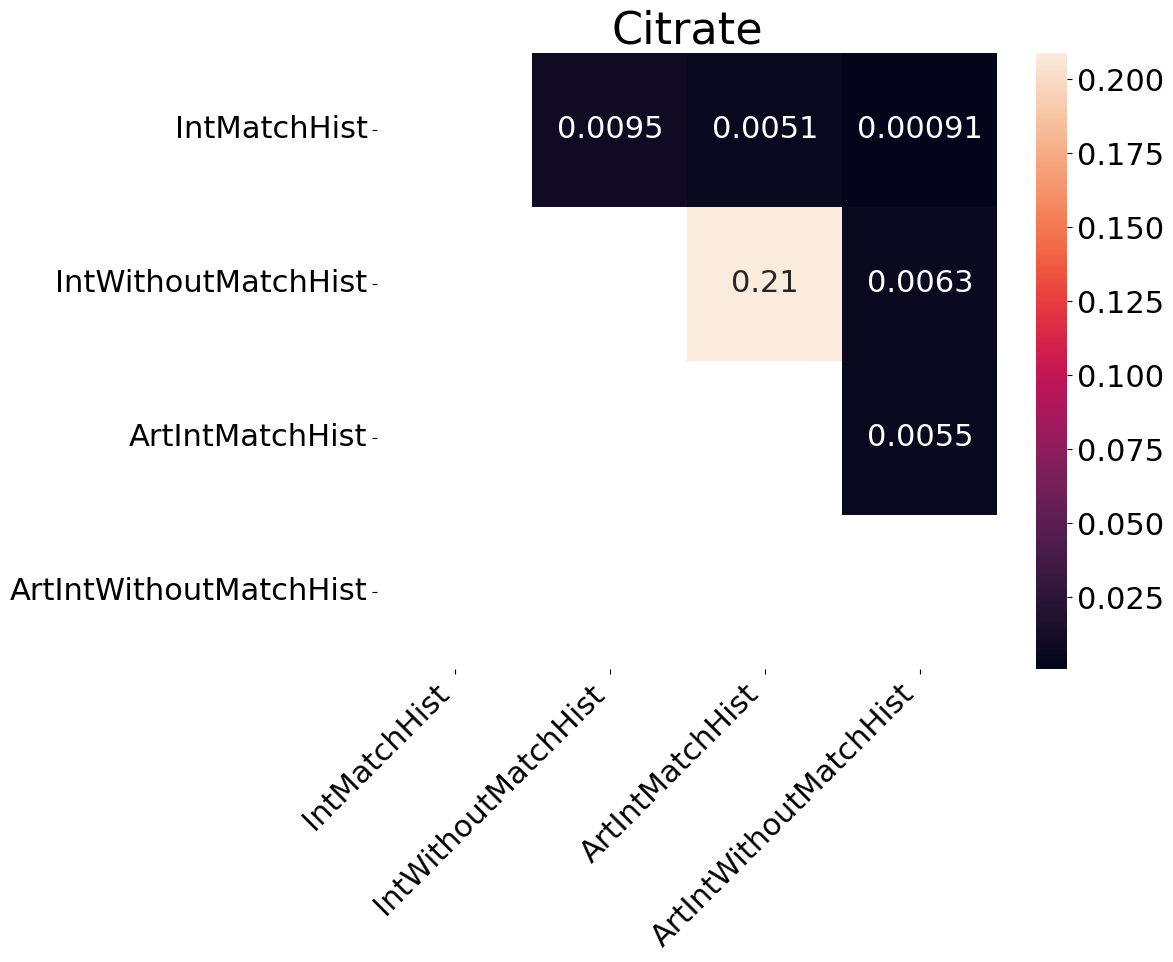

In [134]:
_, axs = plt.subplots(1, 1, figsize=(10, 8))
mask = np.tril(np.ones_like(corr_citrate_df))
ax = sns.heatmap(corr_citrate_df, mask=mask, annot=True, ax=axs, annot_kws={'fontsize': 22})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=22, rotation=45, ha='right')
# axs.set_xticks(ax.get_xticks()-1)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=22, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
axs.set_title('Citrate', fontsize=32)
# axs.set_xticklabels(axs.get_xticklabels(), rotation=45)
# axs.set_yticklabels(axs.get_yticklabels(), rotation=0)
# plt.xticks(rotation=45)
# plt.yticks(rotation=0)
# plt.xticks([0.5, 1.0, 1.5, 2])
# ax.set_xticks(ax.get_xticks() - 0.25)
# ax.set_xticks(ax.get_xticks()., rotation=45)
# path = 'images/citsper_citrate_analysis/heatmaps/citrate_heatmap.png'
# plt.savefig(path, transparent=True)
# plt.close()

In [135]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
mask = np.tril(np.ones_like(corr_citrate_df))
ax = sns.heatmap(corr_citrate_df, mask=mask, annot=True, ax=axs, annot_kws={'fontsize': 22})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=22, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=22, rotation=0)
axs.set_title('Citrate', fontsize=32)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
path = '../../images/citsper_citrate_analysis/heatmaps/citrate_heatmap.png'
fig.tight_layout()
plt.savefig(path, transparent=False)
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
mask = np.tril(np.ones_like(corr_zinc_df))
ax = sns.heatmap(corr_zinc_df, mask=mask, annot=True, ax=axs, annot_kws={'fontsize': 22})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=22, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=22, rotation=0)
axs.set_title('Zinc', fontsize=32)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
path = '../../images/citsper_citrate_analysis/heatmaps/zinc_heatmap.png'
fig.tight_layout()
plt.savefig(path, transparent=True)
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
mask = np.tril(np.ones_like(corr_spermine_df))
ax = sns.heatmap(corr_spermine_df, mask=mask, annot=True, ax=axs, annot_kws={'fontsize': 22})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=22, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=22, rotation=0)
axs.set_title('Spermine', fontsize=32)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
path = '../../images/citsper_citrate_analysis/heatmaps/spermine_heatmap.png'
fig.tight_layout()
plt.savefig(path, transparent=True)
plt.close()

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
mask = np.tril(np.ones_like(corr_all_df))
ax = sns.heatmap(corr_all_df, mask=mask, annot=True, ax=axs, annot_kws={'fontsize': 22})
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=22, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=22, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=22)
path = '../../images/citsper_citrate_analysis/heatmaps/all_heatmap.png'
fig.tight_layout()
plt.savefig(path, transparent=True)
plt.close()

In [136]:
all_stats

Spearman correlation        pvalue    n            Dataset type  \
001_04              0.572604  1.052932e-33  371            IntMatchHist   
002_01              0.601282  8.018855e-39  381            IntMatchHist   
003_02              0.200403  5.318925e-03  192            IntMatchHist   
004_03              0.236663  4.302982e-06  369            IntMatchHist   
045_03              0.539220  2.762129e-42  543            IntMatchHist   
...                      ...           ...  ...                     ...   
003_02             -0.098288  5.305228e-02  388  ArtIntWithoutMatchHist   
004_03              0.106883  2.129463e-02  464  ArtIntWithoutMatchHist   
045_03              0.115008  3.496690e-03  643  ArtIntWithoutMatchHist   
047_04              0.097729  1.747713e-02  591  ArtIntWithoutMatchHist   
048_02             -0.049723  3.369275e-01  375  ArtIntWithoutMatchHist   

       core_id sample_id background metabolite         Experiment type  \
001_04  001_04     P06_7        C03    citrate            IntMatchHist   
002_01  002_01     P04_3        C03    citrate            IntMatchHist   
003_02  003_02     P08_3        C03    citrate            IntMatchHist   
004_03  004_03     P07_7        C03    citrate            IntMatchHist   
045_03  045_03     P28_3        C03    citrate            IntMatchHist   
...        ...       ...        ...        ...                     ...   
003_02  003_02     P08_3        NaN   spermine  ArtIntWithoutMatchHist   
004_03  004_03     P07_7        NaN   spermine  ArtIntWithoutMatchHist   
045_03  045_03     P28_3        NaN   spermine  ArtIntWithoutMatchHist   
047_04  047_04     P30_4        NaN   spermine  ArtIntWithoutMatchHist   
048_02  048_02     P22_4        NaN   spermine  ArtIntWithoutMatchHist   

                       Dataset  
001_04            IntMatchHist  
002_01            IntMatchHist  
003_02            IntMatchHist  
004_03            IntMatchHist  
045_03            IntMatchHist  
...                        ...  
003_02  ArtIntWithoutMatchHist  
004_03  ArtIntWithoutMatchHist  
045_03  ArtIntWithoutMatchHist  
047_04  ArtIntWithoutMatchHist  
048_02  ArtIntWithoutMatchHist  

[84 rows x 10 columns]

In [137]:
# Bivariate normality test
citrate = merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name== '001_04']['met_Citrate']
citsper =merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == '001_04']['Citsper']

In [138]:
def average_correlation_unequal_sample_size(rs, ns):
    k = rs.shape[0]
    return ((ns - 1)*rs).sum()/(ns.sum() - k)

def average_z_transform(rs):
    return np.arctanh(rs.apply(z_transform).mean())

In [139]:
metabolite = 'citrate'
scy = df3.loc[metabolite]['Spearman correlation_y']
scx = df3.loc[metabolite]['Spearman correlation_x']
ny = df3.loc[metabolite]['n_y']
nx = df3.loc[metabolite]['n_x']
scx.mean(), average_correlation_unequal_sample_size(scx, nx), scy.mean(), average_correlation_unequal_sample_size(scy, ny)

(0.027119879337266662,
 0.030612708381356327,
 0.027119879337266662,
 0.030612708381356327)

In [140]:
metabolite = 'citrate'
scy = df3.loc[metabolite]['Spearman correlation_y'].apply(lambda x: z_transform(x))
scx = df3.loc[metabolite]['Spearman correlation_x'].apply(lambda x: z_transform(x))

In [141]:
mean_corrs = {}
mean_corrs2 = {}
mean_corrs3 = {}
for metabolite in metabolites:
    for dataset in datasets:
        mean_corrs[f'{dataset}_{metabolite}'] = all_stats[(all_stats.Dataset == dataset) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
        rs = all_stats[(all_stats.Dataset == dataset) & (all_stats.metabolite == metabolite)]['Spearman correlation']
        ns = all_stats[(all_stats.Dataset == dataset) & (all_stats.metabolite == metabolite)]['n']
        mean_corrs2[f'{dataset}_{metabolite}'] = average_correlation_unequal_sample_size(rs, ns)
        mean_corrs3[f'{dataset}_{metabolite}'] = average_z_transform(rs)
        
mean_corrs, mean_corrs2, mean_corrs3

({'IntMatchHist_citrate': 0.43736992413844344,
  'IntWithoutMatchHist_citrate': 0.3192626199803206,
  'ArtIntMatchHist_citrate': 0.23821868828458911,
  'ArtIntWithoutMatchHist_citrate': 0.027119879337266662,
  'IntMatchHist_spermine': 0.4463521426169837,
  'IntWithoutMatchHist_spermine': 0.378954423541924,
  'ArtIntMatchHist_spermine': 0.21248106227812433,
  'ArtIntWithoutMatchHist_spermine': 0.025439099816220456,
  'IntMatchHist_zinc': 0.3366536379670509,
  'IntWithoutMatchHist_zinc': 0.25442015632199283,
  'ArtIntMatchHist_zinc': 0.1654717776333101,
  'ArtIntWithoutMatchHist_zinc': 0.0071284153856605425},
 {'IntMatchHist_citrate': 0.4669602832011601,
  'IntWithoutMatchHist_citrate': 0.33765480549357657,
  'ArtIntMatchHist_citrate': 0.26271083507214177,
  'ArtIntWithoutMatchHist_citrate': 0.030612708381356327,
  'IntMatchHist_spermine': 0.46768545572989645,
  'IntWithoutMatchHist_spermine': 0.3910932462020905,
  'ArtIntMatchHist_spermine': 0.2473509370934441,
  'ArtIntWithoutMatchHist

In [142]:
all_stats['z_transformed_correlations'] = all_stats['Spearman correlation'].apply(z_transform)

In [143]:
relapse_free_group = ['P06_7', 'P04_3', 'P28_3']
relapse_group = ['P08_3', 'P07_7', 'P30_4', 'P22_4']
metabolite = 'citrate'
dataset = 'IM'
rf_corrs = all_stats[(all_stats.sample_id.isin(relapse_free_group)) & (all_stats.metabolite == metabolite) & (all_stats.Dataset == dataset)]['Spearman correlation']
r_corrs = all_stats[all_stats.sample_id.isin(relapse_group) & (all_stats.metabolite == metabolite) & (all_stats.Dataset == dataset)]['Spearman correlation']
rf_corrs.mean(), rf_corrs.std(), r_corrs.mean(), r_corrs.std(), scipy.stats.ttest_ind(rf_corrs, r_corrs, alternative='greater', equal_var=False)

(nan, nan, nan, nan, TtestResult(statistic=nan, pvalue=nan, df=nan))

In [144]:
relapse_free_group = ['P06_7', 'P04_3', 'P28_3']
relapse_group = ['P08_3', 'P07_7', 'P30_4', 'P22_4']
metabolite = 'zinc'
dataset = 'IM'
rf_corrs = all_stats[(all_stats.sample_id.isin(relapse_free_group)) & (all_stats.metabolite == metabolite) & (all_stats.Dataset == dataset)]['Spearman correlation']
r_corrs = all_stats[all_stats.sample_id.isin(relapse_group) & (all_stats.metabolite == metabolite) & (all_stats.Dataset == dataset)]['Spearman correlation']
rf_corrs.mean(), rf_corrs.std(), r_corrs.mean(), r_corrs.std(), scipy.stats.ttest_ind(rf_corrs, r_corrs, alternative='greater', equal_var=False)

(nan, nan, nan, nan, TtestResult(statistic=nan, pvalue=nan, df=nan))

In [145]:
relapse_free_group = ['P06_7', 'P04_3', 'P28_3']
relapse_group = ['P08_3', 'P07_7', 'P30_4', 'P22_4']
metabolite = 'spermine'
dataset = 'IM'
rf_corrs = all_stats[(all_stats.sample_id.isin(relapse_free_group)) & (all_stats.metabolite == metabolite) & (all_stats.Dataset == dataset)]['Spearman correlation']
r_corrs = all_stats[all_stats.sample_id.isin(relapse_group) & (all_stats.metabolite == metabolite) & (all_stats.Dataset == dataset)]['Spearman correlation']
rf_corrs.mean(), rf_corrs.std(), r_corrs.mean(), r_corrs.std(), scipy.stats.ttest_ind(rf_corrs, r_corrs, alternative='greater', equal_var=False)

(nan, nan, nan, nan, TtestResult(statistic=nan, pvalue=nan, df=nan))

<Axes: >

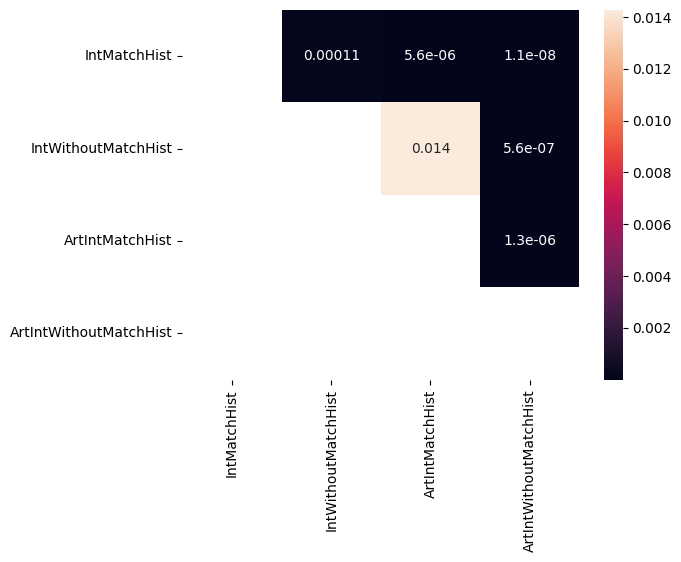

In [146]:
mask = np.tril(np.ones_like(corr_all_df))
sns.heatmap(corr_all_df, mask=mask, annot=True)

In [147]:
# Now do comparison between correct and artificial.
# Make table with differences between matching and non matching tissue types
df1 = all_stats[all_stats.Dataset == 'DCW'].set_index(['metabolite', 'sample_id'])
df2 = all_stats[all_stats.Dataset == 'DAW'].set_index(['metabolite', 'sample_id'])
df3 = df1.merge(df2, left_index=True, right_index=True)
df3 = df3[['Spearman correlation_y','Spearman correlation_x', 'n_y', 'n_x']]
tissue_matching_sigs = fisher_df[(fisher_df.scrExp == 'DCW') & (fisher_df.dstExp == 'DAW')].set_index(['metabolite', 'sample_id'])
df3['diff_pvalues'] = tissue_matching_sigs['pvalue']
df3.to_csv('comparison_correct_artificial_integration.csv')

In [148]:
fisher_df

sample_id metabolite                  scrExp                  dstExp  \
1       P06_7    citrate            IntMatchHist            IntMatchHist   
2       P06_7    citrate            IntMatchHist     IntWithoutMatchHist   
3       P06_7    citrate            IntMatchHist         ArtIntMatchHist   
4       P06_7    citrate            IntMatchHist  ArtIntWithoutMatchHist   
5       P06_7    citrate     IntWithoutMatchHist            IntMatchHist   
..        ...        ...                     ...                     ...   
332     P22_4   spermine         ArtIntMatchHist  ArtIntWithoutMatchHist   
333     P22_4   spermine  ArtIntWithoutMatchHist            IntMatchHist   
334     P22_4   spermine  ArtIntWithoutMatchHist     IntWithoutMatchHist   
335     P22_4   spermine  ArtIntWithoutMatchHist         ArtIntMatchHist   
336     P22_4   spermine  ArtIntWithoutMatchHist  ArtIntWithoutMatchHist   

     statistic distribution        pvalue  
1     0.000000            z  5.000000e-01  
2     3.170316            z  9.992386e-01  
3     1.674629            z  9.529964e-01  
4     7.910275            z  1.000000e+00  
5    -3.170316            z  7.613651e-04  
..         ...          ...           ...  
332   2.427200            z  9.923921e-01  
333  -5.927540            z  1.537529e-09  
334  -5.836512            z  2.665252e-09  
335  -2.427200            z  7.607941e-03  
336   0.000000            z  5.000000e-01  

[336 rows x 7 columns]

In [68]:
from numpy.random import normal
from scipy.stats import norm

### Control vs. Recurrence analysis

In [69]:
reg_accs_df = pd.read_csv('/mnt/scratch/maximilw/data/multiomics_integration/st_maldi_pos_integration/stats.csv', index_col=0).transpose()
reg_accs_df = reg_accs_df.loc[['001_04', '002_01', '003_02', '047_04' ]]
reg_accs_df

multi_mean_rtre     multi_median_rtre      multi_mean_tre  \
001_04  0.019584991859054608   0.01685664394350595    81.0245907151756   
002_01  0.013774432105783805  0.012794224912467459   55.13773034915338   
003_02   0.03164677344024688   0.03100364027521648  129.62313267218084   
047_04  0.014992059475658478  0.013429541068358995  59.981466935954394   

          multi_median_tre      direct_mean_rtre    direct_median_rtre  \
001_04    69.7372092969531   0.03291162331087248   0.02642009525363826   
002_01  51.214054984803276   0.01285144518986262  0.011595720964544948   
003_02  126.98890091601089  0.029015568156608315  0.028874694668098142   
047_04   53.73001453634085  0.015570403884147384  0.013226354164218936   

           direct_mean_tre   direct_median_tre           duration  \
001_04  136.15787168696826  109.30192976272839  640.6549348831177   
002_01   51.44310226612048   46.41655865279846  652.6104004383087   
003_02  118.84588638472603   118.2688777071866   632.680561542511   
047_04  62.295354902560646   52.91708762711375  648.3847341537476   

       best_strategy  
001_04         multi  
002_01        direct  
003_02        direct  
047_04         multi

In [70]:
reg_accs_df.index

Index(['001_04', '002_01', '003_02', '047_04'], dtype='object')

In [71]:
# Scatter plots
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_name = '001_04'
for core_name in merged_neg_correct_df_red2.core_name.unique():
    _, axs = plt.subplots(1, 3, figsize=(30, 8))
    ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[0])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Citrate', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[1])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Zinc', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[2])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Spermine', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
    plt.savefig(f'../../images/citsper_citrate_analysis/scatterplot_csgs_czs_{core_name}.png', transparent=True)
    plt.close()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

<Axes: xlabel='Citsper', ylabel='met_Spermine'>

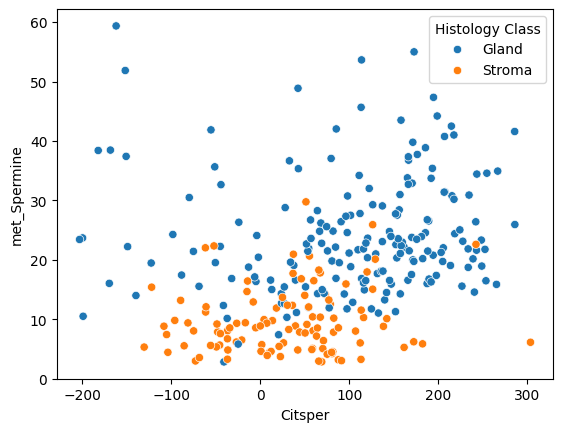

In [72]:
sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping)

In [61]:
if not exists('../../images/citsper_citrate_analysis/scatter_plots'):
    os.mkdir('../../images/citsper_citrate_analysis/scatter_plots')

In [73]:
# Scatter plots
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[0]
color_mapping['Gland'] = standard_color[1]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# core_name = '001_04'
for core_name in merged_neg_correct_df_red2.core_name.unique():
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    ax = sns.regplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', ax=axs[0], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[0])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Citrate', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.regplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', ax=axs[1], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[1])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Zinc', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.regplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', ax=axs[2], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[2])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Spermine', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
    fig.tight_layout()
    plt.savefig(f'../../images/citsper_citrate_analysis/scatter_plots/scatterplot_csgs_czs_{core_name}_with_line.png', transparent=True)
    plt.close()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

In [111]:
# Scatter plots
fontsize=28
tick_fontsize=22
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[0]
color_mapping['Gland'] = standard_color[1]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# core_name = '001_04'
for core_name in merged_neg_correct_df_red2.core_name.unique():
    fig, axs = plt.subplots(2, 2, figsize=(29, 15))
    ax = sns.regplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', ax=axs[0,0], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[0])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Citrate', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.regplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', ax=axs[0,1], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[1])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Zinc', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.regplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', ax=axs[1,0], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[2])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Spermine', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
    axs[1,1].axis('off')
    fig.tight_layout()
    fig.subplots_adjust(hspace=.25)
    fig.subplots_adjust(wspace=0.25)
    plt.savefig(f'../../images/citsper_citrate_analysis/scatter_plots/scatterplot_csgs_czs_{core_name}_with_line_square_layout.png', transparent=True)
    plt.close()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

In [75]:
# Scatter plots
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[0]
color_mapping['Gland'] = standard_color[1]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# core_name = '001_04'
for core_name in merged_neg_correct_df_red2.core_name.unique():
    fig, axs = plt.subplots(1, 3, figsize=(30, 8))
    ax = sns.regplot(data=merged_neg_correct_df_red[merged_neg_correct_df_red.core_name == core_name], x='Citsper', y='met_Citrate', ax=axs[0], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_neg_correct_df_red[merged_neg_correct_df_red.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[0])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Citrate', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.regplot(data=merged_neg_correct_df_red[merged_neg_correct_df_red.core_name == core_name], x='Citsper', y='met_Zinc', ax=axs[1], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_neg_correct_df_red[merged_neg_correct_df_red.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[1])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Zinc', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    ax.legend([],[], frameon=False)
    ax = sns.regplot(data=merged_pos_correct_df_red[merged_pos_correct_df_red.core_name == core_name], x='Citsper', y='met_Spermine', ax=axs[2], scatter=False, line_kws={"color": "black"}, ci=None)
    ax = sns.scatterplot(data=merged_pos_correct_df_red[merged_pos_correct_df_red.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=ax)
    # ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[2])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Spermine', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
    fig.tight_layout()
    plt.savefig(f'../../images/citsper_citrate_analysis/scatter_plots/scatterplot_csgs_czs_{core_name}_with_line_without_tissue_matching.png', transparent=True)
    plt.close()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

In [82]:
merged_neg_correct_df_red2.groupby('core_name').apply(lambda x: x.recurrence.iloc[0])

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


core_name
001_04       control
002_01       control
003_02    recurrence
004_03    recurrence
045_03       control
047_04    recurrence
048_02    recurrence
dtype: object

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


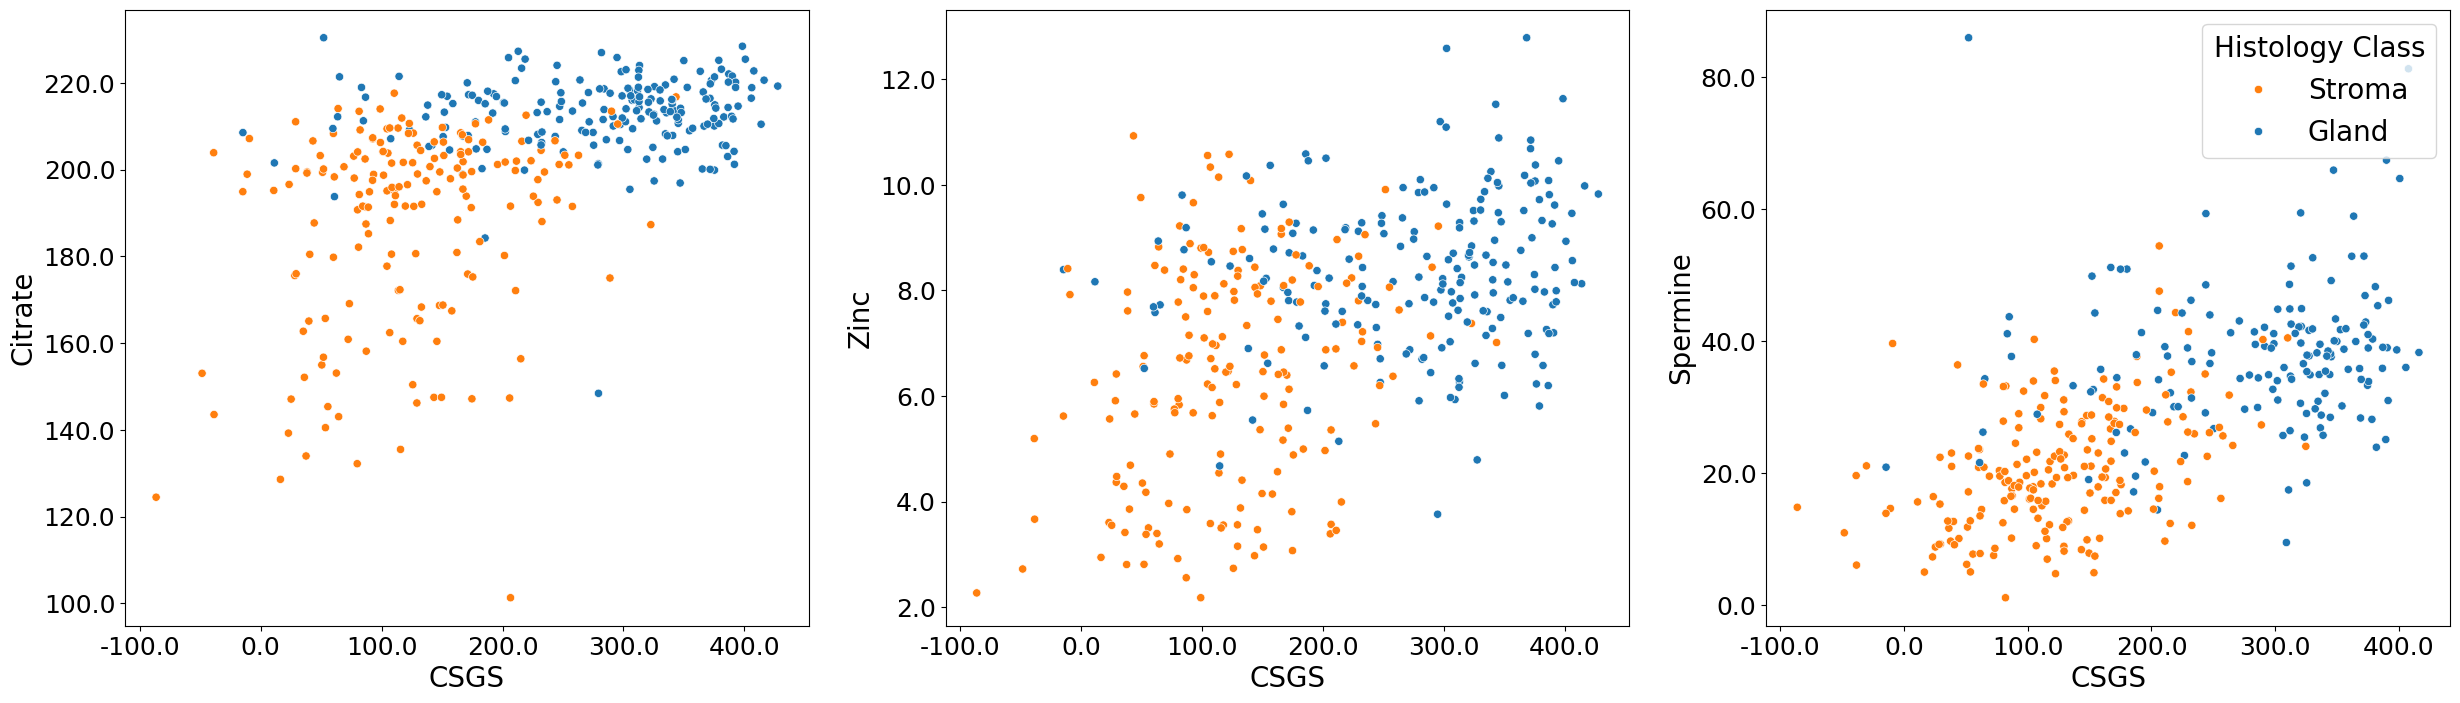

In [83]:
# Scatter plots
fontsize=20
tick_fontsize=18
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_name = '001_04'
_, axs = plt.subplots(1, 3, figsize=(30, 8))
ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[0])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Citrate', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
ax.legend([],[], frameon=False)
ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == core_name], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[1])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Zinc', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
ax.legend([],[], frameon=False)
ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[2])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Spermine', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
plt.savefig('../../images/citsper_citrate_analysis/scatterplot_csgs_czs.png', transparent=True)

In [33]:
import sys
sys.path.append('../../')

In [34]:
control_samples = ['001_04', '002_01', '045_03']
recurrence_samples = ['003_02', '004_03', '047_04', '048_02']

In [96]:
heatmap_df = all_stats[all_stats['Dataset type'] == 'IntMatchHist']
heatmap_df.set_index('sample_id', inplace=True)
sub_h1 = heatmap_df[heatmap_df.metabolite == 'citrate']['Spearman correlation']
sub_h1.name = 'Citrate'
sub_h2 = heatmap_df[heatmap_df.metabolite == 'zinc']['Spearman correlation']
sub_h2.name = 'Zinc'
sub_h3 = heatmap_df[heatmap_df.metabolite == 'spermine']['Spearman correlation']
sub_h3.name = 'Spermine'
heatmap_df = pd.concat([sub_h1, sub_h2, sub_h3], axis=1)
heatmap_df = heatmap_df.loc[plot_order]

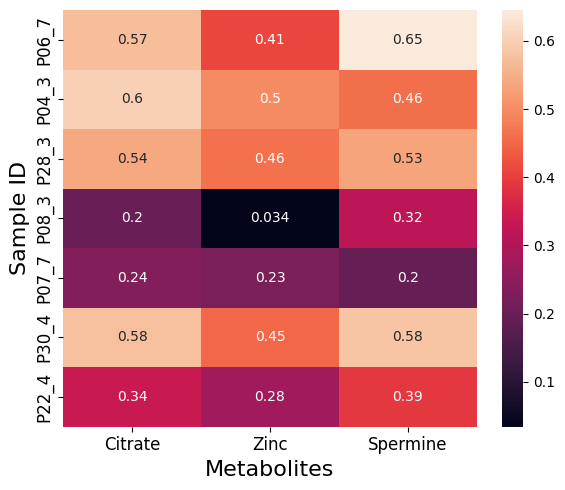

In [132]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
sns.heatmap(heatmap_df, ax=axs, annot=True)
axs.set_ylabel('Sample ID', fontsize=16)
axs.set_xlabel('Metabolites', fontsize=16)
axs.set_yticklabels(axs.get_yticklabels(), size=12)
axs.set_xticklabels(axs.get_xticklabels(), size=12)
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/heatmap_correlations_cczs.png', transparent=True)

In [81]:
heatmap_df

Spearman correlation        pvalue    n  Dataset type core_id  \
sample_id                                                                  
P06_7                  0.572604  1.052932e-33  371  IntMatchHist  001_04   
P04_3                  0.601282  8.018855e-39  381  IntMatchHist  002_01   
P08_3                  0.200403  5.318925e-03  192  IntMatchHist  003_02   
P07_7                  0.236663  4.302982e-06  369  IntMatchHist  004_03   
P28_3                  0.539220  2.762129e-42  543  IntMatchHist  045_03   
P30_4                  0.575421  1.489882e-36  399  IntMatchHist  047_04   
P22_4                  0.335997  7.192221e-09  282  IntMatchHist  048_02   
P06_7                  0.409107  2.109747e-16  371  IntMatchHist  001_04   
P04_3                  0.497298  3.401214e-25  381  IntMatchHist  002_01   
P08_3                  0.033879  6.408522e-01  192  IntMatchHist  003_02   
P07_7                  0.225670  1.204017e-05  369  IntMatchHist  004_03   
P28_3                  0.462778  3.582788e-30  543  IntMatchHist  045_03   
P30_4                  0.450284  2.573200e-21  399  IntMatchHist  047_04   
P22_4                  0.277560  2.205099e-06  282  IntMatchHist  048_02   
P06_7                  0.645324  1.719202e-42  349  IntMatchHist  001_04   
P04_3                  0.459313  5.575842e-20  356  IntMatchHist  002_01   
P08_3                  0.316129  6.026957e-06  197  IntMatchHist  003_02   
P07_7                  0.196107  3.386242e-04  330  IntMatchHist  004_03   
P28_3                  0.533164  5.172721e-42  554  IntMatchHist  045_03   
P30_4                  0.583211  3.484009e-38  404  IntMatchHist  047_04   
P22_4                  0.391216  2.899232e-12  296  IntMatchHist  048_02   

          background metabolite Experiment type       Dataset  \
sample_id                                                       
P06_7            C03    citrate    IntMatchHist  IntMatchHist   
P04_3            C03    citrate    IntMatchHist  IntMatchHist   
P08_3            C03    citrate    IntMatchHist  IntMatchHist   
P07_7            C03    citrate    IntMatchHist  IntMatchHist   
P28_3            C03    citrate    IntMatchHist  IntMatchHist   
P30_4            C03    citrate    IntMatchHist  IntMatchHist   
P22_4            C03    citrate    IntMatchHist  IntMatchHist   
P06_7            NaN       zinc    IntMatchHist  IntMatchHist   
P04_3            NaN       zinc    IntMatchHist  IntMatchHist   
P08_3            NaN       zinc    IntMatchHist  IntMatchHist   
P07_7            NaN       zinc    IntMatchHist  IntMatchHist   
P28_3            NaN       zinc    IntMatchHist  IntMatchHist   
P30_4            NaN       zinc    IntMatchHist  IntMatchHist   
P22_4            NaN       zinc    IntMatchHist  IntMatchHist   
P06_7            NaN   spermine    IntMatchHist  IntMatchHist   
P04_3            NaN   spermine    IntMatchHist  IntMatchHist   
P08_3            NaN   spermine    IntMatchHist  IntMatchHist   
P07_7            NaN   spermine    IntMatchHist  IntMatchHist   
P28_3            NaN   spermine    IntMatchHist  IntMatchHist   
P30_4            NaN   spermine    IntMatchHist  IntMatchHist   
P22_4            NaN   spermine    IntMatchHist  IntMatchHist   

           z_transformed_correlations  
sample_id                              
P06_7                        0.651389  
P04_3                        0.695153  
P08_3                        0.203152  
P07_7                        0.241236  
P28_3                        0.603056  
P30_4                        0.655589  
P22_4                        0.349573  
P06_7                        0.434538  
P04_3                        0.545709  
P08_3                        0.033892  
P07_7                        0.229622  
P28_3                        0.500841  
P30_4                        0.485057  
P22_4                        0.285036  
P06_7                        0.767245  
P04_3                        0.496440  
P08_3                        0.327340  
P07_7 

In [87]:
all_stats.loc['045_03']

Spearman correlation        pvalue    n            Dataset type  \
045_03              0.539220  2.762129e-42  543            IntMatchHist   
045_03              0.455911  1.340626e-38  727     IntWithoutMatchHist   
045_03              0.212172  4.715368e-05  362         ArtIntMatchHist   
045_03             -0.015308  6.935474e-01  665  ArtIntWithoutMatchHist   
045_03              0.462778  3.582788e-30  543            IntMatchHist   
045_03              0.379895  2.245690e-26  727     IntWithoutMatchHist   
045_03              0.024748  6.388459e-01  362         ArtIntMatchHist   
045_03             -0.040321  2.991562e-01  665  ArtIntWithoutMatchHist   
045_03              0.533164  5.172721e-42  554            IntMatchHist   
045_03              0.447431  4.735254e-36  706     IntWithoutMatchHist   
045_03              0.382641  6.811914e-14  357         ArtIntMatchHist   
045_03              0.115008  3.496690e-03  643  ArtIntWithoutMatchHist   

       core_id sample_id background metabolite         Experiment type  \
045_03  045_03     P28_3        C03    citrate            IntMatchHist   
045_03  045_03     P28_3        C03    citrate     IntWithoutMatchHist   
045_03  045_03     P28_3        C03    citrate         ArtIntMatchHist   
045_03  045_03     P28_3        C03    citrate  ArtIntWithoutMatchHist   
045_03  045_03     P28_3        NaN       zinc            IntMatchHist   
045_03  045_03     P28_3        NaN       zinc     IntWithoutMatchHist   
045_03  045_03     P28_3        NaN       zinc         ArtIntMatchHist   
045_03  045_03     P28_3        NaN       zinc  ArtIntWithoutMatchHist   
045_03  045_03     P28_3        NaN   spermine            IntMatchHist   
045_03  045_03     P28_3        NaN   spermine     IntWithoutMatchHist   
045_03  045_03     P28_3        NaN   spermine         ArtIntMatchHist   
045_03  045_03     P28_3        NaN   spermine  ArtIntWithoutMatchHist   

                       Dataset  z_transformed_correlations  
045_03            IntMatchHist                    0.603056  
045_03     IntWithoutMatchHist                    0.492137  
045_03         ArtIntMatchHist                    0.215444  
045_03  ArtIntWithoutMatchHist                   -0.015310  
045_03            IntMatchHist                    0.500841  
045_03     IntWithoutMatchHist                    0.399937  
045_03         ArtIntMatchHist                    0.024753  
045_03  ArtIntWithoutMatchHist                   -0.040343  
045_03            IntMatchHist                    0.594556  
045_03     IntWithoutMatchHist                    0.481484  
045_03         ArtIntMatchHist                    0.403150  
045_03  ArtIntWithoutMatchHist                    0.115519

In [35]:
ctr_df = pd.DataFrame('control', index=control_samples, columns=['status'])
rec_df = pd.DataFrame('recurrence', index=recurrence_samples, columns=['status'])
status_df = pd.concat([ctr_df, rec_df], axis=0)
nc_2_cit_core_sp_stats['status'] = status_df
nc_1_cit_core_sp_stats['status'] = status_df
nc_2_zinc_core_sp_stats['status'] = status_df
nc_1_zinc_core_sp_stats['status'] = status_df
pc_2_spe_core_sp_stats['status'] = status_df
pc_1_spe_core_sp_stats['status'] = status_df
nw_2_cit_core_sp_stats['status'] = status_df
nw_1_cit_core_sp_stats['status'] = status_df
nw_2_zinc_core_sp_stats['status'] = status_df
nw_1_zinc_core_sp_stats['status'] = status_df
pw_2_spe_core_sp_stats['status'] = status_df
pw_1_spe_core_sp_stats['status'] = status_df

In [36]:
import numpy as np

def get_mm_stats(df, p=0.0001):
    stats = {}
    df = df[df.pvalue <= p]
    if df.shape[0] == 0:
        stats['mean'] = np.nan
        stats['median'] = np.nan
        stats['std'] = np.nan
        stats['n'] = df.shape[0]
    else:
        stats['mean'] = df.statistic.mean()
        stats['median'] = df.statistic.median()
        stats['std'] = df.statistic.std()
        stats['n'] = df.shape[0]
    return pd.DataFrame(stats, index=[0])

def build_mm_df(df, exp_name, group_col='status'):
    temp_df = df.groupby(group_col).apply(lambda x: get_mm_stats(x))
    temp_df['exp'] = exp_name 
    temp_df.index = [x[0] for x in temp_df.index]
    temp_df = temp_df.reset_index()

    all_row =  get_mm_stats(df)
    all_row['exp'] = exp_name 
    all_row['index'] = 'all'
    temp_df = pd.concat([temp_df, all_row]).reset_index(drop=True)
    return temp_df

nc2cit_df = build_mm_df(nc_2_cit_core_sp_stats, 'nc_2_cit')
nc1cit_df = build_mm_df(nc_1_cit_core_sp_stats, 'nc_1_cit')
nc2zinc_df = build_mm_df(nc_2_zinc_core_sp_stats, 'nc_2_zinc')
nc1zinc_df = build_mm_df(nc_1_zinc_core_sp_stats, 'nc_1_zinc')
pc2spe_df = build_mm_df(pc_2_spe_core_sp_stats, 'pc_2_spe')
pc1spe_df = build_mm_df(pc_1_spe_core_sp_stats, 'pc_1_spe')
nw2cit_df = build_mm_df(nw_2_cit_core_sp_stats, 'nw_2_cit')
nw1cit_df = build_mm_df(nw_1_cit_core_sp_stats, 'nw_1_cit')
nw2zinc_df = build_mm_df(nw_2_zinc_core_sp_stats, 'nw_2_zinc')
nw1zinc_df = build_mm_df(nw_1_zinc_core_sp_stats, 'nw_1_zinc')
pw2spe_df = build_mm_df(pw_2_spe_core_sp_stats, 'pw_2_spe')
pw1spe_df = build_mm_df(pw_1_spe_core_sp_stats, 'pw_1_spe')
mm_df = pd.concat([nc2cit_df, 
                   nc1cit_df, 
                   nw2cit_df, 
                   nw1cit_df, 
                   nc2zinc_df, 
                   nc1zinc_df, 
                   nw2zinc_df, 
                   nw1zinc_df,
                   pc2spe_df,
                   pc1spe_df,
                   pw2spe_df,
                   pw1spe_df])

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grou

In [37]:
mm_df

index      mean    median       std  n        exp
0     control  0.571035  0.572604  0.031060  3   nc_2_cit
1  recurrence  0.382694  0.335997  0.174140  3   nc_2_cit
2         all  0.476864  0.555912  0.152176  6   nc_2_cit
0     control  0.443209  0.455911  0.028775  3   nc_1_cit
1  recurrence  0.280344  0.287341  0.058455  3   nc_1_cit
2         all  0.361777  0.372628  0.098262  6   nc_1_cit
0     control  0.329868  0.309165  0.129297  3   nw_2_cit
1  recurrence  0.520236  0.520236       NaN  1   nw_2_cit
2         all  0.377460  0.388716  0.142145  4   nw_2_cit
0     control       NaN       NaN       NaN  0   nw_1_cit
1  recurrence       NaN       NaN       NaN  0   nw_1_cit
2         all       NaN       NaN       NaN  0   nw_1_cit
0     control  0.456394  0.462778  0.044441  3  nc_2_zinc
1  recurrence  0.317838  0.277560  0.117600  3  nc_2_zinc
2         all  0.387116  0.429695  0.109914  6  nc_2_zinc
0     control  0.357733  0.379895  0.046643  3  nc_1_zinc
1  recurrence  0.237770  0.221644  0.043884  3  nc_1_zinc
2         all  0.297751  0.295788  0.077188  6  nc_1_zinc
0     control  0.274833  0.274833       NaN  1  nw_2_zinc
1  recurrence  0.460741  0.460741       NaN  1  nw_2_zinc
2         all  0.367787  0.367787  0.131457  2  nw_2_zinc
0     control       NaN       NaN       NaN  0  nw_1_zinc
1  recurrence -0.208669 -0.208669       NaN  1  nw_1_zinc
2         all -0.208669 -0.208669       NaN  1  nw_1_zinc
0     control  0.545934  0.533164  0.093661  3   pc_2_spe
1  recurrence  0.430185  0.391216  0.137740  3   pc_2_spe
2         all  0.488060  0.496238  0.122952  6   pc_2_spe
0     control  0.487160  0.505271  0.034451  3   pc_1_spe
1  recurrence  0.297801  0.296648  0.066423  4   pc_1_spe
2         all  0.378954  0.360885  0.113342  7   pc_1_spe
0     control  0.357950  0.357950  0.034919  2   pw_2_spe
1  recurrence  0.424187  0.424187       NaN  1   pw_2_spe
2         all  0.380029  0.382641  0.045521  3   pw_2_spe
0     control       NaN       NaN       NaN  0   pw_1_spe
1  recurrence       NaN       NaN       NaN  0   pw_1_spe
2         all       NaN       NaN       NaN  0   pw_1_spe

In [38]:
mm_df['experiment_no'] = mm_df.exp.apply(lambda x: int(x.split('_')[1]))
mm_df['correct'] = mm_df.exp.apply(lambda x: True if x[1] == 'c' else False)
mm_df.to_csv('group_czs.csv')

In [39]:
mm_df

index      mean    median       std  n        exp  experiment_no  \
0     control  0.571035  0.572604  0.031060  3   nc_2_cit              2   
1  recurrence  0.382694  0.335997  0.174140  3   nc_2_cit              2   
2         all  0.476864  0.555912  0.152176  6   nc_2_cit              2   
0     control  0.443209  0.455911  0.028775  3   nc_1_cit              1   
1  recurrence  0.280344  0.287341  0.058455  3   nc_1_cit              1   
2         all  0.361777  0.372628  0.098262  6   nc_1_cit              1   
0     control  0.329868  0.309165  0.129297  3   nw_2_cit              2   
1  recurrence  0.520236  0.520236       NaN  1   nw_2_cit              2   
2         all  0.377460  0.388716  0.142145  4   nw_2_cit              2   
0     control       NaN       NaN       NaN  0   nw_1_cit              1   
1  recurrence       NaN       NaN       NaN  0   nw_1_cit              1   
2         all       NaN       NaN       NaN  0   nw_1_cit              1   
0     control  0.456394  0.462778  0.044441  3  nc_2_zinc              2   
1  recurrence  0.317838  0.277560  0.117600  3  nc_2_zinc              2   
2         all  0.387116  0.429695  0.109914  6  nc_2_zinc              2   
0     control  0.357733  0.379895  0.046643  3  nc_1_zinc              1   
1  recurrence  0.237770  0.221644  0.043884  3  nc_1_zinc              1   
2         all  0.297751  0.295788  0.077188  6  nc_1_zinc              1   
0     control  0.274833  0.274833       NaN  1  nw_2_zinc              2   
1  recurrence  0.460741  0.460741       NaN  1  nw_2_zinc              2   
2         all  0.367787  0.367787  0.131457  2  nw_2_zinc              2   
0     control       NaN       NaN       NaN  0  nw_1_zinc              1   
1  recurrence -0.208669 -0.208669       NaN  1  nw_1_zinc              1   
2         all -0.208669 -0.208669       NaN  1  nw_1_zinc              1   
0     control  0.545934  0.533164  0.093661  3   pc_2_spe              2   
1  recurrence  0.430185  0.391216  0.137740  3   pc_2_spe              2   
2         all  0.488060  0.496238  0.122952  6   pc_2_spe              2   
0     control  0.487160  0.505271  0.034451  3   pc_1_spe              1   
1  recurrence  0.297801  0.296648  0.066423  4   pc_1_spe              1   
2         all  0.378954  0.360885  0.113342  7   pc_1_spe              1   
0     control  0.357950  0.357950  0.034919  2   pw_2_spe              2   
1  recurrence  0.424187  0.424187       NaN  1   pw_2_spe              2   
2         all  0.380029  0.382641  0.045521  3   pw_2_spe              2   
0     control       NaN       NaN       NaN  0   pw_1_spe              1   
1  recurrence       NaN       NaN       NaN  0   pw_1_spe              1   
2         all       NaN       NaN       NaN  0   pw_1_spe              1   

   correct  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False

### Plot counts before and after integration

In [40]:
Counter(merged_neg_correct_df_red['Histology Class'])

Counter({'Gland': 2126, 'Stroma': 1722})

In [41]:
Counter(merged_neg_correct_df_red2['Histology Class'])

Counter({'Stroma': 1358, 'Gland': 1179})

In [42]:
Counter(merged_neg_wrong_df_red2['Histology Class'])

Counter({'Stroma': 948, 'Gland': 810})

In [99]:
data = {
    'Stroma': (2126, 1358, 948),
    'Glands': (1722, 1179, 810),
    # '3': (189.95, 195.82, 217.19),
}

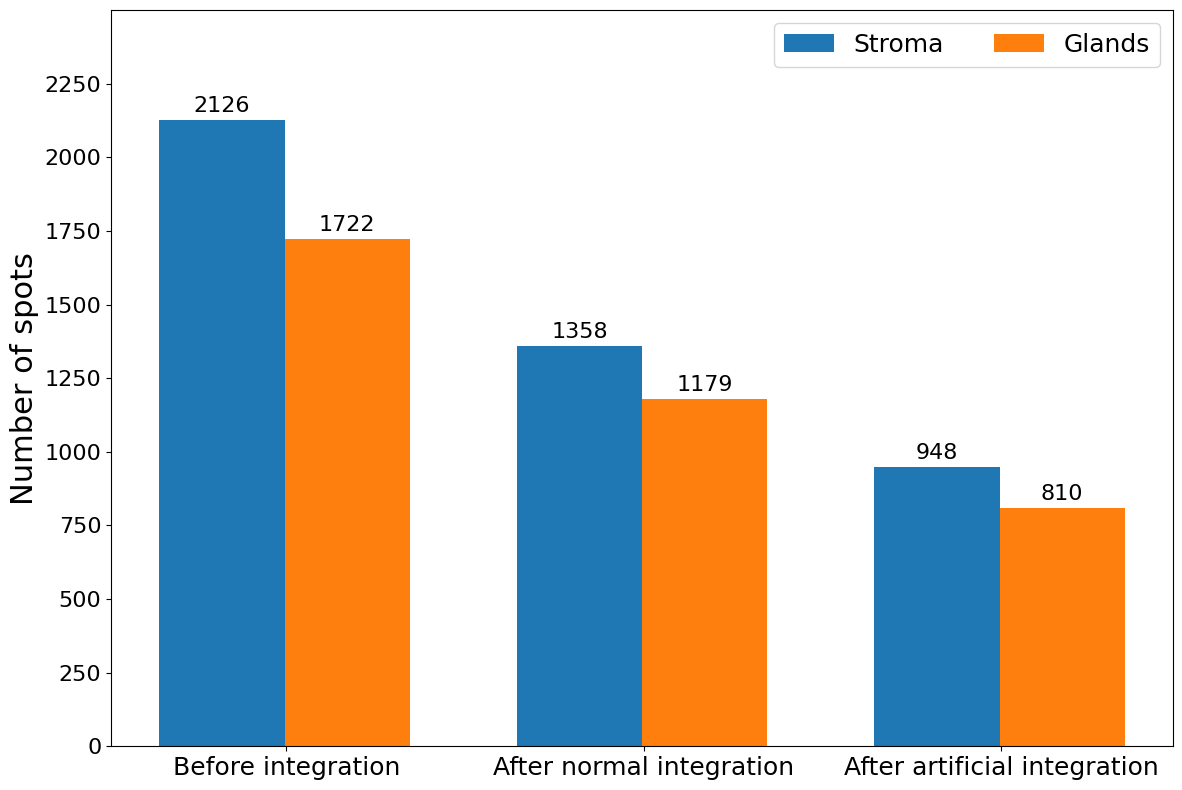

In [100]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(12,8))
states = ("Before Integration", "After Integration", "After artificial integration")
states_text = ('Before integration', 'After normal integration', 'After artificial integration')
# data = {
#     'Stroma': (2115, 1387, 994),
#     'Glands': (1724, 1200, 836),
#     # '3': (189.95, 195.82, 217.19),
# }
data = {
    'Stroma': (2126, 1358, 948),
    'Glands': (1722, 1179, 810),
    # '3': (189.95, 195.82, 217.19),
}

x = np.arange(len(states))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = axs.bar(x + offset, measurement, width, label=attribute)
    axs.bar_label(rects, padding=3, fontsize=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Number of spots', fontsize=22)
axs.set_yticks(axs.get_yticks(), [str(int(x)) for x in axs.get_yticks()], fontsize=16)
# ax.set_xlabel('
# ax.set_title('Penguin attributes by species')
axs.set_xticks(x + width-0.17, states_text, fontsize=18)
axs.legend(loc='upper right', ncols=3, fontsize=18)
axs.set_ylim(0, 2500)

# plt.show()
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/stroma_gland_neg_dist.png')

In [102]:
# Compute matching tissue types

merged_neg_correct_df_red2.core_name.unique()

array(['045_03', '001_04', '002_01', '004_03', '003_02', '047_04',
       '048_02'], dtype=object)

In [103]:
far_cores = ['001_04', '002_01', '003_02', '004_03']
near_cores = ['045_03', '047_04', '048_02']

In [106]:
n100 = merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name.isin(far_cores)].shape[0]
n50 = merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name.isin(near_cores)].shape[0]
n80 = merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(far_cores)].shape[0]
n40 = merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(near_cores)].shape[0]
n40, n80, n50, n100

(1254, 1232, 1224, 1313)

In [117]:
near_neg_cores = merged_neg_correct_df_red[merged_neg_correct_df_red.core_name.isin(near_cores)]
far_neg_cores = merged_neg_correct_df_red[merged_neg_correct_df_red.core_name.isin(far_cores)]
near_pos_cores = merged_pos_correct_df_red[merged_pos_correct_df_red.core_name.isin(near_cores)]
far_pos_cores = merged_pos_correct_df_red[merged_pos_correct_df_red.core_name.isin(far_cores)]
n40 = (near_pos_cores['Histology Class'] == near_pos_cores.msi_hist).sum()
n50 = (near_neg_cores['Histology Class'] == near_neg_cores.msi_hist).sum()
n80 = (far_pos_cores['Histology Class'] == far_pos_cores.msi_hist).sum()
n100 = (far_neg_cores['Histology Class'] == far_neg_cores.msi_hist).sum()

n40/near_pos_cores.shape[0], n50/near_neg_cores.shape[0], n80/far_pos_cores.shape[0], n100/far_neg_cores.shape[0]

(0.7477638640429338,
 0.7099767981438515,
 0.6105054509415263,
 0.6181732580037664)

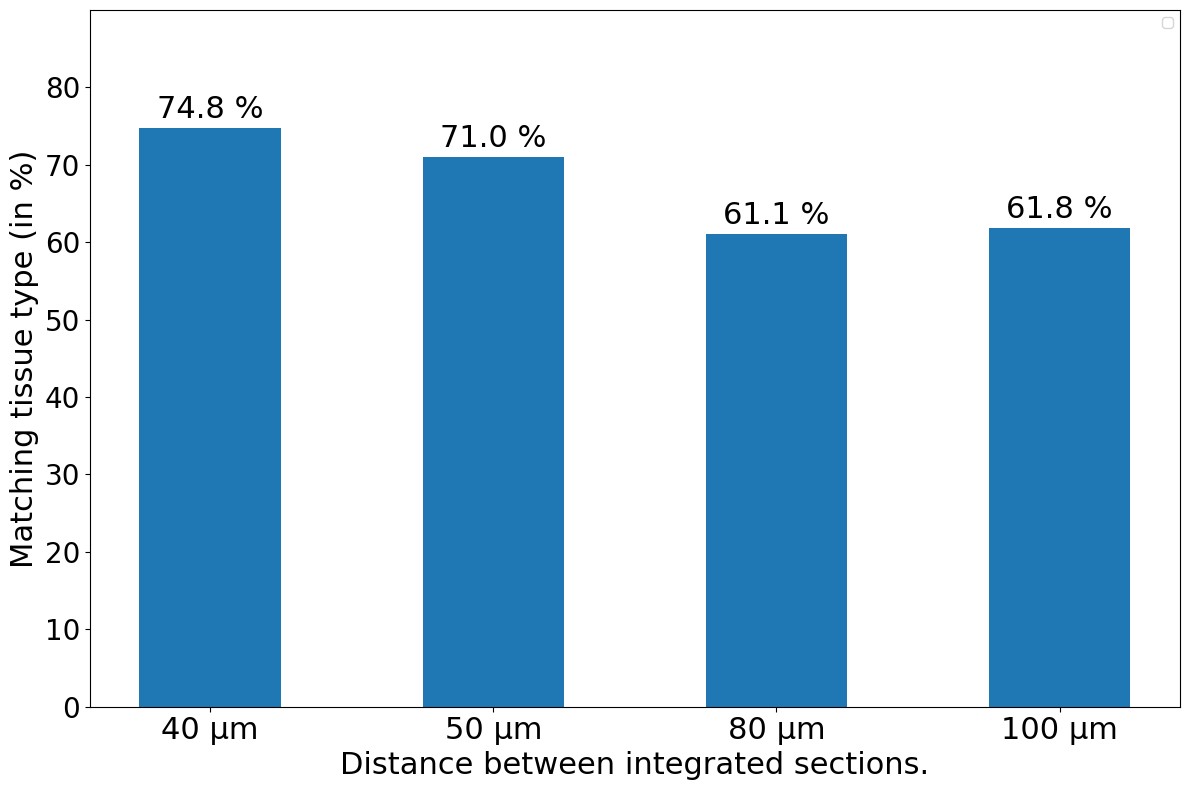

In [122]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(12,8))
states = ('40 μm', '50 μm', '80 μm', '100 μm')
states_text = states
# states_text = ('No integration', 'Integration', 'Artificial integration')
# data = {
#     'Stroma': (2120, 1505, 1095),
#     'Glands': (1729, 1035, 660),
#     # '3': (189.95, 195.82, 217.19),
# }
data = {'spots': (74.8, 71.0, 61.1, 61.8)}

x = np.arange(len(states))  # the label locations
width = 0.5  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = axs.bar(x + offset, measurement, width, label=attribute)
    axs.bar_label(rects, padding=3, fontsize=22, labels=[f'{x} %' for x in measurement])
    multiplier += .5

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Matching tissue type (in %)', fontsize=22)
axs.set_yticks(axs.get_yticks(), [str(int(x)) for x in axs.get_yticks()], fontsize=20)
axs.set_xlabel('Distance between integrated sections.', fontsize=22)
# ax.set_title('Penguin attributes by species')
# axs.set_xticks(x + width - 0.75, states_text, fontsize=18)
axs.set_xticks(x + width - 0.5, states_text, fontsize=22)
axs.set_yticks(axs.get_yticks(), [str(int(x)) for x in axs.get_yticks()], fontsize=20)
axs.legend(loc='upper right', ncols=3, fontsize=22)
axs.set_ylim(0, 90)
axs.legend([], [], frameon=True)

# plt.show()
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/matching_spots_barplot.png')

(0.0, 1.0)

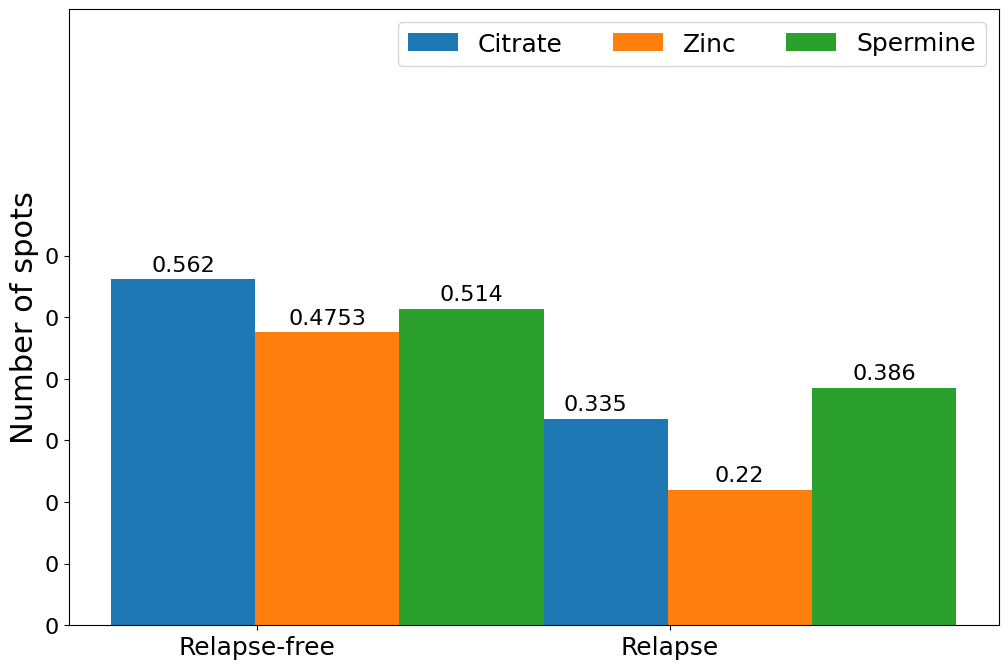

In [52]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

_, axs = plt.subplots(1, 1, figsize=(12,8))
# states = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
# states_text = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
states = ("Relapse-free", "Relapse")
states_text = ("Relapse-free", "Relapse")
data = {
    'Citrate': (0.562, 0.335),
    'Zinc': (0.4753, 0.220),
    'Spermine': (0.514, 0.386),
    # '3': (189.95, 195.82, 217.19),
}

x = np.arange(len(states))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = axs.bar(x + offset, measurement, width, label=attribute)
    axs.bar_label(rects, padding=3, fontsize=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Number of spots', fontsize=22)
axs.set_yticks(axs.get_yticks(), [str(int(x)) for x in axs.get_yticks()], fontsize=16)
# ax.set_xlabel('
# ax.set_title('Penguin attributes by species')
axs.set_xticks(x + width-0.17, states_text, fontsize=18)
axs.legend(loc='upper right', ncols=3, fontsize=18)
axs.set_ylim(0, 1)

# plt.show()
# plt.savefig('images/citsper_citrate_analysis/stroma_gland_neg_dist.png')

In [125]:
mm_df

index      mean    median       std  n        exp  experiment_no  \
0     control  0.571035  0.572604  0.031060  3   nc_2_cit              2   
1  recurrence  0.382694  0.335997  0.174140  3   nc_2_cit              2   
2         all  0.476864  0.555912  0.152176  6   nc_2_cit              2   
0     control  0.443209  0.455911  0.028775  3   nc_1_cit              1   
1  recurrence  0.280344  0.287341  0.058455  3   nc_1_cit              1   
2         all  0.361777  0.372628  0.098262  6   nc_1_cit              1   
0     control  0.329868  0.309165  0.129297  3   nw_2_cit              2   
1  recurrence  0.520236  0.520236       NaN  1   nw_2_cit              2   
2         all  0.377460  0.388716  0.142145  4   nw_2_cit              2   
0     control       NaN       NaN       NaN  0   nw_1_cit              1   
1  recurrence       NaN       NaN       NaN  0   nw_1_cit              1   
2         all       NaN       NaN       NaN  0   nw_1_cit              1   
0     control  0.456394  0.462778  0.044441  3  nc_2_zinc              2   
1  recurrence  0.317838  0.277560  0.117600  3  nc_2_zinc              2   
2         all  0.387116  0.429695  0.109914  6  nc_2_zinc              2   
0     control  0.357733  0.379895  0.046643  3  nc_1_zinc              1   
1  recurrence  0.237770  0.221644  0.043884  3  nc_1_zinc              1   
2         all  0.297751  0.295788  0.077188  6  nc_1_zinc              1   
0     control  0.274833  0.274833       NaN  1  nw_2_zinc              2   
1  recurrence  0.460741  0.460741       NaN  1  nw_2_zinc              2   
2         all  0.367787  0.367787  0.131457  2  nw_2_zinc              2   
0     control       NaN       NaN       NaN  0  nw_1_zinc              1   
1  recurrence -0.208669 -0.208669       NaN  1  nw_1_zinc              1   
2         all -0.208669 -0.208669       NaN  1  nw_1_zinc              1   
0     control  0.545934  0.533164  0.093661  3   pc_2_spe              2   
1  recurrence  0.430185  0.391216  0.137740  3   pc_2_spe              2   
2         all  0.488060  0.496238  0.122952  6   pc_2_spe              2   
0     control  0.487160  0.505271  0.034451  3   pc_1_spe              1   
1  recurrence  0.297801  0.296648  0.066423  4   pc_1_spe              1   
2         all  0.378954  0.360885  0.113342  7   pc_1_spe              1   
0     control  0.357950  0.357950  0.034919  2   pw_2_spe              2   
1  recurrence  0.424187  0.424187       NaN  1   pw_2_spe              2   
2         all  0.380029  0.382641  0.045521  3   pw_2_spe              2   
0     control       NaN       NaN       NaN  0   pw_1_spe              1   
1  recurrence       NaN       NaN       NaN  0   pw_1_spe              1   
2         all       NaN       NaN       NaN  0   pw_1_spe              1   

   correct  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False

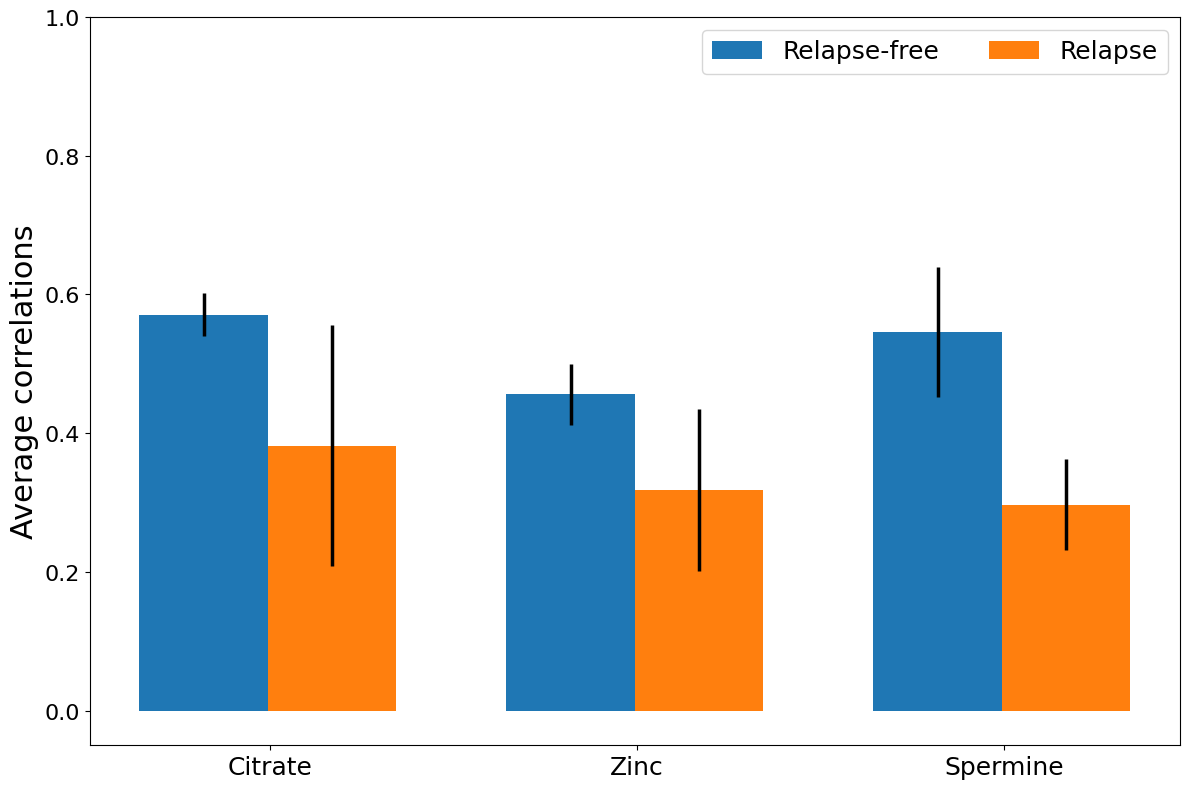

In [131]:

# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(12,8))
# states = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
# states_text = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
states = ('Citrate', 'Zinc', 'Spermine')
states_text = ('Citrate', 'Zinc', 'Spermine')
# data = {
#     'Relapse-free': (0.562, 0.4753, 0.514),
#     'Relapse': (0.335, 0.220, 0.386),
#     # '3': (189.95, 195.82, 217.19),
# }
# data = {
#     'Relapse-free': ((0.562, 0.4753, 0.514), np.array((0.040, 0.065, 0.097))),
#     'Relapse': ((0.335, 0.220, 0.386), np.array((0.160, 0.244, 0.134))),
#     # '3': (189.95, 195.82, 217.19),
# }
data = {
    'Relapse-free': ((0.571, 0.4563, 0.5459), np.array((0.031, 0.044, 0.0936))),
    'Relapse': ((0.382, 0.318, 0.297), np.array((0.174, 0.117, 0.066))),
}

x = np.arange(len(states))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data.items():
    offset = width * multiplier
    rects = axs.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], error_kw={'lw': 2.5} )
    # axs.bar_label(rects, padding=3, fontsize=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Average correlations', fontsize=22)
# ax.set_xlabel('
# ax.set_title('Penguin attributes by species')
axs.set_xticks(x + width-0.17, states_text, fontsize=18)
axs.legend(loc='upper right', ncols=3, fontsize=18)
axs.set_ylim(-0.05, 1)
axs.set_yticks(axs.get_yticks()[1:], ['{:.1f}'.format(x) for x in axs.get_yticks()[1:]], fontsize=16)

# plt.show()
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/relapse_relapsefree_barplot.png')

In [ ]:

data = {
    'Relapse-free': ((0.571, 0.4563, 0.5459), np.array((0.031, 0.044, 0.0936))),
    'Relapse': ((0.382, 0.318, 0.297), np.array((0.174, 0.117, 0.066))),
}

In [128]:
mm_df

index      mean    median       std  n        exp  experiment_no  \
0     control  0.571035  0.572604  0.031060  3   nc_2_cit              2   
1  recurrence  0.382694  0.335997  0.174140  3   nc_2_cit              2   
2         all  0.476864  0.555912  0.152176  6   nc_2_cit              2   
0     control  0.443209  0.455911  0.028775  3   nc_1_cit              1   
1  recurrence  0.280344  0.287341  0.058455  3   nc_1_cit              1   
2         all  0.361777  0.372628  0.098262  6   nc_1_cit              1   
0     control  0.329868  0.309165  0.129297  3   nw_2_cit              2   
1  recurrence  0.520236  0.520236       NaN  1   nw_2_cit              2   
2         all  0.377460  0.388716  0.142145  4   nw_2_cit              2   
0     control       NaN       NaN       NaN  0   nw_1_cit              1   
1  recurrence       NaN       NaN       NaN  0   nw_1_cit              1   
2         all       NaN       NaN       NaN  0   nw_1_cit              1   
0     control  0.456394  0.462778  0.044441  3  nc_2_zinc              2   
1  recurrence  0.317838  0.277560  0.117600  3  nc_2_zinc              2   
2         all  0.387116  0.429695  0.109914  6  nc_2_zinc              2   
0     control  0.357733  0.379895  0.046643  3  nc_1_zinc              1   
1  recurrence  0.237770  0.221644  0.043884  3  nc_1_zinc              1   
2         all  0.297751  0.295788  0.077188  6  nc_1_zinc              1   
0     control  0.274833  0.274833       NaN  1  nw_2_zinc              2   
1  recurrence  0.460741  0.460741       NaN  1  nw_2_zinc              2   
2         all  0.367787  0.367787  0.131457  2  nw_2_zinc              2   
0     control       NaN       NaN       NaN  0  nw_1_zinc              1   
1  recurrence -0.208669 -0.208669       NaN  1  nw_1_zinc              1   
2         all -0.208669 -0.208669       NaN  1  nw_1_zinc              1   
0     control  0.545934  0.533164  0.093661  3   pc_2_spe              2   
1  recurrence  0.430185  0.391216  0.137740  3   pc_2_spe              2   
2         all  0.488060  0.496238  0.122952  6   pc_2_spe              2   
0     control  0.487160  0.505271  0.034451  3   pc_1_spe              1   
1  recurrence  0.297801  0.296648  0.066423  4   pc_1_spe              1   
2         all  0.378954  0.360885  0.113342  7   pc_1_spe              1   
0     control  0.357950  0.357950  0.034919  2   pw_2_spe              2   
1  recurrence  0.424187  0.424187       NaN  1   pw_2_spe              2   
2         all  0.380029  0.382641  0.045521  3   pw_2_spe              2   
0     control       NaN       NaN       NaN  0   pw_1_spe              1   
1  recurrence       NaN       NaN       NaN  0   pw_1_spe              1   
2         all       NaN       NaN       NaN  0   pw_1_spe              1   

   correct  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False  
0     True  
1     True  
2     True  
0     True  
1     True  
2     True  
0    False  
1    False  
2    False  
0    False  
1    False  
2    False

In [92]:
def transpose_dict(dct, labels):
    dct2 = {x: [] for x in labels}
    for key in dct:
        for idx, label in enumerate(labels):
            dct2[label].append(dct[key][idx])
    return dct2 

In [122]:
d_dict = {
    'citrate': [],
    'zinc': [],
    'spermine': []
}
labels = ['NormIntMatchHist', 'NormIntWithoutMatchHist', 'ArtIntMatchHist', 'ArtIntWithoutMatchHist']
for exp_type in ['NormIntMatchHist', 'NormIntWithoutMatchHist', 'ArtIntMatchHist', 'ArtIntWithoutMatchHist']:
    metabolite = 'citrate'
    citrate_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    metabolite = 'zinc'
    zinc_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    metabolite = 'spermine'
    spermine_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    # d_dict[exp_type] = (citrate_vals, zinc_vals, spermine_vals)
    d_dict['citrate'].append(citrate_vals)
    d_dict['zinc'].append(zinc_vals)
    d_dict['spermine'].append(spermine_vals)

# exp_type = 'NormIntMatchHist'
# metabolite = 'citrate'
# d_dict[exp_type] = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()

IntMatchHist [0.43736992413844344, 0.3366536379670509, 0.4463521426169837]
IntWithoutMatchHist [0.3192626199803206, 0.25442015632199283, 0.378954423541924]
ArtIntMatchHist [0.23821868828458911, 0.1654717776333101, 0.21248106227812433]
ArtIntWithoutMatchHist [0.027119879337266662, 0.0071284153856605425, 0.025439099816220456]


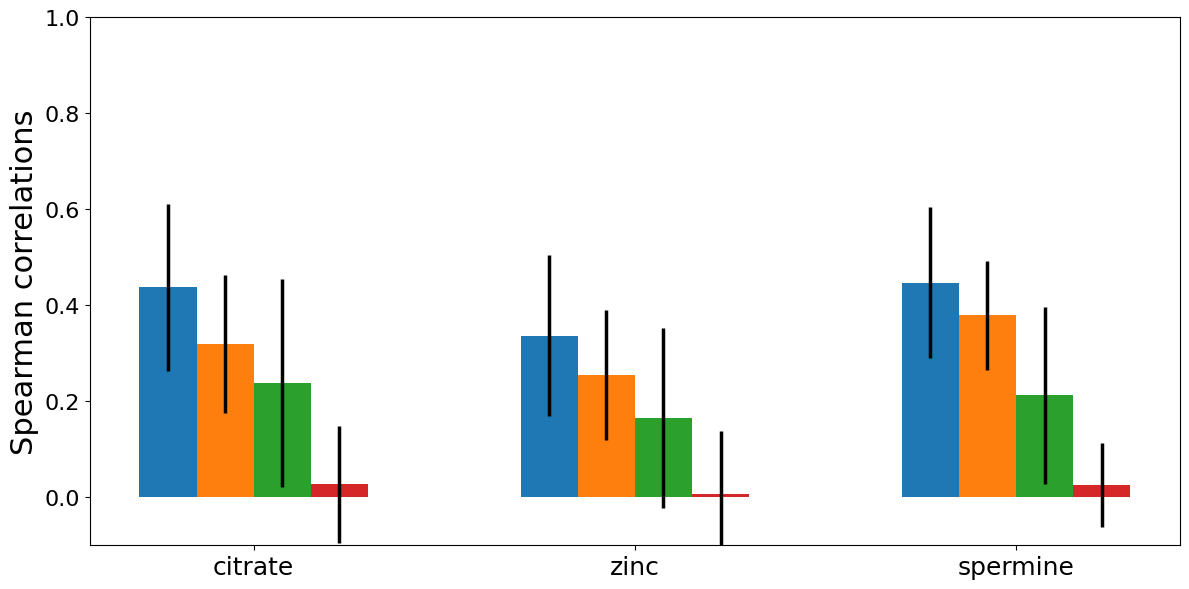

In [123]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(12,6))
# states = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
# states_text = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
# states = ('Citrate', 'Zinc', 'Spermine')
# states_text = ('Citrate', 'Zinc', 'Spermine')
states = ['IntMatchHist', 'IntWithoutMatchHist', 'ArtIntMatchHist', 'ArtIntWithoutMatchHist']
states_text = states
# data = {
#     'Relapse-free': (0.562, 0.4753, 0.514),
#     'Relapse': (0.335, 0.220, 0.386),
#     # '3': (189.95, 195.82, 217.19),
# }
d_dict = {
    'citrate': [],
    'zinc': [],
    'spermine': []
}
for exp_type in states:
    metabolite = 'citrate'
    citrate_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    metabolite = 'zinc'
    zinc_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    metabolite = 'spermine'
    spermine_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    # d_dict[exp_type] = (citrate_vals, zinc_vals, spermine_vals)
    d_dict['citrate'].append(citrate_vals)
    d_dict['zinc'].append(zinc_vals)
    d_dict['spermine'].append(spermine_vals)
d_dict = transpose_dict(d_dict,states)

derr_dict = {
    'citrate': [],
    'zinc': [],
    'spermine': []
}
for exp_type in states:
    metabolite = 'citrate'
    citrate_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].std()
    metabolite = 'zinc'
    zinc_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].std()
    metabolite = 'spermine'
    spermine_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].std()
    # d_dict[exp_type] = (citrate_vals, zinc_vals, spermine_vals)
    derr_dict['citrate'].append(citrate_vals)
    derr_dict['zinc'].append(zinc_vals)
    derr_dict['spermine'].append(spermine_vals)
derr_dict = transpose_dict(derr_dict,states)
states = ['citrate', 'zinc', 'spermine']
states_text = states
# data = {
#     'Relapse-free': ((0.562, 0.4753, 0.514), np.array((0.040, 0.065, 0.097))),
#     'Relapse': ((0.335, 0.220, 0.386), np.array((0.160, 0.244, 0.134))),
#     # '3': (189.95, 195.82, 217.19),
# }

x = np.arange(len(states))  # the label locations
# width = 0.35  # the width of the bars
width = 0.15  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in d_dict.items():
    err_measurement = derr_dict[attribute]
    print(attribute, measurement)
    offset = width * multiplier
    # rects = axs.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], error_kw={'lw': 2.5} )
    rects = axs.bar(x + offset, tuple(measurement), width, label=attribute, yerr=err_measurement, error_kw={'lw': 2.5})
    # axs.bar_label(rects, padding=3, fontsize=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Spearman correlations', fontsize=22)
# ax.set_xlabel('
# ax.set_title('Penguin attributes by species')
# axs.set_xticks(x + width-0.17, states_text, fontsize=18)
axs.set_xticks(x + width+0.075, states_text, fontsize=18)
# axs.legend(loc='upper right', ncols=1, fontsize=18)
axs.set_ylim(-0.1, 1)
axs.set_yticks(axs.get_yticks()[1:], ['{:.1f}'.format(x) for x in axs.get_yticks()[1:]], fontsize=16)

# plt.show()
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/comparison_int_datasets_corr.png')

IntMatchHist [6, 6, 6]
IntWithoutMatchHist [6, 6, 7]
ArtIntMatchHist [4, 2, 3]
ArtIntWithoutMatchHist [0, 1, 0]


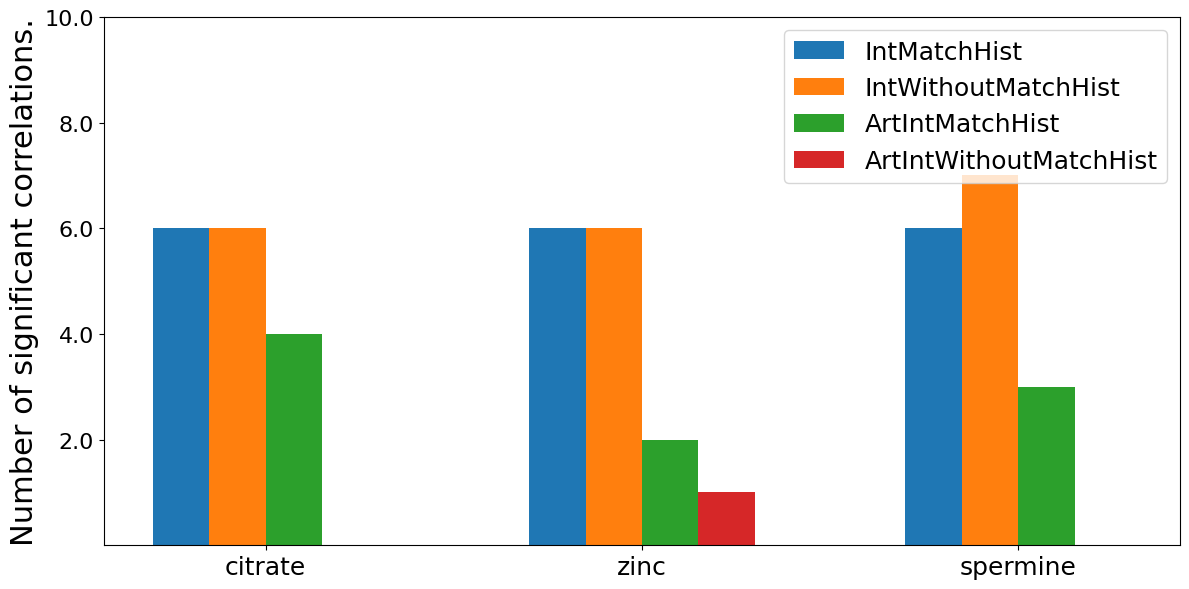

In [124]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(12,6))
# states = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
# states_text = ("NormIntMatchHist", "NormIntWithoutMatchHist", "ArtIntMatchHist", "ArtIntWithoutMatchHist")
# states = ('Citrate', 'Zinc', 'Spermine')
# states_text = ('Citrate', 'Zinc', 'Spermine')
states = ['IntMatchHist', 'IntWithoutMatchHist', 'ArtIntMatchHist', 'ArtIntWithoutMatchHist']
states_text = states
# data = {
#     'Relapse-free': (0.562, 0.4753, 0.514),
#     'Relapse': (0.335, 0.220, 0.386),
#     # '3': (189.95, 195.82, 217.19),
# }
d_dict = {
    'citrate': [],
    'zinc': [],
    'spermine': []
}
for exp_type in states:
    metabolite = 'citrate'
    sub_df = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)].pvalue
    citrate_vals = (sub_df < 0.0001).sum()
    # citrate_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    metabolite = 'zinc'
    sub_df = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)].pvalue
    zinc_vals = (sub_df < 0.0001).sum()
    # zinc_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    metabolite = 'spermine'
    sub_df = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)].pvalue
    spermine_vals = (sub_df < 0.0001).sum()
    # spermine_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
    # d_dict[exp_type] = (citrate_vals, zinc_vals, spermine_vals)
    d_dict['citrate'].append(citrate_vals)
    d_dict['zinc'].append(zinc_vals)
    d_dict['spermine'].append(spermine_vals)
d_dict = transpose_dict(d_dict,states)

states = ['citrate', 'zinc', 'spermine']
states_text = states
# data = {
#     'Relapse-free': ((0.562, 0.4753, 0.514), np.array((0.040, 0.065, 0.097))),
#     'Relapse': ((0.335, 0.220, 0.386), np.array((0.160, 0.244, 0.134))),
#     # '3': (189.95, 195.82, 217.19),
# }

x = np.arange(len(states))  # the label locations
# width = 0.35  # the width of the bars
width = 0.15  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in d_dict.items():
    print(attribute, measurement)
    offset = width * multiplier
    # rects = axs.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], error_kw={'lw': 2.5} )
    rects = axs.bar(x + offset, tuple(measurement), width, label=attribute, )
    # axs.bar_label(rects, padding=3, fontsize=16)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
axs.set_ylabel('Number of significant correlations.', fontsize=22)
# ax.set_xlabel('
# ax.set_title('Penguin attributes by species')
# axs.set_xticks(x + width-0.17, states_text, fontsize=18)
axs.set_xticks(x + width+0.075, states_text, fontsize=18)
axs.legend(loc='upper right', ncols=1, fontsize=18)
axs.set_ylim(0, 10)
axs.set_yticks(axs.get_yticks()[1:], ['{:.1f}'.format(x) for x in axs.get_yticks()[1:]], fontsize=16)

# plt.show()
fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/comparison_int_datasets_n_sigs.png')

In [85]:
def plot_average_rho_analysis3(ax):
    states = ['IntMatchHist', 'IntWithoutMatchHist', 'ArtIntMatchHist', 'ArtIntWithoutMatchHist']
    states_text = states
    d_dict = {
        'citrate': [],
        'zinc': [],
        'spermine': []
    }
    for exp_type in states:
        metabolite = 'citrate'
        citrate_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
        metabolite = 'zinc'
        zinc_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
        metabolite = 'spermine'
        spermine_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].mean()
        # d_dict[exp_type] = (citrate_vals, zinc_vals, spermine_vals)
        d_dict['citrate'].append(citrate_vals)
        d_dict['zinc'].append(zinc_vals)
        d_dict['spermine'].append(spermine_vals)
    d_dict = transpose_dict(d_dict,states)

    derr_dict = {
        'citrate': [],
        'zinc': [],
        'spermine': []
    }
    for exp_type in states:
        metabolite = 'citrate'
        citrate_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].std()
        metabolite = 'zinc'
        zinc_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].std()
        metabolite = 'spermine'
        spermine_vals = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)]['Spearman correlation'].std()
        # d_dict[exp_type] = (citrate_vals, zinc_vals, spermine_vals)
        derr_dict['citrate'].append(citrate_vals)
        derr_dict['zinc'].append(zinc_vals)
        derr_dict['spermine'].append(spermine_vals)
    derr_dict = transpose_dict(derr_dict,states)
    states = ['citrate', 'zinc', 'spermine']
    states_text = states

    x = np.arange(len(states))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0
    for attribute, measurement in d_dict.items():
        err_measurement = derr_dict[attribute]
        offset = width * multiplier
        rects = ax.bar(x + offset, tuple(measurement), width, label=attribute, yerr=err_measurement, error_kw={'lw': 2.5})
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('ρ', fontsize=22)
    ax.set_xticks(x + width+0.075, states_text, fontsize=18)
    ax.set_ylim(-0.1, 1)
    ax.set_yticks(ax.get_yticks()[1:], ['{:.1f}'.format(x) for x in ax.get_yticks()[1:]], fontsize=16)
    ax.legend(loc='upper right', ncols=1, fontsize=15)
    return ax

    # # plt.show()
    # fig.tight_layout()
    # plt.savefig('images/citsper_citrate_analysis/comparison_int_datasets_corr.png')
    
def plot_n_sigs_analysis3(ax):
    states = ['IntMatchHist', 'IntWithoutMatchHist', 'ArtIntMatchHist', 'ArtIntWithoutMatchHist']
    states_text = states
    d_dict = {
        'citrate': [],
        'zinc': [],
        'spermine': []
    }
    for exp_type in states:
        metabolite = 'citrate'
        sub_df = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)].pvalue
        citrate_vals = (sub_df < 0.0001).sum()
        metabolite = 'zinc'
        sub_df = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)].pvalue
        zinc_vals = (sub_df < 0.0001).sum()
        metabolite = 'spermine'
        sub_df = all_stats[(all_stats['Experiment type'] == exp_type) & (all_stats.metabolite == metabolite)].pvalue
        spermine_vals = (sub_df < 0.0001).sum()
        d_dict['citrate'].append(citrate_vals)
        d_dict['zinc'].append(zinc_vals)
        d_dict['spermine'].append(spermine_vals)
    d_dict = transpose_dict(d_dict,states)

    states = ['citrate', 'zinc', 'spermine']
    states_text = states
    x = np.arange(len(states))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0

    for attribute, measurement in d_dict.items():
        print(attribute, measurement)
        offset = width * multiplier
        rects = ax.bar(x + offset, tuple(measurement), width, label=attribute, )
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of significant ρ\'s', fontsize=22)
    ax.set_xticks(x + width+0.075, states_text, fontsize=18)
    ax.legend(loc='upper right', ncols=1, fontsize=15)
    ax.set_ylim(0, 10)
    ax.set_yticks(ax.get_yticks()[1:], ['{:.1f}'.format(x) for x in ax.get_yticks()[1:]], fontsize=16)
    

def plot_spot_dist_analysis3(axs):
    # states = ("Before Integration", "After Integration", "After artificial integration")
    # states_text = ('Before integration', 'After normal integration', 'After artificial integration')
    states = ("Without tissue\ntype matching", "Tissue type matching\nafter integration", "Tissue type matching\nafter artificial integration")
    states_text = states
    # states_text = ('Before integration', 'After normal integration', 'After artificial integration')
    data = {
        'Stroma': (2126, 1358, 948),
        'Glands': (1722, 1179, 810),
        # '3': (189.95, 195.82, 217.19),
    }

    x = np.arange(len(states))  # the label locations
    width = 0.35  # the width of the bars
    multiplier = 0

    # fig, ax = plt.subplots(layout='constrained')

    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = axs.bar(x + offset, measurement, width, label=attribute)
        axs.bar_label(rects, padding=3, fontsize=16)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    axs.set_ylabel('Number of spots', fontsize=22)
    axs.set_yticks(axs.get_yticks(), [str(int(x)) for x in axs.get_yticks()], fontsize=16)
    # ax.set_xlabel('
    # ax.set_title('Penguin attributes by species')
    axs.set_xticks(x + width-0.17, states_text, fontsize=14)
    axs.legend(loc='upper right', ncols=3, fontsize=18)
    axs.set_ylim(0, 2500)
    
def plot_rel_rel_free_analysis4(axs):
    states = ('Citrate', 'Zinc', 'Spermine')
    states_text = ('Citrate', 'Zinc', 'Spermine')
    # data = {
    #     'Relapse-free': ((0.562, 0.4753, 0.514), np.array((0.040, 0.065, 0.097))),
    #     'Relapse': ((0.335, 0.220, 0.386), np.array((0.160, 0.244, 0.134))),
    # }
    data = {
        'Relapse-free': ((0.571, 0.4563, 0.5459), np.array((0.031, 0.044, 0.0936))),
        'Relapse': ((0.382, 0.318, 0.297), np.array((0.174, 0.117, 0.066))),
    }

    x = np.arange(len(states))  # the label locations
    width = 0.35  # the width of the bars
    multiplier = 0
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = axs.bar(x + offset, measurement[0], width, label=attribute, yerr=measurement[1], error_kw={'lw': 2.5} )
        multiplier += 1

    axs.set_ylabel('mean ρ (CSGS - metabolites)', fontsize=20)
    axs.set_xticks(x + width-0.17, states_text, fontsize=18)
    axs.legend(loc='upper right', ncols=3, fontsize=18)
    axs.set_ylim(-0.05, 1)
    axs.set_yticks(axs.get_yticks()[1:], ['{:.1f}'.format(x) for x in axs.get_yticks()[1:]], fontsize=16)

# Print 4 subplots together
# fig, axs = plt.subplots(2, 2, figsize=(24, 14))
# plot_average_rho_analysis3(axs[0,0])
# plot_n_sigs_analysis3(axs[0,1])
# plot_spot_dist_analysis3(axs[1,0])
# plot_rel_rel_free_analysis4(axs[1,1])
# fig.tight_layout()
# fig.savefig('images/citsper_citrate_analysis/panel_2_lower_half.png', transparent=True)

# fig, axs = plt.subplots(1, 3, figsize=(24, 6))
# plot_average_rho_analysis3(axs[0])
# # plot_n_sigs_analysis3(axs[0,1])
# plot_spot_dist_analysis3(axs[1])
# plot_rel_rel_free_analysis4(axs[2])
# fig.tight_layout()
# fig.savefig('images/citsper_citrate_analysis/panel_2_lower_half.png', transparent=True)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
plot_average_rho_analysis3(axs[0])
# plot_n_sigs_analysis3(axs[0,1])
# plot_spot_dist_analysis3(axs[1])
plot_rel_rel_free_analysis4(axs[1])
fig.tight_layout()
fig.savefig('../../images/citsper_citrate_analysis/panel_2_lower_half.png', transparent=True)

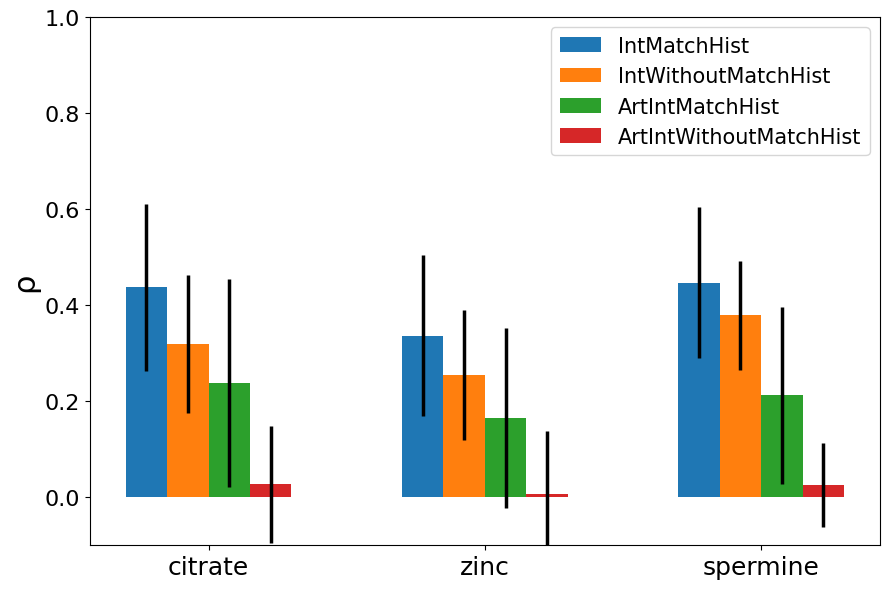

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(9, 6))
plot_average_rho_analysis3(axs)
# plot_n_sigs_analysis3(axs[0,1])
# plot_spot_dist_analysis3(axs[1])
# plot_rel_rel_free_analysis4(axs)
fig.tight_layout()
fig.savefig('../../images/citsper_citrate_analysis/panel_2_average_rhos.png', transparent=True)

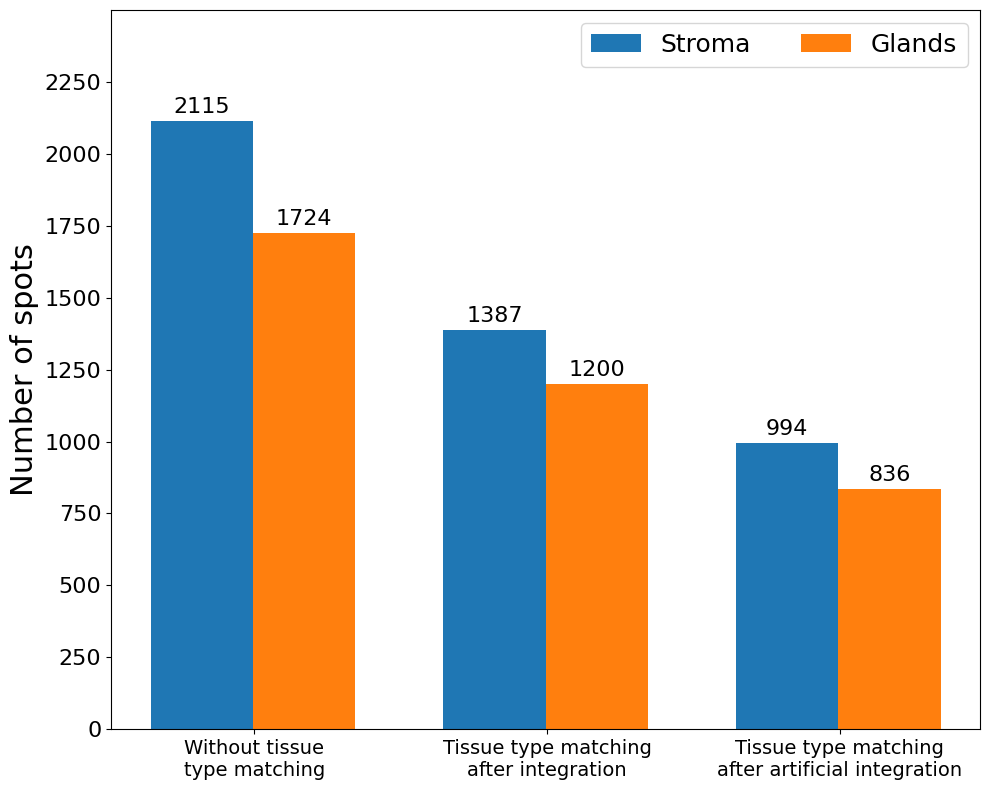

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
plot_spot_dist_analysis3(axs)
fig.tight_layout()
plt.savefig('images/citsper_citrate_analysis/number_spots_left.png')

In [99]:
['{:.1f}'.format(x) for x in axs.get_yticks()]

['-0.2', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0']

In [46]:
from collections import Counter

Counter(merged_pos_wrong_df_red2['Histology Class'])

Counter({'Stroma': 1095, 'Gland': 660})

In [154]:
core_ids_to_paper_ids = {
    '001_04': 'P06_7',
    '002_01': 'P04_3',
    '003_02': 'P08_3',
    '004_03': 'P07_7',
    '045_03': 'P28_3',
    '047_04': 'P30_4',
    '048_02': 'P22_4'
}

plot_order =['P06_7', 'P04_3', 'P08_3', 'P07_7', 'P28_3', 'P30_4', 'P22_4']
merged_neg_correct_df_red2['paper_id'] = merged_neg_correct_df_red2.core_name.apply(lambda x: core_ids_to_paper_ids[x])
merged_pos_correct_df_red2['paper_id'] = merged_pos_correct_df_red2.core_name.apply(lambda x: core_ids_to_paper_ids[x])
merged_neg_correct_df_red['paper_id'] = merged_neg_correct_df_red.core_name.apply(lambda x: core_ids_to_paper_ids[x])
merged_pos_correct_df_red['paper_id'] = merged_pos_correct_df_red.core_name.apply(lambda x: core_ids_to_paper_ids[x])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


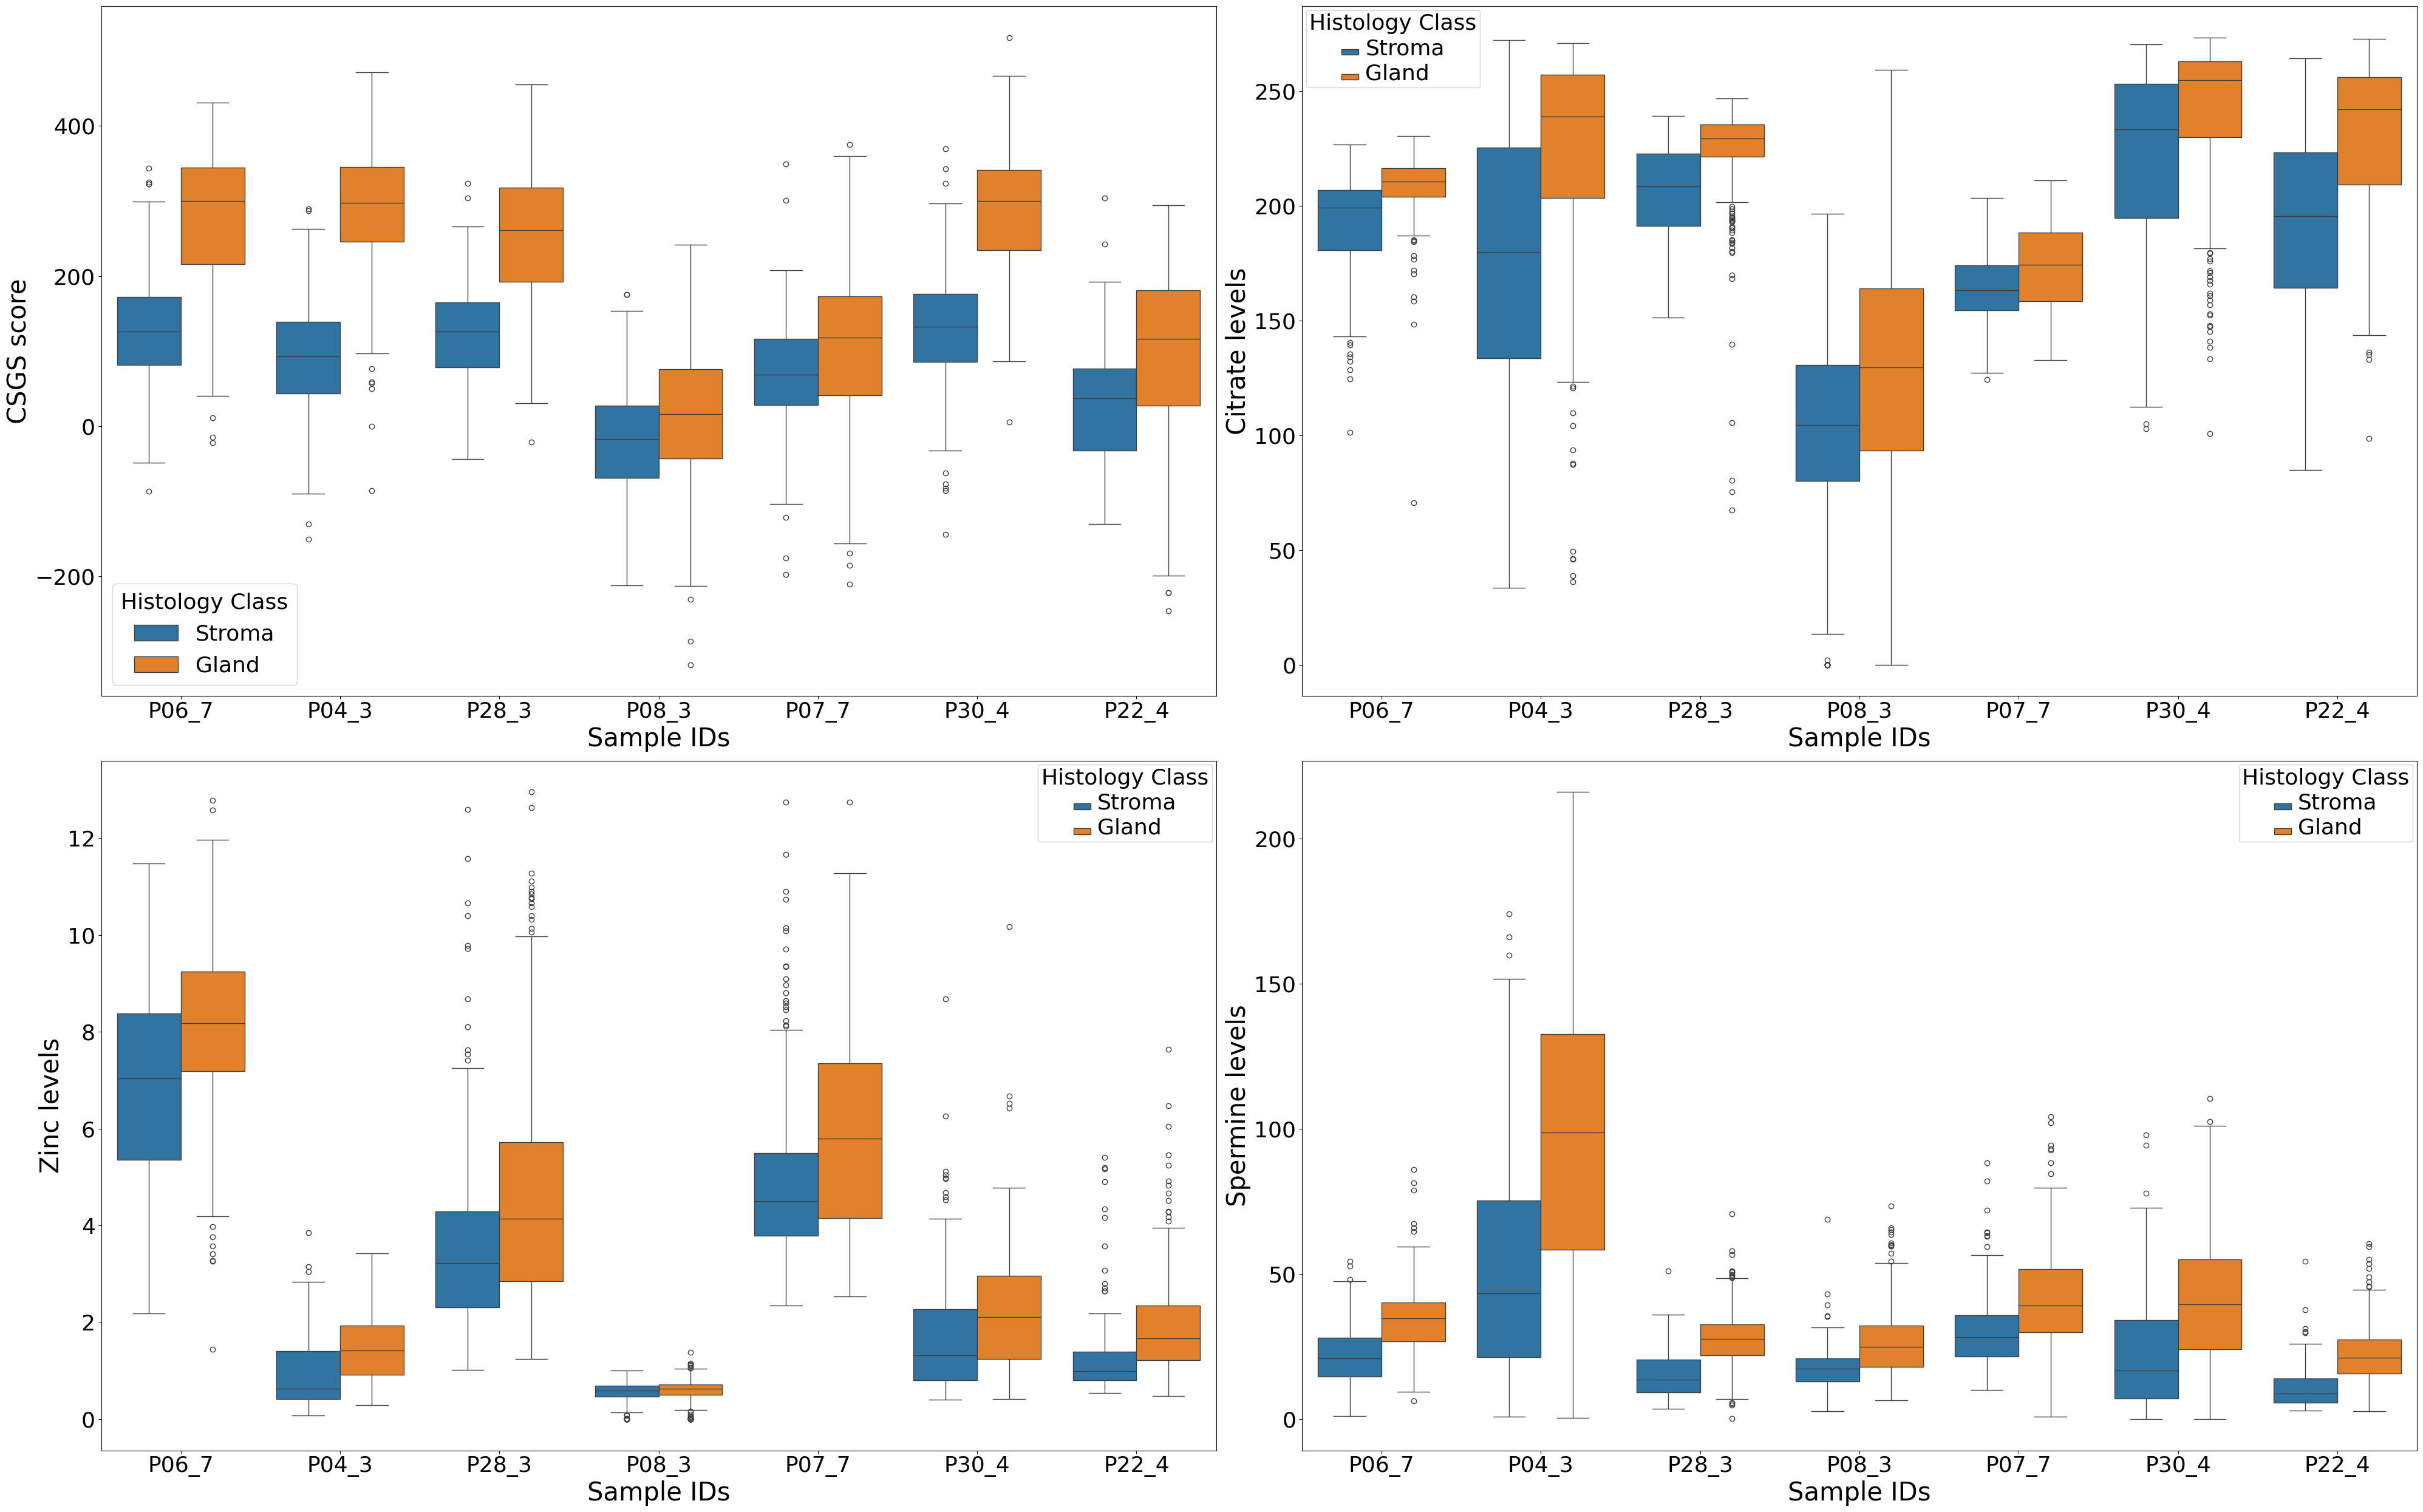

In [155]:
order = ['P06_7', 'P04_3', 'P28_3', 'P08_3', 'P07_7', 'P30_4', 'P22_4']
fontsize=30
tick_fontsize=26
legend_fontsize=26
fig, axs = plt.subplots(2, 2, figsize=(40, 25))
ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='Citsper', hue='unified_hp_class', hue_order=['Stroma', 'Gland'], order=order, ax=axs[0,0])
# ax.legend([],[], frameon=False)
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('CSGS score', fontsize=fontsize)
# ax.set_title('Sample-wise CSGS score', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title
ax.legend(title='Histology Class', loc='lower left', fontsize=legend_fontsize, title_fontsize=legend_fontsize )
# legend = ax.legend()
# legend.set_title('Histology Class', prop={'size': legend_fontsize})

ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='met_Citrate', hue='Histology Class',hue_order=['Stroma', 'Gland'], order=order,  ax=axs[0,1])
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('Citrate levels', fontsize=fontsize)
# ax.set_title('Sample-wise Citrate levels', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title

ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='met_Zinc', hue='Histology Class',hue_order=['Stroma', 'Gland'], order=order,  ax=axs[1,0])
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('Zinc levels', fontsize=fontsize)
# ax.set_title('Sample-wise Zinc levels', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title

ax = sns.boxplot(merged_pos_correct_df_red, x='paper_id', y='met_Spermine', hue='Histology Class',hue_order=['Stroma', 'Gland'], order=order,  ax=axs[1,1])
ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('Spermine levels', fontsize=fontsize)
# ax.set_title('Sample-wise Spermine levels', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title

fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/cczs_levels_boxplot_dif_layout.png', transparent=True)



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

set_ticklabels() should only be used

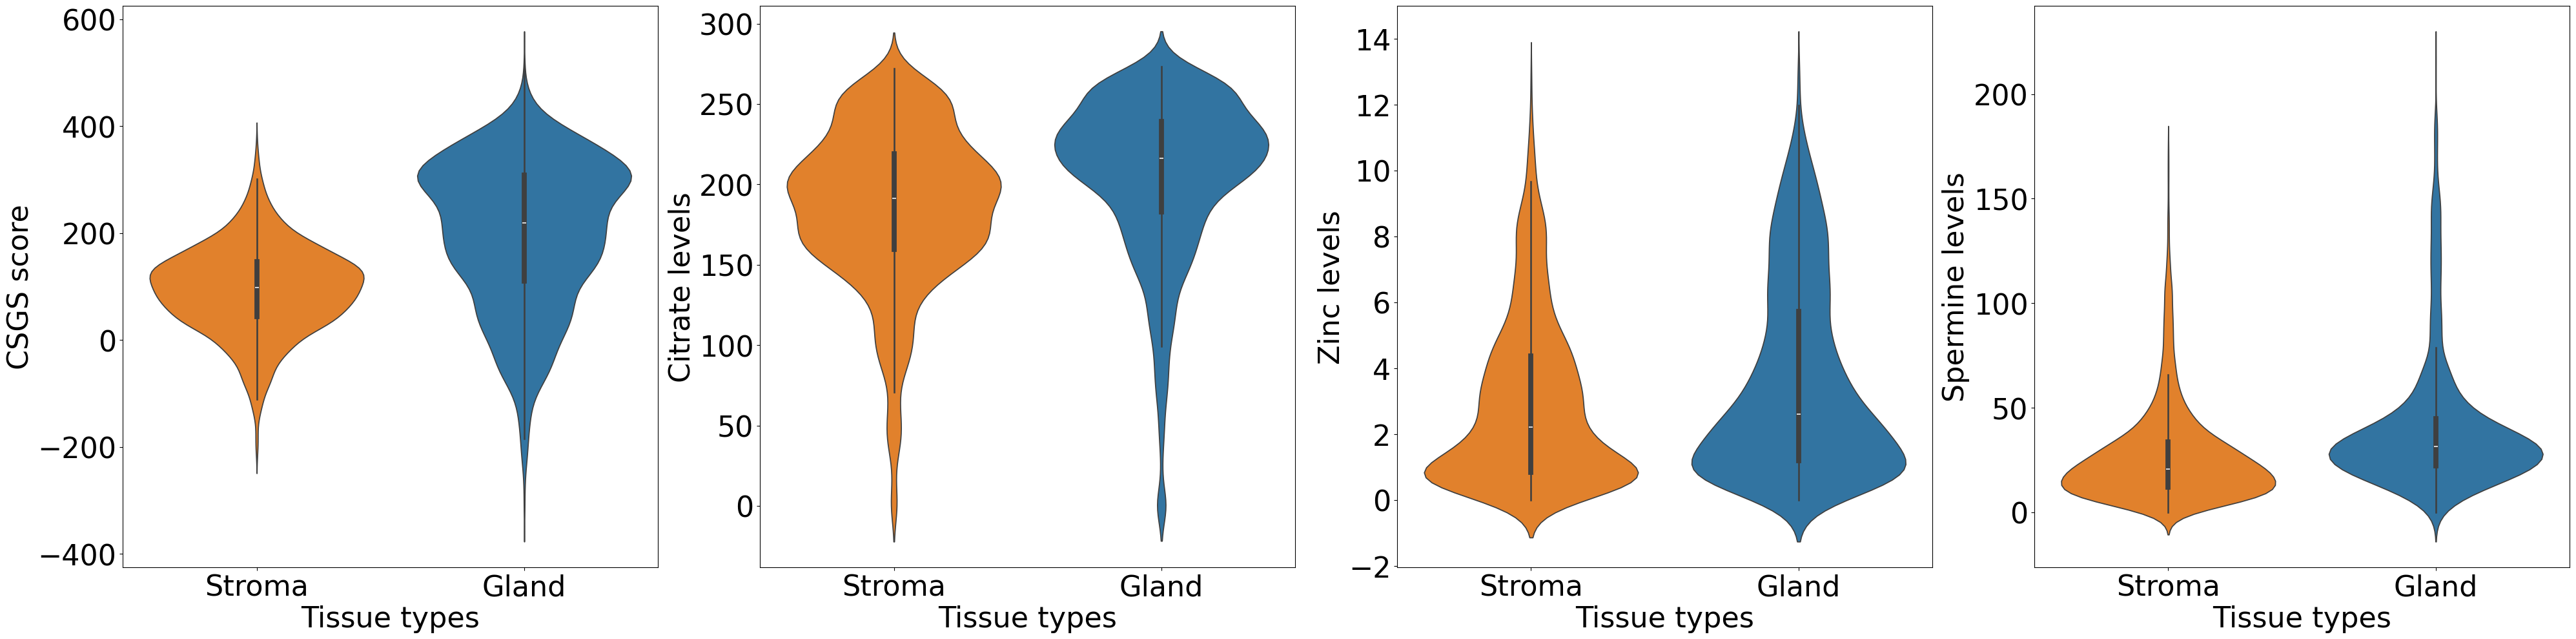

In [156]:
cmap = {'Stroma': 'tab:orange', 'Gland': 'tab:blue'}
order = ['P06_7', 'P04_3', 'P28_3', 'P08_3', 'P07_7', 'P30_4', 'P22_4']
fontsize=32
tick_fontsize=32
legend_fontsize=32
fig, axs = plt.subplots(1, 4, figsize=(40, 10))
# ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='Citsper', hue='unified_hp_class', hue_order=['Stroma', 'Gland'], order=order, ax=axs[0,0])
# ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='Citsper', hue='unified_hp_class', hue_order=['Stroma', 'Gland'], order=order, ax=axs[0,0])
ax = sns.violinplot(merged_neg_correct_df_red, x='unified_hp_class', y='Citsper', order=['Stroma', 'Gland'], ax=axs[0], palette=cmap)
# ax.legend([],[], frameon=False)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('CSGS score', fontsize=fontsize)
ax.set_xlabel('Tissue types', fontsize=fontsize)
# ax.set_title('Sample-wise CSGS score', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
# plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title
# ax.legend(title='Histology Class', loc='lower left', fontsize=legend_fontsize, title_fontsize=legend_fontsize )
# legend = ax.legend()
# legend.set_title('Histology Class', prop={'size': legend_fontsize})

# ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='met_Citrate', hue='Histology Class',hue_order=['Stroma', 'Gland'], order=order,  ax=axs[0,1])
ax = sns.violinplot(merged_neg_correct_df_red, x='unified_hp_class', y='met_Citrate', order=['Stroma', 'Gland'], ax=axs[1], palette=cmap)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('Citrate levels', fontsize=fontsize)
ax.set_xlabel('Tissue types', fontsize=fontsize)
# ax.set_title('Sample-wise Citrate levels', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
# plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title

# ax = sns.boxplot(merged_neg_correct_df_red, x='paper_id', y='met_Zinc', hue='Histology Class',hue_order=['Stroma', 'Gland'], order=order,  ax=axs[1,0])
ax = sns.violinplot(merged_neg_correct_df_red, x='unified_hp_class', y='met_Zinc', order=['Stroma', 'Gland'], ax=axs[2], palette=cmap)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('Zinc levels', fontsize=fontsize)
ax.set_xlabel('Tissue types', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
# plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title

# ax = sns.boxplot(merged_pos_correct_df_red, x='paper_id', y='met_Spermine', hue='Histology Class',hue_order=['Stroma', 'Gland'], order=order,  ax=axs[1,1])
ax = sns.violinplot(merged_pos_correct_df_red, x='unified_hp_class', y='met_Spermine', order=['Stroma', 'Gland'], ax=axs[3], palette=cmap)
# ax.set_xlabel('Sample IDs', fontsize=fontsize)
ax.set_ylabel('Spermine levels', fontsize=fontsize)
ax.set_xlabel('Tissue types', fontsize=fontsize)
ax.set_xticklabels(ax.get_xticklabels(), size=tick_fontsize)
ax.set_yticklabels(ax.get_yticklabels(), size=tick_fontsize)
# plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize) # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize=legend_fontsize) # for legend title

fig.tight_layout()
plt.savefig('../../images/citsper_citrate_analysis/cczs_all_samples.png', transparent=True)

In [157]:
from scipy.stats import mannwhitneyu

def compute_log_fold_change(d1, d2, pseudo_count=0):
    return np.log2(d1 + pseudo_count) - np.log2(d2 + pseudo_count)

In [158]:
merged_neg_correct_df_red.shape, merged_neg_correct_df_red2.shape

((3848, 2510), (2537, 2510))

In [159]:
(merged_neg_correct_df_red.unified_hp_class == 'Gland').sum(), (merged_neg_correct_df_red.unified_hp_class == 'Stroma').sum()

(2126, 1722)

In [160]:
# Do log fold change only for citrate, zinc and spermine

paper_id_to_citrate_fold_change = {}
paper_id_to_zinc_fold_change = {}
paper_id_to_spermine_fold_change = {}
paper_id_to_citrate_stats = {}
paper_id_to_zinc_stats = {}
paper_id_to_spermine_stats = {}
paper_id_to_fold_change = {}
for paper_id in merged_neg_correct_df_red.paper_id.unique():

    sample_df = merged_neg_correct_df_red[merged_neg_correct_df_red.paper_id == paper_id]
    group1 = sample_df[sample_df.unified_hp_class == 'Stroma'].Citsper
    group2 = sample_df[sample_df.unified_hp_class == 'Gland'].Citsper
    # lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    # paper_id_to_citrate_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('csgs', paper_id)]  = [np.NAN, m_stats.statistic, m_stats.pvalue]

    sample_df = merged_neg_correct_df_red[merged_neg_correct_df_red.paper_id == paper_id]
    group1 = sample_df[sample_df.msi_hist == 'Stroma'].met_Citrate
    group2 = sample_df[sample_df.msi_hist == 'Gland'].met_Citrate
    lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    paper_id_to_citrate_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('citrate', paper_id)]  = [lfc, m_stats.statistic, m_stats.pvalue]

    group1 = sample_df[sample_df.msi_hist == 'Stroma'].met_Zinc
    group2 = sample_df[sample_df.msi_hist == 'Gland'].met_Zinc
    lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    paper_id_to_zinc_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('zinc', paper_id)]  = [lfc, m_stats.statistic, m_stats.pvalue]

    sample_df = merged_pos_correct_df_red[merged_pos_correct_df_red.paper_id == paper_id]
    group1 = sample_df[sample_df.msi_hist == 'Stroma'].met_Spermine
    group2 = sample_df[sample_df.msi_hist == 'Gland'].met_Spermine
    lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    paper_id_to_spermine_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('spermine', paper_id)]  = [lfc, m_stats.statistic, m_stats.pvalue]
    

In [161]:
paper_id_to_citrate_fold_change = {}
paper_id_to_zinc_fold_change = {}
paper_id_to_spermine_fold_change = {}
paper_id_to_citrate_stats = {}
paper_id_to_zinc_stats = {}
paper_id_to_spermine_stats = {}
paper_id_to_fold_change = {}
for paper_id in merged_neg_correct_df_red.paper_id.unique():

    sample_df = merged_neg_correct_df_red[merged_neg_correct_df_red.paper_id == paper_id]
    group1 = sample_df[sample_df.unified_hp_class == 'Stroma'].Citsper
    group2 = sample_df[sample_df.unified_hp_class == 'Gland'].Citsper
    # lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    # paper_id_to_citrate_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('csgs', paper_id)]  = [np.NAN, m_stats.statistic, m_stats.pvalue]

    sample_df = merged_neg_correct_df_red[merged_neg_correct_df_red.paper_id == paper_id]
    group1 = sample_df[sample_df.msi_hist == 'Stroma'].met_Citrate
    group2 = sample_df[sample_df.msi_hist == 'Gland'].met_Citrate
    lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    paper_id_to_citrate_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('citrate', paper_id)]  = [lfc, m_stats.statistic, m_stats.pvalue]

    group1 = sample_df[sample_df.msi_hist == 'Stroma'].met_Zinc
    group2 = sample_df[sample_df.msi_hist == 'Gland'].met_Zinc
    lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    paper_id_to_zinc_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('zinc', paper_id)]  = [lfc, m_stats.statistic, m_stats.pvalue]

    sample_df = merged_pos_correct_df_red[merged_pos_correct_df_red.paper_id == paper_id]
    group1 = sample_df[sample_df.msi_hist == 'Stroma'].met_Spermine
    group2 = sample_df[sample_df.msi_hist == 'Gland'].met_Spermine
    lfc = compute_log_fold_change(group1.mean(), group2.mean())
    m_stats = mannwhitneyu(group1, group2)
    paper_id_to_spermine_fold_change[paper_id] = [lfc, m_stats.statistic, m_stats.pvalue]
    paper_id_to_fold_change[('spermine', paper_id)]  = [lfc, m_stats.statistic, m_stats.pvalue]
    

In [162]:
group1 = merged_neg_correct_df_red[merged_neg_correct_df_red.unified_hp_class == 'Stroma'].met_Citrate
group2 = merged_neg_correct_df_red[merged_neg_correct_df_red.unified_hp_class == 'Gland'].met_Citrate
m_stats = mannwhitneyu(group1, group2)
m_stats

MannwhitneyuResult(statistic=1322311.5, pvalue=9.421677915017248e-50)

In [163]:
group1 = merged_neg_correct_df_red[merged_neg_correct_df_red.unified_hp_class == 'Stroma'].met_Zinc
group2 = merged_neg_correct_df_red[merged_neg_correct_df_red.unified_hp_class == 'Gland'].met_Zinc
m_stats = mannwhitneyu(group1, group2)
m_stats

MannwhitneyuResult(statistic=1585224.5, pvalue=8.230264669337728e-13)

In [164]:
group1 = merged_pos_correct_df_red[merged_pos_correct_df_red.unified_hp_class == 'Stroma'].met_Spermine
group2 = merged_pos_correct_df_red[merged_pos_correct_df_red.unified_hp_class == 'Gland'].met_Spermine
m_stats = mannwhitneyu(group1, group2)
m_stats

MannwhitneyuResult(statistic=1098904.0, pvalue=3.2145793827601642e-74)

In [165]:
group1 = merged_neg_correct_df_red[merged_neg_correct_df_red.unified_hp_class == 'Stroma'].Citsper
group2 = merged_neg_correct_df_red[merged_neg_correct_df_red.unified_hp_class == 'Gland'].Citsper
m_stats = mannwhitneyu(group1, group2)
m_stats

MannwhitneyuResult(statistic=927924.0, pvalue=6.904697523110662e-153)

In [167]:
pd.set_option('display.precision', 3)
# pd.options.display.float_format = '{:.0f}'.format

In [168]:
def convert_pvalue_string(n, dp = 3):
    if 'E' in n:
        f, s = n.split('E')
        s_idx = f.find('.')
        f = f[:s_idx+dp+1]
        f = f + 'E' + s
    else:
        s_idx = n.find('.')
        f = n[:s_idx+dp+1]
    return f

# citrate_fc_df = pd.DataFrame(paper_id_to_citrate_fold_change, index=['fc', 'statistic', 'pvalue'])
# zinc_fc_df = pd.DataFrame(paper_id_to_zinc_fold_change, index=['fc', 'statistic', 'pvalue'])
# spermine_fc_df = pd.DataFrame(paper_id_to_spermine_fold_change, index=['fc', 'statistic', 'pvalue'])
# citrate_fc_df['metabolite'] = 'citrate'
# zinc_fc_df['metabolite'] = 'zinc'
# spermine_fc_df['metabolite'] = 'spermine'
fc_df = pd.DataFrame(paper_id_to_fold_change, index=['fc', 'statistic', 'pvalue']).transpose().sort_index()
# fc_df['pvalue']
fc_df.pvalue = fc_df.pvalue.astype(str).str.replace('e', 'E').apply(lambda x: convert_pvalue_string(x))
fc_df.fc = fc_df.fc.astype(str).str.replace('e', 'E').apply(lambda x: convert_pvalue_string(x))
fc_df

fc  statistic     pvalue
citrate  P04_3  -0.492     6779.0  5.816E-46
         P06_7  -0.137     9632.0  8.974E-46
         P07_7  -0.149    12960.0  5.739E-21
         P08_3  -0.800     3965.0  2.067E-19
         P22_4  -0.244     6844.0  1.488E-17
         P28_3  -0.153    20597.0  3.376E-53
         P30_4  -0.257     9607.0  5.528E-55
csgs     P04_3     nan     4796.0  1.809E-89
         P06_7     nan     7648.0  4.368E-52
         P07_7     nan    26470.0  4.700E-07
         P08_3     nan    11677.0  6.690E-05
         P22_4     nan     8897.0  3.667E-10
         P28_3     nan    14276.0  1.554E-64
         P30_4     nan     7289.0  1.103E-73
spermine P04_3  -1.009     3594.0  8.023E-20
         P06_7  -0.563    12611.0  2.392E-27
         P07_7  -0.752     4440.0  1.005E-24
         P08_3  -0.642     4627.0  7.527E-18
         P22_4  -1.028     4029.0  8.585E-33
         P28_3  -0.871    14308.0  5.501E-67
         P30_4  -1.337     6871.0  3.015E-55
zinc     P04_3  -1.167     6058.0  1.554E-48
         P06_7  -0.277    20133.0  3.669E-16
         P07_7  -0.533    10564.0  7.098E-28
         P08_3  -0.411     7972.0      0.000
         P22_4  -0.495     7512.0  6.143E-15
         P28_3  -0.468    39872.0  6.885E-17
         P30_4  -0.875    12576.0  9.153E-46

In [139]:
fc_df.to_csv('fc_gland_stroma.csv')

In [81]:
# Citrate Spermine correlation

In [82]:
# nc_1_cit_core_sp_stats = get_basic_stats(merged_neg_correct_df_red, src_col, dst_neg_col, c_type)

In [140]:
merged_neg_correct_df_red.set_index('copy_index', inplace=True)
merged_pos_correct_df_red.set_index('copy_index', inplace=True)

KeyError: "None of ['copy_index'] are in the columns"

In [172]:
merged_neg_correct_df_red['met_Spermine'] = merged_pos_correct_df_red['met_Spermine']
merged_pn_c_df_red = merged_neg_correct_df_red.copy()
print(merged_pn_c_df_red.shape[0])
merged_pn_c_df_red = merged_pn_c_df_red[~merged_pn_c_df_red['met_Spermine'].isna()]
print(merged_pn_c_df_red.shape[0])

3848
3626


In [173]:
merged_neg_correct_df_red2['met_Spermine'] = merged_pos_correct_df_red2['met_Spermine']
merged_pn_c_df_red2 = merged_neg_correct_df_red2.copy()
print(merged_pn_c_df_red2.shape[0])
merged_pn_c_df_red2 = merged_pn_c_df_red2[~merged_pn_c_df_red2['met_Spermine'].isna()]
print(merged_pn_c_df_red2.shape[0])

2537
2051



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [174]:
merged_neg_correct_df_red.recurrence

V10A20_008_C_TGAGTAAATTAGCGTA-1       control
V10A20_008_C_TGAGAGATTTACCACG-1       control
V10A20_008_C_TGACTATAATCCTTTC-1       control
V10A20_008_C_TGACGATGCACTAGAA-1       control
V10A20_008_C_TGACATCGAGCGGACC-1       control
                                      ...    
V10A20_009_B_TCCTCGGGCTGGGCTT-1    recurrence
V10A20_009_B_TCGAAATTTAGGACCA-1    recurrence
V10A20_009_B_TCGAGACCAACACCGT-1    recurrence
V10A20_009_B_TCGCAAAGATGCATTT-1    recurrence
V10A20_009_B_TCGCACCAGGAGGCAG-1    recurrence
Name: recurrence, Length: 3848, dtype: object

In [175]:
src_col = 'met_Citrate'
dst_col = 'met_Spermine'
get_basic_stats(merged_pn_c_df_red, src_col, dst_col, c_type)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


statistic      pvalue    n
core_name                              
001_04    0      0.713   2.928e-78  496
002_01    0      0.767  7.994e-118  603
003_02    0      0.385   2.798e-15  392
004_03    0      0.596   3.857e-48  487
045_03    0      0.696  2.018e-102  699
047_04    0      0.740  2.393e-102  585
048_02    0      0.828   7.277e-93  364

In [144]:
src_col = 'met_Citrate'
dst_col = 'met_Spermine'
stats_citrate_spermine = get_basic_stats(merged_pn_c_df_red2, src_col, dst_col, c_type)
stats_citrate_spermine.index = [x[0] for x in stats_citrate_spermine.index]
stats_citrate_spermine['sample_id'] = core_ids_to_paper_ids
stats_citrate_spermine.set_index('sample_id').to_csv('citrate_spermine_correlations.csv')

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [145]:
core_ids_to_paper_ids

{'001_04': 'P06_7',
 '002_01': 'P04_3',
 '003_02': 'P08_3',
 '004_03': 'P07_7',
 '045_03': 'P28_3',
 '047_04': 'P30_4',
 '048_02': 'P22_4'}

In [90]:
stats_citrate_spermine.n.sum()

2172

In [146]:
src_col = 'met_Citrate'
dst_col = 'met_Zinc'
stats_citrate_zinc = get_basic_stats(merged_pn_c_df_red2, src_col, dst_col, c_type)
stats_citrate_zinc

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


statistic        pvalue    n
core_name                                
001_04    0   0.622682  1.852096e-31  280
002_01    0   0.742085  1.454430e-50  282
003_02    0   0.321197  1.297233e-04  137
004_03    0   0.742447  4.916790e-52  290
045_03    0   0.396370  2.143797e-19  477
047_04    0   0.819308  1.435395e-78  319
048_02    0   0.700782  1.316871e-40  266

In [147]:
src_col = 'met_Spermine'
dst_col = 'met_Zinc'
stats_spermine_zinc = get_basic_stats(merged_pn_c_df_red2, src_col, dst_col, c_type)
stats_spermine_zinc

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


statistic        pvalue    n
core_name                                
001_04    0   0.657527  4.760629e-36  280
002_01    0   0.688983  4.959372e-41  282
003_02    0   0.039008  6.508613e-01  137
004_03    0   0.389650  5.955544e-12  290
045_03    0   0.369607  6.906392e-17  477
047_04    0   0.659868  3.003284e-41  319
048_02    0   0.667052  1.304889e-35  266

In [148]:
core_name = '001_04'
cola = merged_pn_c_df_red[merged_pn_c_df_red.core_name == core_name]['met_Citrate']
cola = merged_pn_c_df_red[merged_pn_c_df_red.core_name == core_name]['met_Citrate']

In [176]:
group_col = 'recurrence'
src_col = 'Citsper'
citrate_rec_stats = get_basic_stats(merged_neg_correct_df_red2, src_col, dst_neg_col, c_type, group_col=group_col)
zinc_rec_stats = get_basic_stats(merged_neg_correct_df_red2, src_col, dst_neg_col2, c_type, group_col=group_col)
spe_rec_stats = get_basic_stats(merged_pos_correct_df_red2, src_col, dst_pos_col, c_type, group_col=group_col)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [150]:
src_col

'Citsper'

In [151]:
dst_pos_col

'met_Spermine'

In [177]:
citrate_rec_stats

statistic      pvalue     n
recurrence                               
control    0      0.567  7.937e-111  1295
recurrence 0      0.500   1.397e-79  1242

In [178]:
zinc_rec_stats

statistic     pvalue     n
recurrence                              
control    0      0.438  6.859e-62  1295
recurrence 0      0.177  3.499e-10  1242

In [179]:
spe_rec_stats

statistic     pvalue     n
recurrence                              
control    0      0.294  1.437e-26  1259
recurrence 0      0.271  3.990e-22  1227

In [155]:
spe_rec_stats = get_basic_stats(merged_pos_correct_df_red2, src_col, dst_pos_col, c_type, group_col=group_col)

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


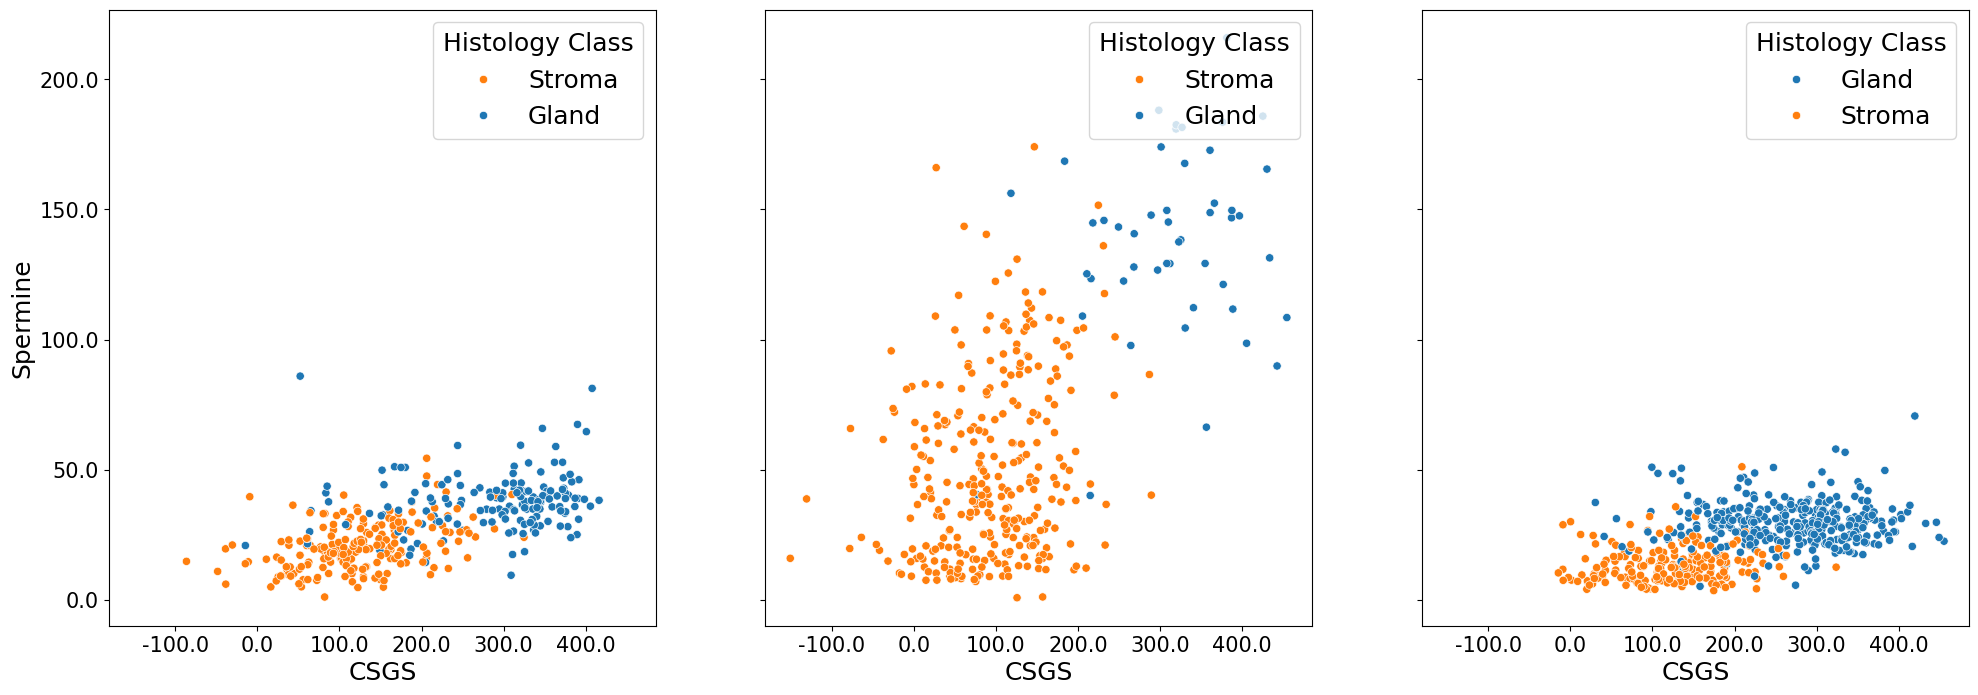

In [156]:
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_names = merged_pos_correct_df_red2.core_name.unique()
core_names = ['001_04', '002_01', '045_03']
_, axs = plt.subplots(1, len(core_names), figsize=(8*len(core_names), 8), sharex=True, sharey=True)
for idx, core_name in enumerate(core_names):
    ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[idx])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Spermine', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
    # plt.savefig('images/citsper_citrate_analysis/scatterplot_csgs_czs.png', transparent=True)

array(['control'], dtype=object)

In [115]:
a = merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(['001_04', '045_03', '002_01'])]
scipy.stats.spearmanr(a['Citsper'], a['met_Spermine'])

SignificanceResult(statistic=0.269563631519263, pvalue=8.480309510815246e-23)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


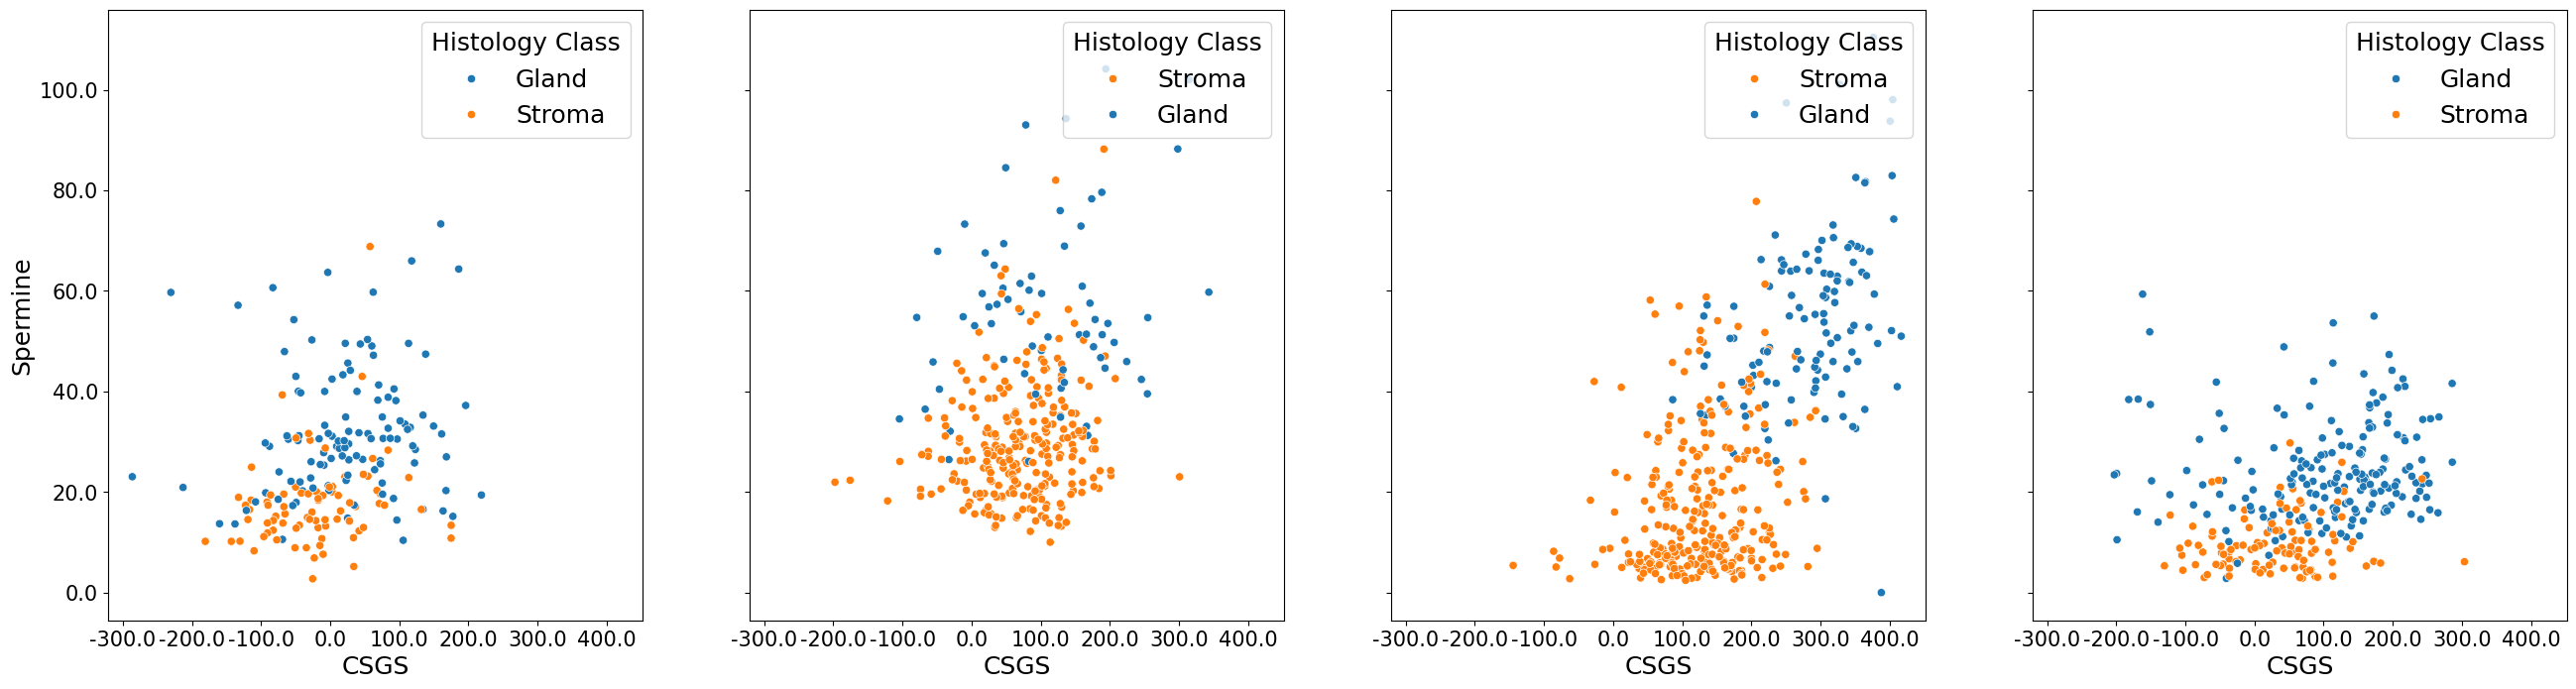

In [157]:
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_names = merged_pos_correct_df_red2.core_name.unique()
core_names = ['003_02', '004_03', '047_04', '048_02']
_, axs = plt.subplots(1, len(core_names), figsize=(8*len(core_names), 8), sharex=True, sharey=True)
for idx, core_name in enumerate(core_names):
    ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name == core_name], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[idx])
    ax.set_xlabel('CSGS', fontsize=fontsize)
    ax.set_ylabel('Spermine', fontsize=fontsize)
    ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
    ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
    # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
    # plt.savefig('images/citsper_citrate_analysis/scatterplot_csgs_czs.png', transparent=True)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


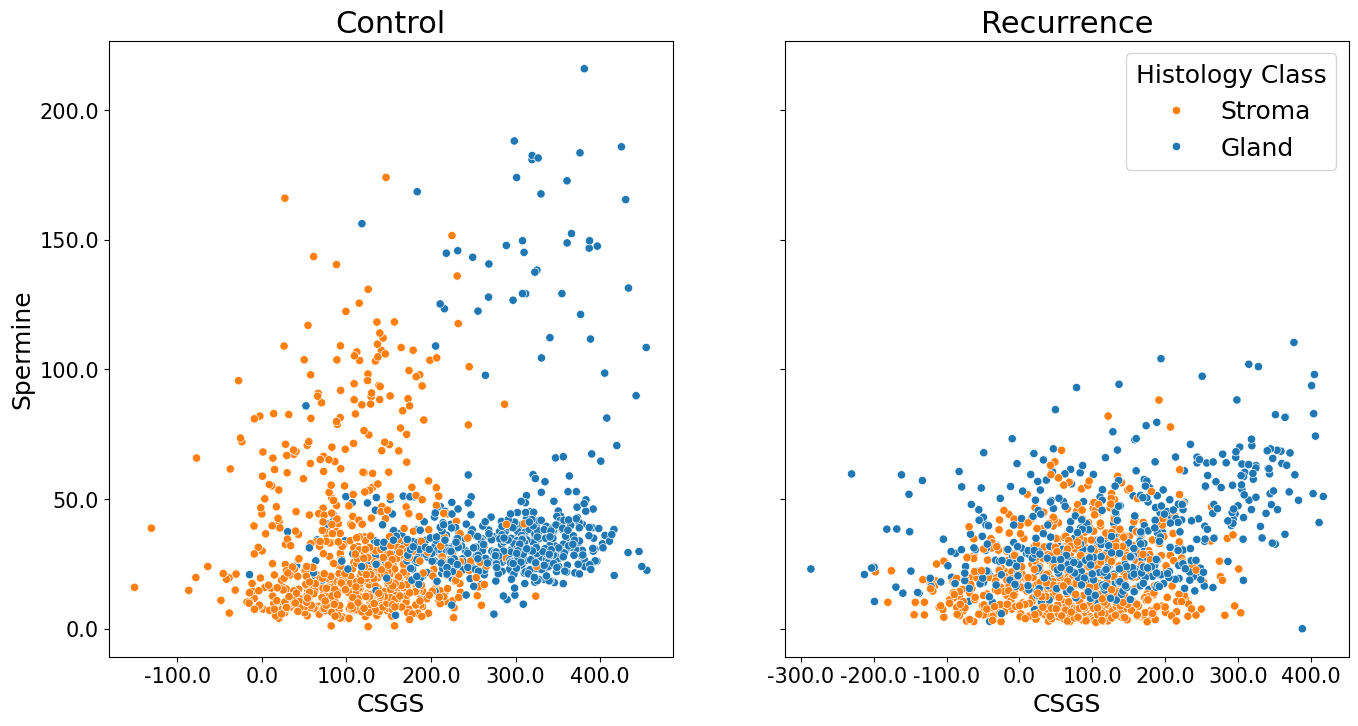

In [158]:
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_names = merged_pos_correct_df_red2.core_name.unique()
core_names = ['001_04', '002_01', '045_03']
_, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[0])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Spermine', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
ax.legend([],[], frameon=False)
ax.set_title('Control', fontsize=22)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)

core_names = ['003_02', '004_03', '047_04', '048_02']
ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[1])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Spermine', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
ax.set_title('Recurrence', fontsize=22)
plt.savefig('../../images/citsper_citrate_analysis/scatterplot_csgs_spermine.png', transparent=True)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


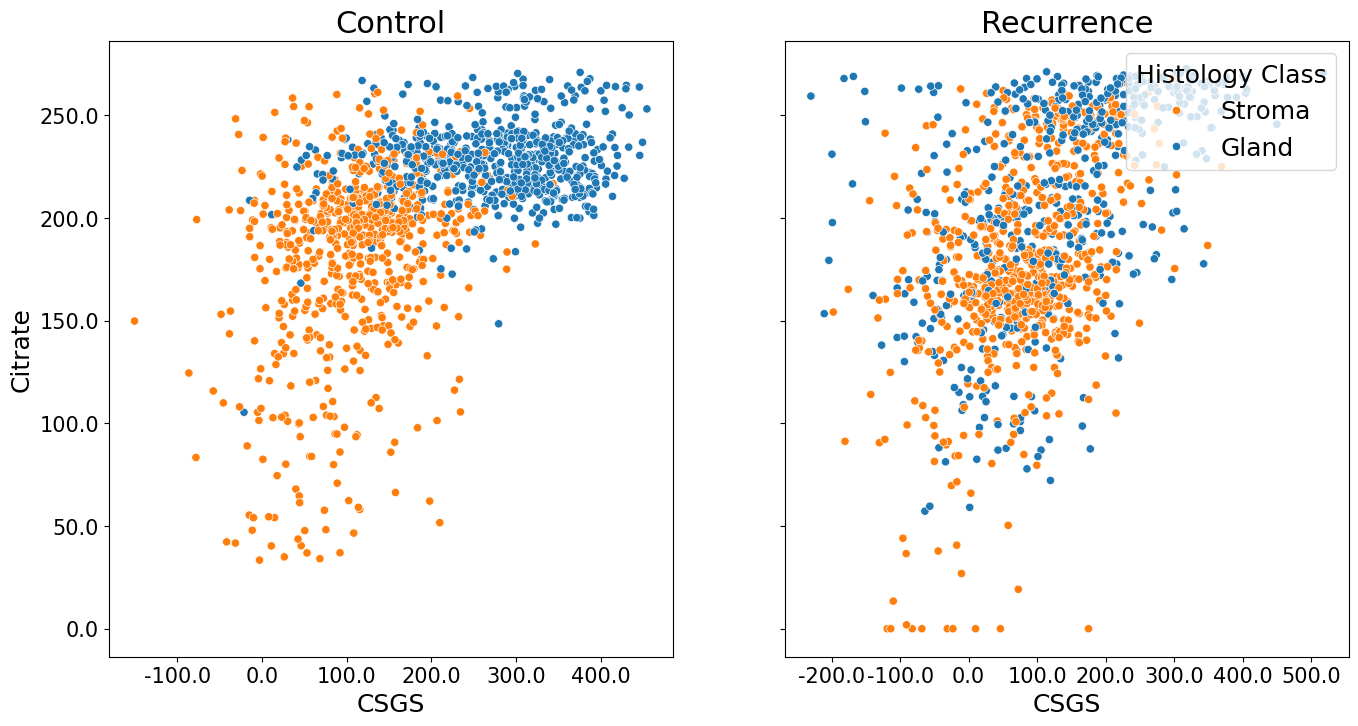

In [159]:
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_names = merged_pos_correct_df_red2.core_name.unique()
core_names = ['001_04', '002_01', '045_03']
_, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[0])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Citrate', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
ax.set_title('Control', fontsize=22)
sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
ax.legend([],[], frameon=False)

core_names = ['003_02', '004_03', '047_04', '048_02']
ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Citrate', hue='Histology Class', palette=color_mapping, ax=axs[1])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Citrate', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
ax.set_title('Recurrence', fontsize=22)
plt.savefig('../../images/citsper_citrate_analysis/scatterplot_csgs_citrate.png', transparent=True)

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


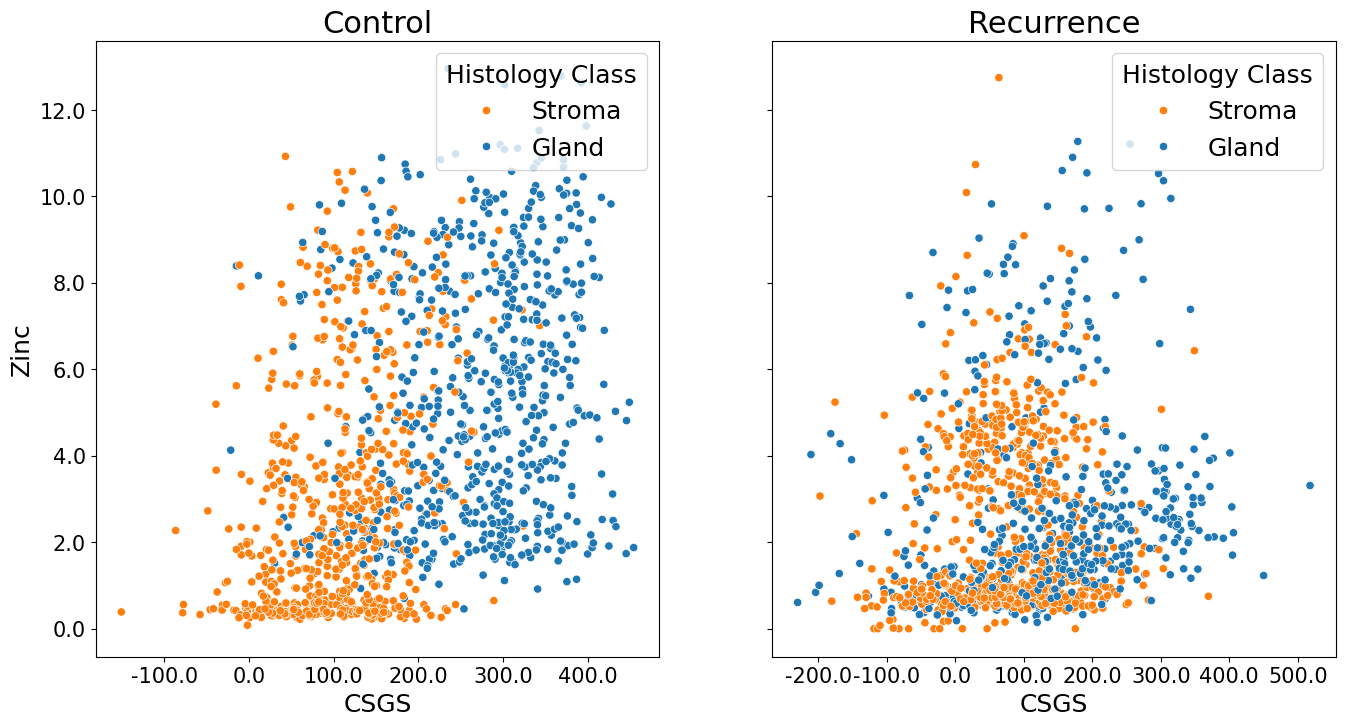

In [160]:
fontsize=18
tick_fontsize=15
standard_color = sns.color_palette()
color_mapping = {}
color_mapping['Stroma'] = standard_color[1]
color_mapping['Gland'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
core_names = merged_pos_correct_df_red2.core_name.unique()
core_names = ['001_04', '002_01', '045_03']
_, axs = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[0])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Zinc', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
ax.set_title('Control', fontsize=22)
sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)

core_names = ['003_02', '004_03', '047_04', '048_02']
ax = sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Zinc', hue='Histology Class', palette=color_mapping, ax=axs[1])
ax.set_xlabel('CSGS', fontsize=fontsize)
ax.set_ylabel('Zinc', fontsize=fontsize)
ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
ax.set_title('Recurrence', fontsize=22)
plt.savefig('../../images/citsper_citrate_analysis/scatterplot_csgs_zinc.png', transparent=True)

In [88]:
# fontsize=18
# tick_fontsize=15
# standard_color = sns.color_palette()
# color_mapping = {}
# color_mapping['Stroma'] = standard_color[1]
# color_mapping['Gland'] = standard_color[0]
# # merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# # merged_neg_correct_df[merged_neg_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# # merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Stroma'] = standard_color[0]
# # merged_pos_correct_df[merged_pos_correct_df['Histology Class'] == 'Non-cancer glands'] = standard_color[1]
# core_names = merged_pos_correct_df_red2.core_name.unique()
# core_names = ['001_04', '002_01', '045_03']
# _, axs = plt.subplots(1, 2, figsize=(16, 8))
# ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[0])
# ax.set_xlabel('CSGS', fontsize=fontsize)
# ax.set_ylabel('Spermine', fontsize=fontsize)
# ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
# ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)

# core_names = ['003_02', '004_03', '047_04', '048_02']
# ax = sns.scatterplot(data=merged_pos_correct_df_red2[merged_pos_correct_df_red2.core_name.isin(core_names)], x='Citsper', y='met_Spermine', hue='Histology Class', palette=color_mapping, ax=axs[1])
# ax.set_xlabel('CSGS', fontsize=fontsize)
# ax.set_ylabel('Spermine', fontsize=fontsize)
# ax.set_yticklabels(ax.get_yticks(), size=tick_fontsize)
# ax.set_xticklabels(ax.get_xticks(), size=tick_fontsize)
# # ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# # ax.legend(title='Histology Class', labels=['Stroma', 'Gland'])
# # sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# sns.move_legend(ax, "upper right", fontsize=fontsize, title_fontsize=fontsize)
# # plt.savefig('images/citsper_citrate_analysis/scatterplot_csgs_czs.png', transparent=True)

In [89]:
# sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == '047_04'], x='Citsper', y='met_Citrate', hue='Histology Class')

<Axes: xlabel='Citsper', ylabel='met_Citrate'>

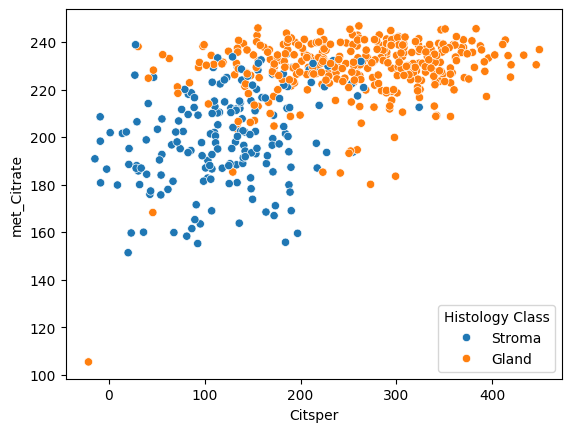

In [161]:
sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == '045_03'], x='Citsper', y='met_Citrate', hue='Histology Class')

<Axes: xlabel='Citsper', ylabel='met_Citrate'>

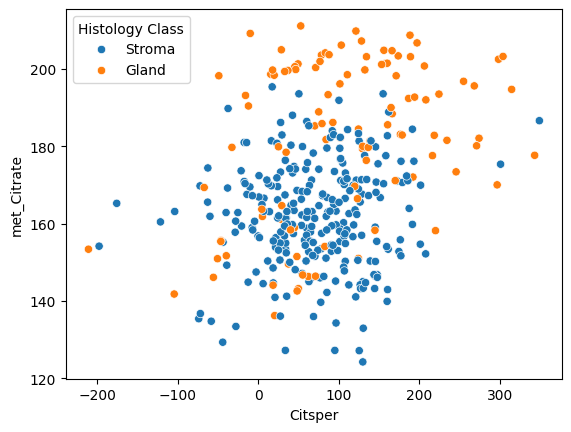

In [162]:
sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.core_name == '004_03'], x='Citsper', y='met_Citrate', hue='Histology Class')

In [67]:
merged_neg_correct_df_red2.core_name.unique()

array(['002_01', '001_04', '045_03', '048_02', '003_02', '004_03',
       '047_04'], dtype=object)

In [25]:
# import numpy as np
# import seaborn as sns; sns.set()
# import matplotlib.pyplot as plt
# fmri = sns.load_dataset("fmri")
# fmri.sort_values('timepoint',inplace=True)
# arr = np.ones(len(fmri))
# arr[:300] = 0
# arr[600:] = 2
# fmri['background'] = arr
# fmri['background'] = fmri['background'].astype(int).astype(str).map(lambda x: 'C'+str((int(x) +2)

# ax = sns.lineplot(x="timepoint", y="signal", hue="event", data=fmri)
# ranges = fmri.groupby('background')['timepoint'].agg(['min', 'max'])
# for i, row in ranges.iterrows():
#     ax.axvspan(xmin=row['min'], xmax=row['max'], facecolor=i, alpha=0.3)

In [75]:
fmri

subject  timepoint event    region    signal background
1063      s0          0   cue  parietal -0.006899         C2
258       s7          0  stim  parietal  0.004081         C2
259       s6          0  stim  parietal -0.023319         C2
260       s5          0  stim  parietal -0.051228         C2
865       s5          0   cue   frontal -0.027033         C2
...      ...        ...   ...       ...       ...        ...
713       s8         18   cue   frontal  0.014358         C4
712      s10         18   cue   frontal -0.003251         C4
710      s11         18   cue   frontal  0.090520         C4
722       s9         18   cue   frontal -0.000643         C4
531       s7         18  stim   frontal -0.019634         C4

[1064 rows x 6 columns]

<Axes: xlabel='Citsper', ylabel='met_Citrate'>

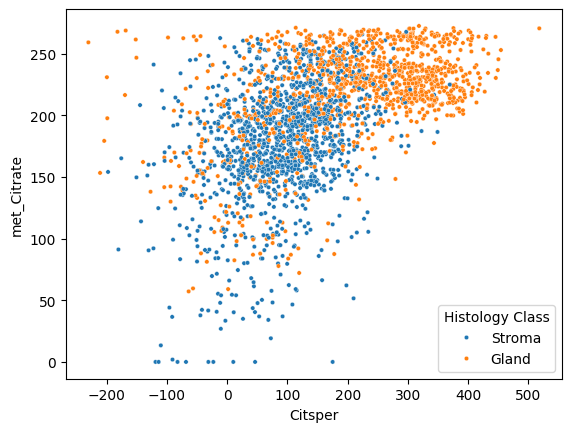

In [163]:
sns.scatterplot(data=merged_neg_correct_df_red2, x='Citsper', y='met_Citrate', hue='Histology Class', s=10)

<Axes: xlabel='Citsper', ylabel='met_Zinc'>

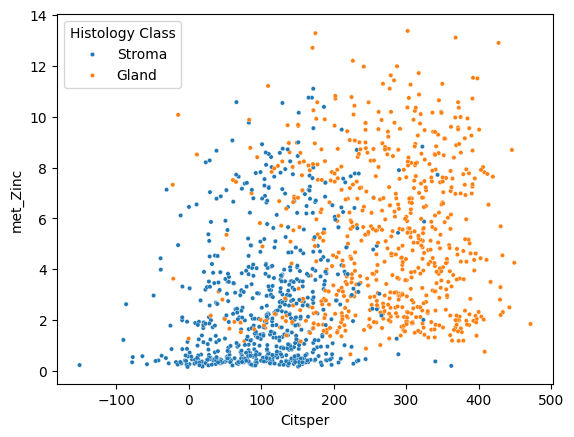

In [66]:
sns.scatterplot(data=merged_neg_correct_df_red2[merged_neg_correct_df_red2.recurrence=='control'], x='Citsper', y='met_Zinc', hue='Histology Class', s=10)

<Axes: xlabel='Citsper', ylabel='met_Spermine'>

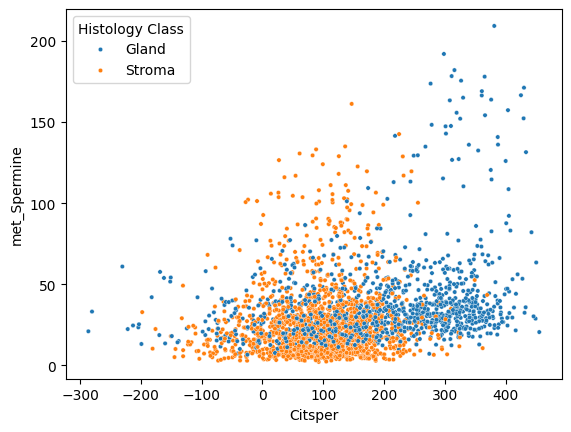

In [65]:
sns.scatterplot(data=merged_pos_correct_df_red2, x='Citsper', y='met_Spermine', hue='Histology Class', s=10)

In [77]:
rank_df = pd.read_csv('rankbased_experiments.csv', sep=';', index_col=[0,1])
multi_index = []
for idx in rank_df.index:
    if isinstance(idx[0], str):
        f_idx = idx[0]
        multi_index.append(idx)
        continue
    multi_index.append((f_idx, idx[1]))
multi_index = pd.MultiIndex.from_tuples(multi_index, names=['met', 'exp'])
rank_df.index = multi_index
rank_df

N1  N2  C3  C4  N5  C6  C7
met      exp                            
Citrate  ECM   1   1   1   1   1   1   1
         ECW   3   2   2   2   2   3   2
         EAM   2   3   4   3   3   2   3
         EAW   4   4   3   4   4   4   4
Zinc     ECM   1   1   4   1   1   1   1
         ECW   2   2   3   2   2   3   2
         EAM   3   3   1   3   3   2   3
         EAW   4   4   2   4   4   4   4
Spermine ECM   1   2   1   2   1   1   1
         ECW   2   1   2   1   2   3   2
         EAM   3   3   4   4   3   2   3
         EAW   4   4   3   3   4   4   4

In [180]:
rank_sic_df = pd.read_csv('rank_experiment_significance.csv', sep=';', index_col=[0,1])
multi_index = []
for idx in rank_sic_df.index:
    if isinstance(idx[0], str):
        f_idx = idx[0]
        multi_index.append(idx)
        continue
    multi_index.append((f_idx, idx[1]))
multi_index = pd.MultiIndex.from_tuples(multi_index, names=['met', 'exp'])
rank_sic_df.index = multi_index
rank_sic_df

FileNotFoundError: [Errno 2] No such file or directory: 'rank_experiment_significance.csv'

In [87]:
rank_sic_mat.sum(1)

array([6, 6, 4, 1, 6, 6, 3, 1, 7, 7, 3, 0], dtype=object)

In [79]:
rank_mat = rank_df.to_numpy()
rank_sic_mat = rank_sic_df.to_numpy()

In [81]:
rank_sic_mat[rank_sic_mat == '*'] = 1
rank_sic_mat[rank_sic_mat != 1] = 0
rank_sic_mat

array([[1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 1, 1, 1, 1],
       [1, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [84]:
joined_rank_mat = rank_mat * rank_sic_mat
for i in range(joined_rank_mat.shape[0]):
    row = joined_rank_mat[i, :]
    row = row[row != 0]
    print(row.mean())

1.0
2.3333333333333335
2.5
4.0
1.0
2.1666666666666665
2.6666666666666665
4.0
1.2857142857142858
1.8571428571428572
2.6666666666666665
nan


Mean of empty slice.
invalid value encountered in scalar divide


In [85]:
joined_rank_mat

array([[1, 1, 0, 1, 1, 1, 1],
       [3, 2, 0, 2, 2, 3, 2],
       [2, 3, 0, 0, 3, 2, 0],
       [0, 0, 0, 0, 0, 4, 0],
       [1, 1, 0, 1, 1, 1, 1],
       [2, 2, 0, 2, 2, 3, 2],
       [3, 3, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 4, 0],
       [1, 2, 1, 2, 1, 1, 1],
       [2, 1, 2, 1, 2, 3, 2],
       [3, 0, 0, 0, 3, 2, 0],
       [0, 0, 0, 0, 0, 0, 0]], dtype=object)

In [177]:
all_stats[all_stats.metabolite == 'citrate'][['Dataset', 'sample_id', 'Spearman correlation', 'pvalue']].to_csv('corr_citrate.csv')
all_stats[all_stats.metabolite == 'zinc'][['Dataset', 'sample_id', 'Spearman correlation', 'pvalue']].to_csv('corr_zinc.csv')
all_stats[all_stats.metabolite == 'spermine'][['Dataset', 'sample_id', 'Spearman correlation', 'pvalue']].to_csv('corr_spermine.csv')

In [171]:
all_stats

Spearman correlation     pvalue    n            Dataset type core_id  \
001_04                 0.573  1.053e-33  371            IntMatchHist  001_04   
002_01                 0.601  8.019e-39  381            IntMatchHist  002_01   
003_02                 0.200  5.319e-03  192            IntMatchHist  003_02   
004_03                 0.237  4.303e-06  369            IntMatchHist  004_03   
045_03                 0.539  2.762e-42  543            IntMatchHist  045_03   
...                      ...        ...  ...                     ...     ...   
003_02                -0.098  5.305e-02  388  ArtIntWithoutMatchHist  003_02   
004_03                 0.107  2.129e-02  464  ArtIntWithoutMatchHist  004_03   
045_03                 0.115  3.497e-03  643  ArtIntWithoutMatchHist  045_03   
047_04                 0.098  1.748e-02  591  ArtIntWithoutMatchHist  047_04   
048_02                -0.050  3.369e-01  375  ArtIntWithoutMatchHist  048_02   

       sample_id background metabolite         Experiment type  \
001_04     P06_7        C03    citrate            IntMatchHist   
002_01     P04_3        C03    citrate            IntMatchHist   
003_02     P08_3        C03    citrate            IntMatchHist   
004_03     P07_7        C03    citrate            IntMatchHist   
045_03     P28_3        C03    citrate            IntMatchHist   
...          ...        ...        ...                     ...   
003_02     P08_3        NaN   spermine  ArtIntWithoutMatchHist   
004_03     P07_7        NaN   spermine  ArtIntWithoutMatchHist   
045_03     P28_3        NaN   spermine  ArtIntWithoutMatchHist   
047_04     P30_4        NaN   spermine  ArtIntWithoutMatchHist   
048_02     P22_4        NaN   spermine  ArtIntWithoutMatchHist   

                       Dataset  z_transformed_correlations  
001_04            IntMatchHist                       0.651  
002_01            IntMatchHist                       0.695  
003_02            IntMatchHist                       0.203  
004_03            IntMatchHist                       0.241  
045_03            IntMatchHist                       0.603  
...                        ...                         ...  
003_02  ArtIntWithoutMatchHist                      -0.099  
004_03  ArtIntWithoutMatchHist                       0.107  
045_03  ArtIntWithoutMatchHist                       0.116  
047_04  ArtIntWithoutMatchHist                       0.098  
048_02  ArtIntWithoutMatchHist                      -0.050  

[84 rows x 11 columns]